# Baseline: FCN

# 목차

1. [Imports & Global Constants](#Imports-&-Global-Constants): 학습에 필요한 라이브러리들을 임포트 하고 미션 안에서 이루어지는 학습 전반을 컨트롤 하기 위한 파라미터들을 설정합니다.
2. [Check the Size of the Dataset](#Check-the-Size-of-the-Dataset): 학습에 사용될 데이터가 잘 준비되어있는지 확인합니다.
3. [Define Dataset Class](#Define-Dataset-Class): 데이터를 원하는 형태로 불러오기 위한 Dataset 클래스를 정의하고, validation을 위한 데이터 스플릿을 진행합니다.
4. [Check Data Sample](#Check-Data-Sample): 제공된 데이터가 어떤 모습인지 확인합니다.
5. [Setup Dataloader](#Setup-Dataloader): 학습을 위해 데이터를 배치로 불러오기 위한 Dataloader를 만듭니다.
6. [Define Functions for Training](#Define-Functions-for-Training): 학습을 도와주는 함수들을 정의합니다.
7. [Training](#Training): 학습을 진행합니다.
8. [Inference](#Inference): 인퍼런스에 필요한 함수들을 정의하고, 인퍼런스를 진행합니다.
9. [Result Visualization](#Result-Visualization): 인퍼런스 결과를 확인해봅니다.
10. [To CSV](#To-CSV): 인퍼런스 결과를 제출을 위한 포맷으로 변경합니다.

# Imports & Global Constants

In [3]:
# 노트북 실행에 필요한 라이브러리를 설치합니다
'''
!pip install opencv-python-headless==4.10.0.84
!pip install pandas==2.2.3
!pip install -U scikit-learn==1.5.2
!pip install albumentations==1.4.18
!pip install matplotlib==3.9.2
'''

'\n!pip install opencv-python-headless==4.10.0.84\n!pip install pandas==2.2.3\n!pip install -U scikit-learn==1.5.2\n!pip install albumentations==1.4.18\n!pip install matplotlib==3.9.2\n'

In [4]:
# python native
import os
import json
import random
import datetime
from functools import partial

# external library
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import GroupKFold
import albumentations as A

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models

# visualization
import matplotlib.pyplot as plt

import wandb

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [5]:
# 데이터 경로를 입력하세요

IMAGE_ROOT = "../data/train/DCM"
LABEL_ROOT = "../data/train/outputs_json"

In [6]:
CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]

In [7]:
CLASS2IND = {v: i for i, v in enumerate(CLASSES)}

In [8]:
IND2CLASS = {v: k for k, v in CLASS2IND.items()}

In [9]:
BATCH_SIZE = 2
ACCUMULATION_STEPS = 4

LR = 1e-4
RANDOM_SEED = 21

NUM_EPOCHS = 150#############
VAL_EVERY = 2

SAVED_DIR = "checkpoints"

if not os.path.exists(SAVED_DIR):                                                           
    os.makedirs(SAVED_DIR)

# Check the Size of the Dataset

`IMAGE_ROOT` 아래에 있는 모든 폴더를 재귀적으로 순회하면서 확장자가 `.png`인 파일들을 찾습니다.

In [10]:
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

In [11]:
len(pngs)

800

마찬가지로 `LABEL_ROOT` 아래에 있는 모든 폴더를 재귀적으로 순회하면서 확장자가 `.json`인 파일들을 찾습니다.

In [12]:
jsons = {
    os.path.relpath(os.path.join(root, fname), start=LABEL_ROOT)
    for root, _dirs, files in os.walk(LABEL_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".json"
}

In [13]:
len(jsons)

800

모든 `.png` 파일에 대해 `.json` pair가 존재하는지 체크합니다. 파일명에서 확장자를 제거한 set을 생성하고 두 집합의 차집합의 크기가 0인지 확인합니다.

In [14]:
jsons_fn_prefix = {os.path.splitext(fname)[0] for fname in jsons}
pngs_fn_prefix = {os.path.splitext(fname)[0] for fname in pngs}

assert len(jsons_fn_prefix - pngs_fn_prefix) == 0
assert len(pngs_fn_prefix - jsons_fn_prefix) == 0

모든 `.png` 파일에 대해 label이 존재하는 것을 확인했습니다. 이름 순으로 정렬해서 짝이 맞도록 합니다.

In [15]:
pngs = sorted(pngs)
jsons = sorted(jsons)

# Define Dataset Class

In [16]:
import os
import cv2
import json
import torch
import numpy as np
from torch.utils.data import Dataset
from sklearn.model_selection import GroupKFold
from collections import defaultdict

class XRayDataset(Dataset):
    def __init__(self, is_train=True, transforms=None):
        # 전역 변수 pngs, jsons를 가져옵니다.
        _filenames = np.array(pngs)
        _labelnames = np.array(jsons)
        
        # 핸드 타입(Left/Right) 자동 매핑 로직 
        # 같은 ID 폴더 내에서 파일명 정렬 시 1번째=Right, 2번째=Left
        self.hand_side_map = {}
        
        # 폴더별로 파일 그룹화
        files_by_folder = defaultdict(list)
        for fname in _filenames:
            folder = os.path.dirname(fname)
            files_by_folder[folder].append(fname)
            
        # 정렬 후 Right/Left 할당
        for folder, files in files_by_folder.items():
            files.sort() # 이름순 정렬
            if len(files) > 0:
                self.hand_side_map[files[0]] = 'Right' # 첫 번째는 오른손
            if len(files) > 1:
                self.hand_side_map[files[1]] = 'Left'  # 두 번째는 왼손
        # -------------------------------------------------------

        # split train-valid
        groups = [os.path.dirname(fname) for fname in _filenames]
        
        # dummy label
        ys = [0 for fname in _filenames]
        
        gkf = GroupKFold(n_splits=5)
        
        filenames = []
        labelnames = []
        for i, (x, y) in enumerate(gkf.split(_filenames, ys, groups)):
            if is_train:
                if i == 0: # 0번을 validation dataset으로 사용
                    continue
                filenames += list(_filenames[y])
                labelnames += list(_labelnames[y])
            else:
                filenames = list(_filenames[y])
                labelnames = list(_labelnames[y])
                break # validation용 1개 fold만 사용
        
        self.filenames = filenames
        self.labelnames = labelnames
        self.is_train = is_train
        self.transforms = transforms
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, item):
        image_name = self.filenames[item]
        image_path = os.path.join(IMAGE_ROOT, image_name)
        
        # 이미지 로드
        image = cv2.imread(image_path)
        image = image / 255.
        
        label_name = self.labelnames[item]
        label_path = os.path.join(LABEL_ROOT, label_name)
        
        # (H, W, NC) 모양의 label을 생성
        # 주의: image.shape가 (H, W, C)라고 가정
        label_shape = tuple(image.shape[:2]) + (len(CLASSES), )
        label = np.zeros(label_shape, dtype=np.uint8)
        
        # label 파일을 읽음.
        with open(label_path, "r") as f:
            annotations = json.load(f)
        annotations = annotations["annotations"]
        
        # 클래스 별로 처리
        for ann in annotations:
            c = ann["label"]
            class_ind = CLASS2IND[c]
            points = np.array(ann["points"])
            
            # polygon 포맷을 dense한 mask 포맷으로 바꿈.
            class_label = np.zeros(image.shape[:2], dtype=np.uint8)
            cv2.fillPoly(class_label, [points], 1)
            label[..., class_ind] = class_label
        
        # --- 오른손(Right)일 경우 Flip 적용 ---
        # 현재 이미지가 'Right'라면 좌우 반전시켜 'Left'처럼 만듦.
        hand_side = self.hand_side_map.get(image_name, 'Unknown')
        
        if hand_side == 'Right':
            # Horizontal Flip (좌우 반전)
            image = cv2.flip(image, 1)
            label = cv2.flip(label, 1)
        
        if self.transforms is not None:
            inputs = {"image": image, "mask": label}
            result = self.transforms(**inputs)
            
            image = result["image"]
            label = result["mask"]

        # to tensor
        image = image.transpose(2, 0, 1)    # channel first 포맷으로 변경
        label = label.transpose(2, 0, 1)
        
        image = torch.from_numpy(image).float()
        label = torch.from_numpy(label).float()
            
        return image, label

# Check Data Sample

In [17]:
# 시각화를 위한 팔레트를 설정
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

# 시각화 함수입니다. 클래스가 2개 이상인 픽셀을 고려하지는 않습니다.
def label2rgb(label):
    image_size = label.shape[1:] + (3, )
    image = np.zeros(image_size, dtype=np.uint8)
    
    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]
        
    return image

In [18]:
#tf = A.Resize(2048, 2048)
train_tf = A.Compose([
    A.Resize(2048, 2048),
        A.ShiftScaleRotate(
        shift_limit=0.1, 
        scale_limit=0.2, 
        rotate_limit=30, 
        border_mode=cv2.BORDER_CONSTANT, 
        value=0, mask_value=0,
        p=0.5
    ),
    A.RandomBrightnessContrast(
        brightness_limit=0.2, 
        contrast_limit=0.2, 
        p=0.5
    ),
    A.CoarseDropout(
        max_holes=10,        # 구멍의 최대 개수
        max_height=128,      # 최대 크기
        max_width=128,       ##
        min_holes=2,         # 최소 2개
        min_height=32,       # 최소 크기
        min_width=32,        #
        fill_value=0,        # 이미지 구멍을 검은색(0)으로 채움
        mask_fill_value=None,# 마스크(Label)는 지우지 않음
        p=0.3                # 30% 확률로 적용
    ),
])

valid_tf = A.Compose([
    A.Resize(2048, 2048),
])

In [19]:
train_dataset = XRayDataset(is_train=True, transforms=train_tf)
valid_dataset = XRayDataset(is_train=False, transforms=valid_tf)

In [20]:
image, label = train_dataset[0]

In [21]:
print(image.shape, label.shape)

torch.Size([3, 2048, 2048]) torch.Size([29, 2048, 2048])


In [22]:
len(train_dataset)

640

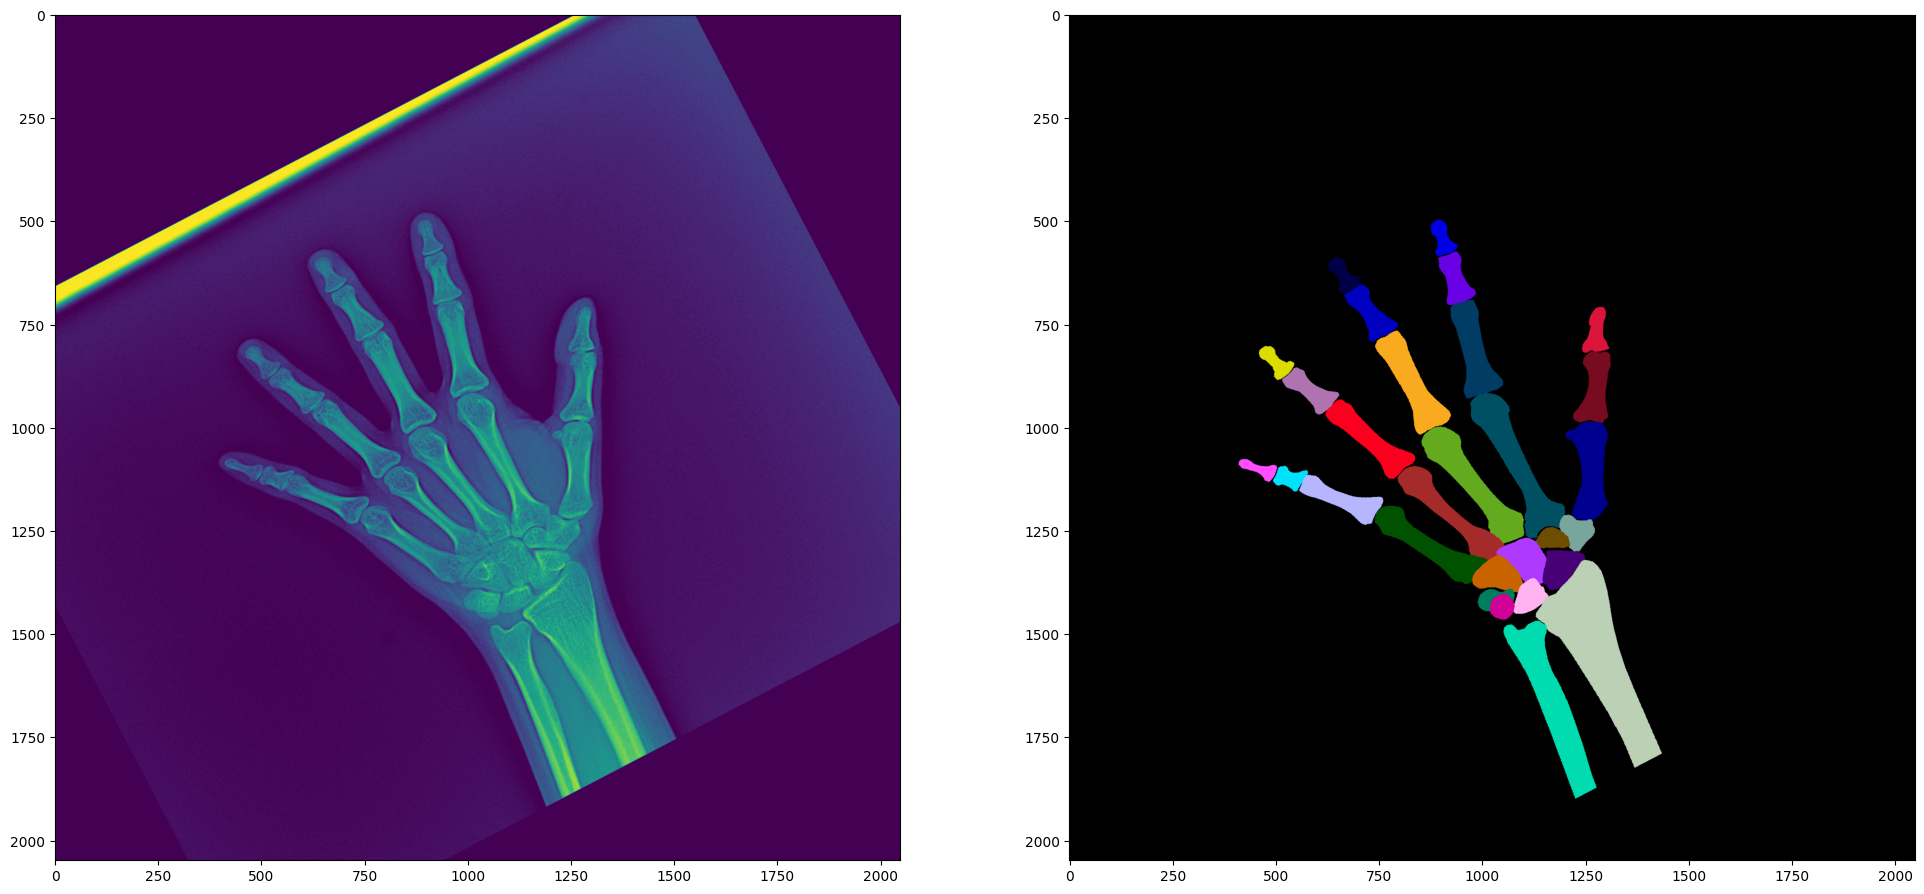

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].imshow(image[0])    # color map 적용을 위해 channel 차원을 생략합니다.
ax[1].imshow(label2rgb(label))

plt.show()

# Setup Dataloader

In [24]:
train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    drop_last=True,
)

# 주의: validation data는 이미지 크기가 크기 때문에 `num_wokers`는 커지면 메모리 에러가 발생할 수 있습니다.
valid_loader = DataLoader(
    dataset=valid_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    drop_last=False
)

# Define Functions for Training

In [25]:
model_name = f'efficientnetb3_unetplusplus_2048_left.pt'

In [26]:
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten(2)
    y_pred_f = y_pred.flatten(2)
    intersection = torch.sum(y_true_f * y_pred_f, -1)
    
    eps = 0.0001
    return (2. * intersection + eps) / (torch.sum(y_true_f, -1) + torch.sum(y_pred_f, -1) + eps)

In [27]:
def save_model(model, file_name=model_name):
    output_path = os.path.join(SAVED_DIR, file_name)
    torch.save(model, output_path)

In [28]:
def set_seed():
    torch.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED) # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(RANDOM_SEED)
    random.seed(RANDOM_SEED)

In [29]:
def validation(epoch, model, data_loader, criterion, thr=0.5):
    print(f'Start validation #{epoch:2d}')
    model.eval()
    model = model.cuda()

    dices = []
    total_loss = 0
    cnt = 0
    
    with torch.no_grad():
        n_class = len(CLASSES)
        total_loss = 0
        cnt = 0

        for step, (images, masks) in tqdm(enumerate(data_loader), total=len(data_loader)):
            images, masks = images.cuda(), masks.cuda()         
            
            outputs = model(images)
            
            output_h, output_w = outputs.size(-2), outputs.size(-1)
            mask_h, mask_w = masks.size(-2), masks.size(-1)
            
            # gt와 prediction의 크기가 다른 경우 prediction을 gt에 맞춰 interpolation 합니다.
            if output_h != mask_h or output_w != mask_w:
                outputs = F.interpolate(outputs, size=(mask_h, mask_w), mode="bilinear")
            
            loss = criterion(outputs, masks)
            total_loss += loss.item()
            cnt += 1
            
            outputs = torch.sigmoid(outputs)
            outputs = (outputs > thr).detach()
            masks = masks.detach()
            
            dice = dice_coef(outputs, masks)
            dices.append(dice.cpu())
                
    dices = torch.cat(dices, 0)
    dices_per_class = torch.mean(dices, 0)
    dice_str = [
        f"{c:<12}: {d.item():.4f}"
        for c, d in zip(CLASSES, dices_per_class)
    ]
    dice_str = "\n".join(dice_str)
    print(dice_str)
    
    avg_dice = torch.mean(dices_per_class).item()
    avg_loss = total_loss / cnt

    wandb_logs = {
        "Val/Mean_Dice": avg_dice,
        "Val/Loss": avg_loss,
        "Epoch": epoch
    }

    for class_name, score in zip(CLASSES, dices_per_class):
        wandb_logs[f"Val/Dice_{class_name}"] = score.item()
    
    wandb.log(wandb_logs)
    
    return avg_dice

In [28]:
import torch
from torch.cuda.amp import autocast, GradScaler
from tqdm.auto import tqdm
import datetime
import gc

def train(model, data_loader, val_loader, criterion, optimizer, patience=10):
    print(f'Start training with Mixed Precision (FP16)..')
    
    n_class = len(CLASSES)
    best_dice = 0.
    model = model.cuda()

    patience_check = 0
    
    #  GradScaler 초기화
    # FP16 학습 시 Gradient가 너무 작아져서 0이 되는(Underflow) 현상을 방지
    scaler = GradScaler() 

    optimizer.zero_grad()
    
    for epoch in range(NUM_EPOCHS):
        gc.collect()
        torch.cuda.empty_cache()
        
        model.train()
        epoch_loss = 0.0

        loop = tqdm(enumerate(data_loader), total=len(data_loader), desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
        
        for step, (images, masks) in loop:            
            images, masks = images.cuda(), masks.cuda()
            
            # autocast 컨텍스트 매니저 사용
            # 이 블록 안의 연산(Forward, Loss)은 자동으로 상황에 따라 float16/float32를 섞어씀.
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, masks)
                loss = loss / ACCUMULATION_STEPS # Gradient Accumulation 적용
            
            # Scaler를 이용한 Backward
            # loss.backward() 대신 scaler.scale(loss).backward()를 사용
            scaler.scale(loss).backward()

            # Gradient Accumulation Step 도달 시
            if (step + 1) % ACCUMULATION_STEPS == 0:
                # Scaler를 이용한 Optimizer Step
                # optimizer.step() 대신 scaler.step(optimizer)를 사용
                scaler.step(optimizer)
                
                # Scaler 업데이트
                scaler.update()
                
                optimizer.zero_grad()
                
            
            #로그 및 출력
            current_loss = loss.item() * ACCUMULATION_STEPS
            
            # WandB 로그 (스텝 단위)
            wandb.log({
                "Train/Step_Total_Loss": current_loss,
                "Train/Learning_Rate": optimizer.param_groups[0]['lr']
            })
            
            epoch_loss += current_loss

            loop.set_postfix({
                "Loss": f"{loss.item():.4f}",
                "LR": f"{optimizer.param_groups[0]['lr']:.6f}"
            })
            
            if (step + 1) % 25 == 0:
                print(
                    f'{datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")} | '
                    f'Epoch [{epoch+1}/{NUM_EPOCHS}], '
                    f'Step [{step+1}/{len(data_loader)}], ' # train_loader -> data_loader 변수명 통일
                    f'Loss: {round(current_loss,4)}'
                )
                
        #scheduler.step()
                
        avg_loss = epoch_loss / len(data_loader)
        wandb.log({"Train/Epoch_Loss": avg_loss, "Epoch": epoch + 1})
             
        # validation 주기에 따라 loss를 출력하고 best model을 저장
        if (epoch + 1) % VAL_EVERY == 0:
            dice = validation(epoch + 1, model, val_loader, criterion)
            
            if best_dice < dice:
                print(f"Best performance at epoch: {epoch + 1}, {best_dice:.4f} -> {dice:.4f}")
                print(f"Save model in {SAVED_DIR}")
                best_dice = dice
                save_model(model)
                
                patience_check = 0
            else:
                patience_check += 1
                print(f"Early Stopping Counter: {patience_check}/{patience}")
                
                if patience_check >= patience:
                    print(f"Early stopping triggered at epoch {epoch + 1}!")
                    break

# Training

In [29]:
#!pip install segmentation-models-pytorch

In [ ]:
import segmentation_models_pytorch as smp

encoder_name = "efficientnet-b3"

model = smp.DeepLabV3Plus(
    encoder_name=encoder_name,    
    encoder_weights="imagenet",
    in_channels=3,  
    classes=len(CLASSES)      
)

In [31]:
dice_loss_fn = smp.losses.DiceLoss(mode='multilabel', from_logits=True)
bce_loss_fn = nn.BCEWithLogitsLoss()

def criterion(y_pred, y_true):
    loss_bce = bce_loss_fn(y_pred, y_true)
    loss_dice = dice_loss_fn(y_pred, y_true)
    return 0.5 * loss_bce + 0.5 * loss_dice
    
optimizer = optim.Adam(params=model.parameters(), lr=LR, weight_decay=1e-6)

In [32]:
# 시드를 설정합니다.
set_seed()

In [33]:
wandb.init(project="deeplab_v3_plus", 
           name=f"{model_name}",
           config={"epochs": NUM_EPOCHS,"lr": LR}
          )

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [34]:
train(model, train_loader, valid_loader, criterion, optimizer)

Start training with Mixed Precision (FP16)..


Epoch 1/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 14:55:15 | Epoch [1/150], Step [25/320], Loss: 0.8719
2026-01-01 14:55:59 | Epoch [1/150], Step [50/320], Loss: 0.8669
2026-01-01 14:56:45 | Epoch [1/150], Step [75/320], Loss: 0.8523
2026-01-01 14:57:27 | Epoch [1/150], Step [100/320], Loss: 0.8457
2026-01-01 14:58:13 | Epoch [1/150], Step [125/320], Loss: 0.8376
2026-01-01 14:58:58 | Epoch [1/150], Step [150/320], Loss: 0.8302
2026-01-01 14:59:41 | Epoch [1/150], Step [175/320], Loss: 0.8244
2026-01-01 15:00:24 | Epoch [1/150], Step [200/320], Loss: 0.8135
2026-01-01 15:01:09 | Epoch [1/150], Step [225/320], Loss: 0.8063
2026-01-01 15:01:53 | Epoch [1/150], Step [250/320], Loss: 0.7965
2026-01-01 15:02:34 | Epoch [1/150], Step [275/320], Loss: 0.7886
2026-01-01 15:03:16 | Epoch [1/150], Step [300/320], Loss: 0.7803


Epoch 2/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 15:04:44 | Epoch [2/150], Step [25/320], Loss: 0.7626
2026-01-01 15:05:29 | Epoch [2/150], Step [50/320], Loss: 0.7545
2026-01-01 15:06:13 | Epoch [2/150], Step [75/320], Loss: 0.7462
2026-01-01 15:06:54 | Epoch [2/150], Step [100/320], Loss: 0.7375
2026-01-01 15:07:39 | Epoch [2/150], Step [125/320], Loss: 0.7272
2026-01-01 15:08:23 | Epoch [2/150], Step [150/320], Loss: 0.7194
2026-01-01 15:09:08 | Epoch [2/150], Step [175/320], Loss: 0.7117
2026-01-01 15:09:51 | Epoch [2/150], Step [200/320], Loss: 0.7051
2026-01-01 15:10:36 | Epoch [2/150], Step [225/320], Loss: 0.6966
2026-01-01 15:11:18 | Epoch [2/150], Step [250/320], Loss: 0.6896
2026-01-01 15:12:02 | Epoch [2/150], Step [275/320], Loss: 0.6834
2026-01-01 15:12:45 | Epoch [2/150], Step [300/320], Loss: 0.6778
Start validation # 2


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.0000
finger-2    : 0.0001
finger-3    : 0.0048
finger-4    : 0.0000
finger-5    : 0.0028
finger-6    : 0.0000
finger-7    : 0.0071
finger-8    : 0.0090
finger-9    : 0.0001
finger-10   : 0.0019
finger-11   : 0.0001
finger-12   : 0.0000
finger-13   : 0.0022
finger-14   : 0.0033
finger-15   : 0.0098
finger-16   : 0.0040
finger-17   : 0.0000
finger-18   : 0.0209
finger-19   : 0.0563
Trapezium   : 0.0078
Trapezoid   : 0.0000
Capitate    : 0.0000
Hamate      : 0.0002
Scaphoid    : 0.0000
Lunate      : 0.0155
Triquetrum  : 0.0236
Pisiform    : 0.0024
Radius      : 0.0000
Ulna        : 0.0028
Best performance at epoch: 2, 0.0000 -> 0.0060
Save model in checkpoints


Epoch 3/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 15:16:04 | Epoch [3/150], Step [25/320], Loss: 0.6667
2026-01-01 15:16:45 | Epoch [3/150], Step [50/320], Loss: 0.6613
2026-01-01 15:17:33 | Epoch [3/150], Step [75/320], Loss: 0.656
2026-01-01 15:18:14 | Epoch [3/150], Step [100/320], Loss: 0.6507
2026-01-01 15:18:58 | Epoch [3/150], Step [125/320], Loss: 0.6449
2026-01-01 15:19:40 | Epoch [3/150], Step [150/320], Loss: 0.64
2026-01-01 15:20:24 | Epoch [3/150], Step [175/320], Loss: 0.6355
2026-01-01 15:21:08 | Epoch [3/150], Step [200/320], Loss: 0.6302
2026-01-01 15:21:56 | Epoch [3/150], Step [225/320], Loss: 0.6278
2026-01-01 15:22:40 | Epoch [3/150], Step [250/320], Loss: 0.6218
2026-01-01 15:23:22 | Epoch [3/150], Step [275/320], Loss: 0.618
2026-01-01 15:24:05 | Epoch [3/150], Step [300/320], Loss: 0.6145


Epoch 4/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 15:25:34 | Epoch [4/150], Step [25/320], Loss: 0.6069
2026-01-01 15:26:18 | Epoch [4/150], Step [50/320], Loss: 0.6031
2026-01-01 15:27:01 | Epoch [4/150], Step [75/320], Loss: 0.5995
2026-01-01 15:27:44 | Epoch [4/150], Step [100/320], Loss: 0.5964
2026-01-01 15:28:27 | Epoch [4/150], Step [125/320], Loss: 0.5926
2026-01-01 15:29:12 | Epoch [4/150], Step [150/320], Loss: 0.5909
2026-01-01 15:29:58 | Epoch [4/150], Step [175/320], Loss: 0.5864
2026-01-01 15:30:41 | Epoch [4/150], Step [200/320], Loss: 0.5844
2026-01-01 15:31:26 | Epoch [4/150], Step [225/320], Loss: 0.5808
2026-01-01 15:32:11 | Epoch [4/150], Step [250/320], Loss: 0.5793
2026-01-01 15:32:54 | Epoch [4/150], Step [275/320], Loss: 0.5756
2026-01-01 15:33:38 | Epoch [4/150], Step [300/320], Loss: 0.574
Start validation # 4


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.0000
finger-2    : 0.0000
finger-3    : 0.0000
finger-4    : 0.0000
finger-5    : 0.0004
finger-6    : 0.0000
finger-7    : 0.7367
finger-8    : 0.0000
finger-9    : 0.0000
finger-10   : 0.0000
finger-11   : 0.0000
finger-12   : 0.0000
finger-13   : 0.0000
finger-14   : 0.0002
finger-15   : 0.0000
finger-16   : 0.0000
finger-17   : 0.0000
finger-18   : 0.0000
finger-19   : 0.0000
Trapezium   : 0.0000
Trapezoid   : 0.0000
Capitate    : 0.0000
Hamate      : 0.0000
Scaphoid    : 0.0000
Lunate      : 0.0018
Triquetrum  : 0.0000
Pisiform    : 0.0000
Radius      : 0.0000
Ulna        : 0.0000
Best performance at epoch: 4, 0.0060 -> 0.0255
Save model in checkpoints


Epoch 5/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 15:36:57 | Epoch [5/150], Step [25/320], Loss: 0.5704
2026-01-01 15:37:41 | Epoch [5/150], Step [50/320], Loss: 0.5695
2026-01-01 15:38:24 | Epoch [5/150], Step [75/320], Loss: 0.5657
2026-01-01 15:39:07 | Epoch [5/150], Step [100/320], Loss: 0.5631
2026-01-01 15:39:53 | Epoch [5/150], Step [125/320], Loss: 0.5624
2026-01-01 15:40:39 | Epoch [5/150], Step [150/320], Loss: 0.5613
2026-01-01 15:41:23 | Epoch [5/150], Step [175/320], Loss: 0.5579
2026-01-01 15:42:05 | Epoch [5/150], Step [200/320], Loss: 0.5568
2026-01-01 15:42:49 | Epoch [5/150], Step [225/320], Loss: 0.5555
2026-01-01 15:43:33 | Epoch [5/150], Step [250/320], Loss: 0.5553
2026-01-01 15:44:16 | Epoch [5/150], Step [275/320], Loss: 0.5505
2026-01-01 15:44:59 | Epoch [5/150], Step [300/320], Loss: 0.5497


Epoch 6/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 15:46:25 | Epoch [6/150], Step [25/320], Loss: 0.5466
2026-01-01 15:47:09 | Epoch [6/150], Step [50/320], Loss: 0.5445
2026-01-01 15:47:56 | Epoch [6/150], Step [75/320], Loss: 0.5441
2026-01-01 15:48:36 | Epoch [6/150], Step [100/320], Loss: 0.5419
2026-01-01 15:49:18 | Epoch [6/150], Step [125/320], Loss: 0.5413
2026-01-01 15:50:00 | Epoch [6/150], Step [150/320], Loss: 0.5375
2026-01-01 15:50:45 | Epoch [6/150], Step [175/320], Loss: 0.5373
2026-01-01 15:51:27 | Epoch [6/150], Step [200/320], Loss: 0.5363
2026-01-01 15:52:09 | Epoch [6/150], Step [225/320], Loss: 0.5333
2026-01-01 15:52:53 | Epoch [6/150], Step [250/320], Loss: 0.5312
2026-01-01 15:53:36 | Epoch [6/150], Step [275/320], Loss: 0.5303
2026-01-01 15:54:19 | Epoch [6/150], Step [300/320], Loss: 0.5297
Start validation # 6


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.0000
finger-2    : 0.0000
finger-3    : 0.0000
finger-4    : 0.0000
finger-5    : 0.0000
finger-6    : 0.1372
finger-7    : 0.6889
finger-8    : 0.0006
finger-9    : 0.0062
finger-10   : 0.0001
finger-11   : 0.0096
finger-12   : 0.0000
finger-13   : 0.0000
finger-14   : 0.6663
finger-15   : 0.0000
finger-16   : 0.0000
finger-17   : 0.0000
finger-18   : 0.0000
finger-19   : 0.0000
Trapezium   : 0.0000
Trapezoid   : 0.0000
Capitate    : 0.0000
Hamate      : 0.0000
Scaphoid    : 0.0000
Lunate      : 0.0108
Triquetrum  : 0.0000
Pisiform    : 0.0000
Radius      : 0.9272
Ulna        : 0.0000
Best performance at epoch: 6, 0.0255 -> 0.0844
Save model in checkpoints


Epoch 7/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 15:57:45 | Epoch [7/150], Step [25/320], Loss: 0.5269
2026-01-01 15:58:27 | Epoch [7/150], Step [50/320], Loss: 0.526
2026-01-01 15:59:12 | Epoch [7/150], Step [75/320], Loss: 0.5241
2026-01-01 15:59:53 | Epoch [7/150], Step [100/320], Loss: 0.5225
2026-01-01 16:00:39 | Epoch [7/150], Step [125/320], Loss: 0.522
2026-01-01 16:01:22 | Epoch [7/150], Step [150/320], Loss: 0.5204
2026-01-01 16:02:06 | Epoch [7/150], Step [175/320], Loss: 0.5177
2026-01-01 16:02:49 | Epoch [7/150], Step [200/320], Loss: 0.5197
2026-01-01 16:03:34 | Epoch [7/150], Step [225/320], Loss: 0.5158
2026-01-01 16:04:13 | Epoch [7/150], Step [250/320], Loss: 0.5135
2026-01-01 16:04:57 | Epoch [7/150], Step [275/320], Loss: 0.5119
2026-01-01 16:05:39 | Epoch [7/150], Step [300/320], Loss: 0.5126


Epoch 8/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 16:07:04 | Epoch [8/150], Step [25/320], Loss: 0.5088
2026-01-01 16:07:52 | Epoch [8/150], Step [50/320], Loss: 0.5075
2026-01-01 16:08:34 | Epoch [8/150], Step [75/320], Loss: 0.5056
2026-01-01 16:09:16 | Epoch [8/150], Step [100/320], Loss: 0.507
2026-01-01 16:09:59 | Epoch [8/150], Step [125/320], Loss: 0.5033
2026-01-01 16:10:42 | Epoch [8/150], Step [150/320], Loss: 0.5026
2026-01-01 16:11:27 | Epoch [8/150], Step [175/320], Loss: 0.5009
2026-01-01 16:12:11 | Epoch [8/150], Step [200/320], Loss: 0.4994
2026-01-01 16:12:52 | Epoch [8/150], Step [225/320], Loss: 0.4982
2026-01-01 16:13:38 | Epoch [8/150], Step [250/320], Loss: 0.4978
2026-01-01 16:14:21 | Epoch [8/150], Step [275/320], Loss: 0.4972
2026-01-01 16:15:04 | Epoch [8/150], Step [300/320], Loss: 0.4934
Start validation # 8


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.0000
finger-2    : 0.0000
finger-3    : 0.0000
finger-4    : 0.0000
finger-5    : 0.1373
finger-6    : 0.9699
finger-7    : 0.6812
finger-8    : 0.0000
finger-9    : 0.9286
finger-10   : 0.0006
finger-11   : 0.7944
finger-12   : 0.0000
finger-13   : 0.0000
finger-14   : 0.5015
finger-15   : 0.0000
finger-16   : 0.0000
finger-17   : 0.0000
finger-18   : 0.0000
finger-19   : 0.0000
Trapezium   : 0.0000
Trapezoid   : 0.0000
Capitate    : 0.0000
Hamate      : 0.0000
Scaphoid    : 0.0000
Lunate      : 0.0000
Triquetrum  : 0.0000
Pisiform    : 0.0000
Radius      : 0.9867
Ulna        : 0.9554
Best performance at epoch: 8, 0.0844 -> 0.2054
Save model in checkpoints


Epoch 9/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 16:18:25 | Epoch [9/150], Step [25/320], Loss: 0.4906
2026-01-01 16:19:08 | Epoch [9/150], Step [50/320], Loss: 0.4899
2026-01-01 16:19:51 | Epoch [9/150], Step [75/320], Loss: 0.4882
2026-01-01 16:20:31 | Epoch [9/150], Step [100/320], Loss: 0.4885
2026-01-01 16:21:19 | Epoch [9/150], Step [125/320], Loss: 0.4854
2026-01-01 16:22:05 | Epoch [9/150], Step [150/320], Loss: 0.4856
2026-01-01 16:22:47 | Epoch [9/150], Step [175/320], Loss: 0.4832
2026-01-01 16:23:30 | Epoch [9/150], Step [200/320], Loss: 0.4826
2026-01-01 16:24:17 | Epoch [9/150], Step [225/320], Loss: 0.48
2026-01-01 16:24:58 | Epoch [9/150], Step [250/320], Loss: 0.4794
2026-01-01 16:25:42 | Epoch [9/150], Step [275/320], Loss: 0.478
2026-01-01 16:26:23 | Epoch [9/150], Step [300/320], Loss: 0.4757


Epoch 10/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 16:27:48 | Epoch [10/150], Step [25/320], Loss: 0.4725
2026-01-01 16:28:32 | Epoch [10/150], Step [50/320], Loss: 0.4726
2026-01-01 16:29:17 | Epoch [10/150], Step [75/320], Loss: 0.4718
2026-01-01 16:30:00 | Epoch [10/150], Step [100/320], Loss: 0.4716
2026-01-01 16:30:46 | Epoch [10/150], Step [125/320], Loss: 0.4654
2026-01-01 16:31:30 | Epoch [10/150], Step [150/320], Loss: 0.4677
2026-01-01 16:32:16 | Epoch [10/150], Step [175/320], Loss: 0.465
2026-01-01 16:32:59 | Epoch [10/150], Step [200/320], Loss: 0.4646
2026-01-01 16:33:42 | Epoch [10/150], Step [225/320], Loss: 0.4618
2026-01-01 16:34:26 | Epoch [10/150], Step [250/320], Loss: 0.4649
2026-01-01 16:35:11 | Epoch [10/150], Step [275/320], Loss: 0.4588
2026-01-01 16:35:56 | Epoch [10/150], Step [300/320], Loss: 0.4586
Start validation #10


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.0000
finger-2    : 0.0000
finger-3    : 0.0000
finger-4    : 0.0000
finger-5    : 0.9683
finger-6    : 0.7765
finger-7    : 0.6799
finger-8    : 0.0000
finger-9    : 0.9068
finger-10   : 0.0054
finger-11   : 0.8236
finger-12   : 0.0000
finger-13   : 0.0000
finger-14   : 0.7688
finger-15   : 0.0000
finger-16   : 0.0000
finger-17   : 0.0000
finger-18   : 0.0000
finger-19   : 0.0000
Trapezium   : 0.0000
Trapezoid   : 0.0000
Capitate    : 0.0000
Hamate      : 0.0000
Scaphoid    : 0.0000
Lunate      : 0.0000
Triquetrum  : 0.0000
Pisiform    : 0.0000
Radius      : 0.9867
Ulna        : 0.9842
Best performance at epoch: 10, 0.2054 -> 0.2379
Save model in checkpoints


Epoch 11/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 16:39:18 | Epoch [11/150], Step [25/320], Loss: 0.4533
2026-01-01 16:40:02 | Epoch [11/150], Step [50/320], Loss: 0.4532
2026-01-01 16:40:47 | Epoch [11/150], Step [75/320], Loss: 0.4497
2026-01-01 16:41:28 | Epoch [11/150], Step [100/320], Loss: 0.4506
2026-01-01 16:42:11 | Epoch [11/150], Step [125/320], Loss: 0.4478
2026-01-01 16:42:56 | Epoch [11/150], Step [150/320], Loss: 0.4482
2026-01-01 16:43:39 | Epoch [11/150], Step [175/320], Loss: 0.4436
2026-01-01 16:44:26 | Epoch [11/150], Step [200/320], Loss: 0.4442
2026-01-01 16:45:10 | Epoch [11/150], Step [225/320], Loss: 0.4424
2026-01-01 16:45:53 | Epoch [11/150], Step [250/320], Loss: 0.4404
2026-01-01 16:46:35 | Epoch [11/150], Step [275/320], Loss: 0.4399
2026-01-01 16:47:18 | Epoch [11/150], Step [300/320], Loss: 0.4351


Epoch 12/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 16:48:44 | Epoch [12/150], Step [25/320], Loss: 0.4366
2026-01-01 16:49:29 | Epoch [12/150], Step [50/320], Loss: 0.4323
2026-01-01 16:50:13 | Epoch [12/150], Step [75/320], Loss: 0.4306
2026-01-01 16:50:55 | Epoch [12/150], Step [100/320], Loss: 0.4326
2026-01-01 16:51:37 | Epoch [12/150], Step [125/320], Loss: 0.4264
2026-01-01 16:52:20 | Epoch [12/150], Step [150/320], Loss: 0.4249
2026-01-01 16:53:06 | Epoch [12/150], Step [175/320], Loss: 0.4223
2026-01-01 16:53:52 | Epoch [12/150], Step [200/320], Loss: 0.4241
2026-01-01 16:54:34 | Epoch [12/150], Step [225/320], Loss: 0.4198
2026-01-01 16:55:16 | Epoch [12/150], Step [250/320], Loss: 0.4227
2026-01-01 16:56:00 | Epoch [12/150], Step [275/320], Loss: 0.4132
2026-01-01 16:56:45 | Epoch [12/150], Step [300/320], Loss: 0.4186
Start validation #12


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.0146
finger-2    : 0.6064
finger-3    : 0.0000
finger-4    : 0.0000
finger-5    : 0.9732
finger-6    : 0.9773
finger-7    : 0.7412
finger-8    : 0.0000
finger-9    : 0.9717
finger-10   : 0.7810
finger-11   : 0.8171
finger-12   : 0.0000
finger-13   : 0.7019
finger-14   : 0.7549
finger-15   : 0.0000
finger-16   : 0.0000
finger-17   : 0.0000
finger-18   : 0.0000
finger-19   : 0.0000
Trapezium   : 0.0000
Trapezoid   : 0.0000
Capitate    : 0.0000
Hamate      : 0.4587
Scaphoid    : 0.0000
Lunate      : 0.0000
Triquetrum  : 0.2904
Pisiform    : 0.0000
Radius      : 0.9872
Ulna        : 0.9869
Best performance at epoch: 12, 0.2379 -> 0.3470
Save model in checkpoints


Epoch 13/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 17:00:02 | Epoch [13/150], Step [25/320], Loss: 0.4121
2026-01-01 17:00:44 | Epoch [13/150], Step [50/320], Loss: 0.4081
2026-01-01 17:01:27 | Epoch [13/150], Step [75/320], Loss: 0.4087
2026-01-01 17:02:12 | Epoch [13/150], Step [100/320], Loss: 0.4088
2026-01-01 17:02:56 | Epoch [13/150], Step [125/320], Loss: 0.4061
2026-01-01 17:03:36 | Epoch [13/150], Step [150/320], Loss: 0.4022
2026-01-01 17:04:22 | Epoch [13/150], Step [175/320], Loss: 0.3995
2026-01-01 17:05:07 | Epoch [13/150], Step [200/320], Loss: 0.401
2026-01-01 17:05:53 | Epoch [13/150], Step [225/320], Loss: 0.3976
2026-01-01 17:06:33 | Epoch [13/150], Step [250/320], Loss: 0.3935
2026-01-01 17:07:17 | Epoch [13/150], Step [275/320], Loss: 0.3918
2026-01-01 17:08:01 | Epoch [13/150], Step [300/320], Loss: 0.3925


Epoch 14/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 17:09:23 | Epoch [14/150], Step [25/320], Loss: 0.3862
2026-01-01 17:10:07 | Epoch [14/150], Step [50/320], Loss: 0.3852
2026-01-01 17:10:51 | Epoch [14/150], Step [75/320], Loss: 0.3846
2026-01-01 17:11:32 | Epoch [14/150], Step [100/320], Loss: 0.383
2026-01-01 17:12:16 | Epoch [14/150], Step [125/320], Loss: 0.3809
2026-01-01 17:13:00 | Epoch [14/150], Step [150/320], Loss: 0.3795
2026-01-01 17:13:45 | Epoch [14/150], Step [175/320], Loss: 0.3799
2026-01-01 17:14:27 | Epoch [14/150], Step [200/320], Loss: 0.3773
2026-01-01 17:15:14 | Epoch [14/150], Step [225/320], Loss: 0.3736
2026-01-01 17:15:57 | Epoch [14/150], Step [250/320], Loss: 0.379
2026-01-01 17:16:40 | Epoch [14/150], Step [275/320], Loss: 0.3707
2026-01-01 17:17:25 | Epoch [14/150], Step [300/320], Loss: 0.394
Start validation #14


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.5835
finger-2    : 0.6614
finger-3    : 0.0000
finger-4    : 0.0000
finger-5    : 0.9713
finger-6    : 0.9841
finger-7    : 0.7496
finger-8    : 0.0000
finger-9    : 0.9730
finger-10   : 0.6133
finger-11   : 0.8101
finger-12   : 0.0000
finger-13   : 0.7073
finger-14   : 0.7530
finger-15   : 0.6739
finger-16   : 0.0000
finger-17   : 0.0000
finger-18   : 0.0000
finger-19   : 0.0000
Trapezium   : 0.0000
Trapezoid   : 0.0000
Capitate    : 0.0000
Hamate      : 0.4786
Scaphoid    : 0.0000
Lunate      : 0.0000
Triquetrum  : 0.2376
Pisiform    : 0.0000
Radius      : 0.9872
Ulna        : 0.9869
Best performance at epoch: 14, 0.3470 -> 0.3852
Save model in checkpoints


Epoch 15/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 17:20:48 | Epoch [15/150], Step [25/320], Loss: 0.367
2026-01-01 17:21:32 | Epoch [15/150], Step [50/320], Loss: 0.3626
2026-01-01 17:22:17 | Epoch [15/150], Step [75/320], Loss: 0.3616
2026-01-01 17:22:59 | Epoch [15/150], Step [100/320], Loss: 0.3642
2026-01-01 17:23:44 | Epoch [15/150], Step [125/320], Loss: 0.3606
2026-01-01 17:24:25 | Epoch [15/150], Step [150/320], Loss: 0.3614
2026-01-01 17:25:08 | Epoch [15/150], Step [175/320], Loss: 0.3584
2026-01-01 17:25:53 | Epoch [15/150], Step [200/320], Loss: 0.3588
2026-01-01 17:26:37 | Epoch [15/150], Step [225/320], Loss: 0.3581
2026-01-01 17:27:20 | Epoch [15/150], Step [250/320], Loss: 0.3546
2026-01-01 17:28:04 | Epoch [15/150], Step [275/320], Loss: 0.3534
2026-01-01 17:28:48 | Epoch [15/150], Step [300/320], Loss: 0.3519


Epoch 16/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 17:30:14 | Epoch [16/150], Step [25/320], Loss: 0.3516
2026-01-01 17:30:58 | Epoch [16/150], Step [50/320], Loss: 0.3501
2026-01-01 17:31:46 | Epoch [16/150], Step [75/320], Loss: 0.3461
2026-01-01 17:32:29 | Epoch [16/150], Step [100/320], Loss: 0.3455
2026-01-01 17:33:11 | Epoch [16/150], Step [125/320], Loss: 0.3437
2026-01-01 17:33:54 | Epoch [16/150], Step [150/320], Loss: 0.3431
2026-01-01 17:34:37 | Epoch [16/150], Step [175/320], Loss: 0.3396
2026-01-01 17:35:19 | Epoch [16/150], Step [200/320], Loss: 0.3407
2026-01-01 17:36:03 | Epoch [16/150], Step [225/320], Loss: 0.3375
2026-01-01 17:36:46 | Epoch [16/150], Step [250/320], Loss: 0.3345
2026-01-01 17:37:31 | Epoch [16/150], Step [275/320], Loss: 0.3393
2026-01-01 17:38:14 | Epoch [16/150], Step [300/320], Loss: 0.3334
Start validation #16


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9570
finger-2    : 0.6797
finger-3    : 0.7954
finger-4    : 0.0000
finger-5    : 0.9734
finger-6    : 0.9834
finger-7    : 0.7542
finger-8    : 0.0000
finger-9    : 0.9612
finger-10   : 0.7114
finger-11   : 0.8186
finger-12   : 0.0000
finger-13   : 0.7104
finger-14   : 0.7581
finger-15   : 0.6996
finger-16   : 0.0000
finger-17   : 0.0000
finger-18   : 0.0000
finger-19   : 0.0000
Trapezium   : 0.0000
Trapezoid   : 0.0000
Capitate    : 0.1910
Hamate      : 0.4872
Scaphoid    : 0.2774
Lunate      : 0.0000
Triquetrum  : 0.2172
Pisiform    : 0.0000
Radius      : 0.9848
Ulna        : 0.9874
Best performance at epoch: 16, 0.3852 -> 0.4465
Save model in checkpoints


Epoch 17/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 17:41:33 | Epoch [17/150], Step [25/320], Loss: 0.3313
2026-01-01 17:42:16 | Epoch [17/150], Step [50/320], Loss: 0.3305
2026-01-01 17:43:00 | Epoch [17/150], Step [75/320], Loss: 0.3262
2026-01-01 17:43:45 | Epoch [17/150], Step [100/320], Loss: 0.33
2026-01-01 17:44:29 | Epoch [17/150], Step [125/320], Loss: 0.326
2026-01-01 17:45:15 | Epoch [17/150], Step [150/320], Loss: 0.326
2026-01-01 17:46:01 | Epoch [17/150], Step [175/320], Loss: 0.3213
2026-01-01 17:46:42 | Epoch [17/150], Step [200/320], Loss: 0.3208
2026-01-01 17:47:26 | Epoch [17/150], Step [225/320], Loss: 0.3191
2026-01-01 17:48:09 | Epoch [17/150], Step [250/320], Loss: 0.3178
2026-01-01 17:48:52 | Epoch [17/150], Step [275/320], Loss: 0.3151
2026-01-01 17:49:36 | Epoch [17/150], Step [300/320], Loss: 0.3146


Epoch 18/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 17:51:04 | Epoch [18/150], Step [25/320], Loss: 0.3126
2026-01-01 17:51:49 | Epoch [18/150], Step [50/320], Loss: 0.3113
2026-01-01 17:52:33 | Epoch [18/150], Step [75/320], Loss: 0.3117
2026-01-01 17:53:18 | Epoch [18/150], Step [100/320], Loss: 0.3103
2026-01-01 17:54:04 | Epoch [18/150], Step [125/320], Loss: 0.3069
2026-01-01 17:54:47 | Epoch [18/150], Step [150/320], Loss: 0.3067
2026-01-01 17:55:29 | Epoch [18/150], Step [175/320], Loss: 0.3028
2026-01-01 17:56:12 | Epoch [18/150], Step [200/320], Loss: 0.3003
2026-01-01 17:56:59 | Epoch [18/150], Step [225/320], Loss: 0.3012
2026-01-01 17:57:41 | Epoch [18/150], Step [250/320], Loss: 0.2976
2026-01-01 17:58:22 | Epoch [18/150], Step [275/320], Loss: 0.2957
2026-01-01 17:59:07 | Epoch [18/150], Step [300/320], Loss: 0.296
Start validation #18


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9543
finger-2    : 0.6589
finger-3    : 0.8083
finger-4    : 0.0000
finger-5    : 0.9728
finger-6    : 0.9840
finger-7    : 0.9811
finger-8    : 0.6486
finger-9    : 0.9661
finger-10   : 0.7121
finger-11   : 0.8175
finger-12   : 0.0000
finger-13   : 0.7175
finger-14   : 0.7561
finger-15   : 0.6974
finger-16   : 0.0000
finger-17   : 0.0000
finger-18   : 0.0000
finger-19   : 0.0000
Trapezium   : 0.0000
Trapezoid   : 0.0000
Capitate    : 0.6721
Hamate      : 0.4668
Scaphoid    : 0.8923
Lunate      : 0.0000
Triquetrum  : 0.7639
Pisiform    : 0.7553
Radius      : 0.9801
Ulna        : 0.9876
Best performance at epoch: 18, 0.4465 -> 0.5584
Save model in checkpoints


Epoch 19/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 18:02:32 | Epoch [19/150], Step [25/320], Loss: 0.2938
2026-01-01 18:03:14 | Epoch [19/150], Step [50/320], Loss: 0.2901
2026-01-01 18:03:56 | Epoch [19/150], Step [75/320], Loss: 0.2896
2026-01-01 18:04:41 | Epoch [19/150], Step [100/320], Loss: 0.2886
2026-01-01 18:05:25 | Epoch [19/150], Step [125/320], Loss: 0.2873
2026-01-01 18:06:08 | Epoch [19/150], Step [150/320], Loss: 0.2835
2026-01-01 18:06:53 | Epoch [19/150], Step [175/320], Loss: 0.2842
2026-01-01 18:07:36 | Epoch [19/150], Step [200/320], Loss: 0.2819
2026-01-01 18:08:22 | Epoch [19/150], Step [225/320], Loss: 0.2772
2026-01-01 18:09:02 | Epoch [19/150], Step [250/320], Loss: 0.2783
2026-01-01 18:09:47 | Epoch [19/150], Step [275/320], Loss: 0.2746
2026-01-01 18:10:31 | Epoch [19/150], Step [300/320], Loss: 0.2738


Epoch 20/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 18:11:58 | Epoch [20/150], Step [25/320], Loss: 0.2697
2026-01-01 18:12:43 | Epoch [20/150], Step [50/320], Loss: 0.2679
2026-01-01 18:13:24 | Epoch [20/150], Step [75/320], Loss: 0.2656
2026-01-01 18:14:08 | Epoch [20/150], Step [100/320], Loss: 0.2703
2026-01-01 18:14:54 | Epoch [20/150], Step [125/320], Loss: 0.2733
2026-01-01 18:15:38 | Epoch [20/150], Step [150/320], Loss: 0.2603
2026-01-01 18:16:22 | Epoch [20/150], Step [175/320], Loss: 0.2604
2026-01-01 18:17:07 | Epoch [20/150], Step [200/320], Loss: 0.2565
2026-01-01 18:17:50 | Epoch [20/150], Step [225/320], Loss: 0.2546
2026-01-01 18:18:33 | Epoch [20/150], Step [250/320], Loss: 0.255
2026-01-01 18:19:16 | Epoch [20/150], Step [275/320], Loss: 0.2517
2026-01-01 18:19:57 | Epoch [20/150], Step [300/320], Loss: 0.2491
Start validation #20


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9444
finger-2    : 0.6647
finger-3    : 0.8062
finger-4    : 0.0000
finger-5    : 0.9705
finger-6    : 0.9849
finger-7    : 0.9818
finger-8    : 0.6939
finger-9    : 0.9666
finger-10   : 0.7866
finger-11   : 0.8183
finger-12   : 0.0000
finger-13   : 0.7221
finger-14   : 0.7574
finger-15   : 0.6988
finger-16   : 0.0000
finger-17   : 0.0000
finger-18   : 0.0000
finger-19   : 0.7938
Trapezium   : 0.0000
Trapezoid   : 0.0000
Capitate    : 0.6655
Hamate      : 0.7472
Scaphoid    : 0.9632
Lunate      : 0.0000
Triquetrum  : 0.7223
Pisiform    : 0.8264
Radius      : 0.9793
Ulna        : 0.9863
Best performance at epoch: 20, 0.5584 -> 0.6028
Save model in checkpoints


Epoch 21/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 18:23:17 | Epoch [21/150], Step [25/320], Loss: 0.2474
2026-01-01 18:24:06 | Epoch [21/150], Step [50/320], Loss: 0.2476
2026-01-01 18:24:49 | Epoch [21/150], Step [75/320], Loss: 0.2437
2026-01-01 18:25:33 | Epoch [21/150], Step [100/320], Loss: 0.2461
2026-01-01 18:26:17 | Epoch [21/150], Step [125/320], Loss: 0.2398
2026-01-01 18:27:01 | Epoch [21/150], Step [150/320], Loss: 0.2403
2026-01-01 18:27:44 | Epoch [21/150], Step [175/320], Loss: 0.2392
2026-01-01 18:28:31 | Epoch [21/150], Step [200/320], Loss: 0.2376
2026-01-01 18:29:13 | Epoch [21/150], Step [225/320], Loss: 0.2357
2026-01-01 18:29:56 | Epoch [21/150], Step [250/320], Loss: 0.235
2026-01-01 18:30:38 | Epoch [21/150], Step [275/320], Loss: 0.2354
2026-01-01 18:31:22 | Epoch [21/150], Step [300/320], Loss: 0.2353


Epoch 22/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 18:32:51 | Epoch [22/150], Step [25/320], Loss: 0.2316
2026-01-01 18:33:35 | Epoch [22/150], Step [50/320], Loss: 0.232
2026-01-01 18:34:17 | Epoch [22/150], Step [75/320], Loss: 0.2324
2026-01-01 18:35:02 | Epoch [22/150], Step [100/320], Loss: 0.228
2026-01-01 18:35:47 | Epoch [22/150], Step [125/320], Loss: 0.228
2026-01-01 18:36:27 | Epoch [22/150], Step [150/320], Loss: 0.2279
2026-01-01 18:37:13 | Epoch [22/150], Step [175/320], Loss: 0.2265
2026-01-01 18:37:56 | Epoch [22/150], Step [200/320], Loss: 0.2256
2026-01-01 18:38:45 | Epoch [22/150], Step [225/320], Loss: 0.2233
2026-01-01 18:39:27 | Epoch [22/150], Step [250/320], Loss: 0.2247
2026-01-01 18:40:10 | Epoch [22/150], Step [275/320], Loss: 0.2238
2026-01-01 18:40:57 | Epoch [22/150], Step [300/320], Loss: 0.2213
Start validation #22


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9487
finger-2    : 0.6816
finger-3    : 0.8076
finger-4    : 0.0000
finger-5    : 0.9696
finger-6    : 0.9843
finger-7    : 0.9819
finger-8    : 0.7300
finger-9    : 0.9706
finger-10   : 0.9839
finger-11   : 0.9669
finger-12   : 0.0000
finger-13   : 0.7222
finger-14   : 0.9729
finger-15   : 0.6975
finger-16   : 0.0000
finger-17   : 0.0000
finger-18   : 0.0000
finger-19   : 0.9548
Trapezium   : 0.0000
Trapezoid   : 0.0000
Capitate    : 0.7438
Hamate      : 0.7548
Scaphoid    : 0.9633
Lunate      : 0.0000
Triquetrum  : 0.6883
Pisiform    : 0.8468
Radius      : 0.9786
Ulna        : 0.9871
Best performance at epoch: 22, 0.6028 -> 0.6322
Save model in checkpoints


Epoch 23/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 18:44:22 | Epoch [23/150], Step [25/320], Loss: 0.2168
2026-01-01 18:45:05 | Epoch [23/150], Step [50/320], Loss: 0.2174
2026-01-01 18:45:50 | Epoch [23/150], Step [75/320], Loss: 0.213
2026-01-01 18:46:35 | Epoch [23/150], Step [100/320], Loss: 0.2144
2026-01-01 18:47:21 | Epoch [23/150], Step [125/320], Loss: 0.2133
2026-01-01 18:48:04 | Epoch [23/150], Step [150/320], Loss: 0.2106
2026-01-01 18:48:46 | Epoch [23/150], Step [175/320], Loss: 0.2088
2026-01-01 18:49:32 | Epoch [23/150], Step [200/320], Loss: 0.2073
2026-01-01 18:50:16 | Epoch [23/150], Step [225/320], Loss: 0.2043
2026-01-01 18:50:56 | Epoch [23/150], Step [250/320], Loss: 0.2068
2026-01-01 18:51:39 | Epoch [23/150], Step [275/320], Loss: 0.2055
2026-01-01 18:52:24 | Epoch [23/150], Step [300/320], Loss: 0.2046


Epoch 24/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 18:53:47 | Epoch [24/150], Step [25/320], Loss: 0.2012
2026-01-01 18:54:31 | Epoch [24/150], Step [50/320], Loss: 0.2014
2026-01-01 18:55:16 | Epoch [24/150], Step [75/320], Loss: 0.1989
2026-01-01 18:55:59 | Epoch [24/150], Step [100/320], Loss: 0.1989
2026-01-01 18:56:45 | Epoch [24/150], Step [125/320], Loss: 0.1953
2026-01-01 18:57:25 | Epoch [24/150], Step [150/320], Loss: 0.1934
2026-01-01 18:58:09 | Epoch [24/150], Step [175/320], Loss: 0.1923
2026-01-01 18:58:54 | Epoch [24/150], Step [200/320], Loss: 0.1929
2026-01-01 18:59:40 | Epoch [24/150], Step [225/320], Loss: 0.1904
2026-01-01 19:00:24 | Epoch [24/150], Step [250/320], Loss: 0.1859
2026-01-01 19:01:08 | Epoch [24/150], Step [275/320], Loss: 0.1879
2026-01-01 19:01:50 | Epoch [24/150], Step [300/320], Loss: 0.1861
Start validation #24


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9546
finger-2    : 0.8823
finger-3    : 0.8622
finger-4    : 0.0000
finger-5    : 0.9733
finger-6    : 0.9855
finger-7    : 0.9825
finger-8    : 0.9757
finger-9    : 0.9788
finger-10   : 0.9863
finger-11   : 0.9701
finger-12   : 0.0000
finger-13   : 0.7229
finger-14   : 0.9841
finger-15   : 0.7811
finger-16   : 0.0000
finger-17   : 0.9240
finger-18   : 0.0000
finger-19   : 0.9517
Trapezium   : 0.0000
Trapezoid   : 0.0000
Capitate    : 0.7437
Hamate      : 0.7791
Scaphoid    : 0.9606
Lunate      : 0.0000
Triquetrum  : 0.9135
Pisiform    : 0.8936
Radius      : 0.9798
Ulna        : 0.9874
Best performance at epoch: 24, 0.6322 -> 0.6956
Save model in checkpoints


Epoch 25/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 19:05:12 | Epoch [25/150], Step [25/320], Loss: 0.1837
2026-01-01 19:05:55 | Epoch [25/150], Step [50/320], Loss: 0.1823
2026-01-01 19:06:38 | Epoch [25/150], Step [75/320], Loss: 0.1818
2026-01-01 19:07:21 | Epoch [25/150], Step [100/320], Loss: 0.1791
2026-01-01 19:08:03 | Epoch [25/150], Step [125/320], Loss: 0.1766
2026-01-01 19:08:47 | Epoch [25/150], Step [150/320], Loss: 0.1738
2026-01-01 19:09:31 | Epoch [25/150], Step [175/320], Loss: 0.1748
2026-01-01 19:10:13 | Epoch [25/150], Step [200/320], Loss: 0.1742
2026-01-01 19:11:00 | Epoch [25/150], Step [225/320], Loss: 0.1702
2026-01-01 19:11:43 | Epoch [25/150], Step [250/320], Loss: 0.1683
2026-01-01 19:12:28 | Epoch [25/150], Step [275/320], Loss: 0.1654
2026-01-01 19:13:12 | Epoch [25/150], Step [300/320], Loss: 0.1662


Epoch 26/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 19:14:39 | Epoch [26/150], Step [25/320], Loss: 0.161
2026-01-01 19:15:21 | Epoch [26/150], Step [50/320], Loss: 0.1596
2026-01-01 19:16:07 | Epoch [26/150], Step [75/320], Loss: 0.1617
2026-01-01 19:16:48 | Epoch [26/150], Step [100/320], Loss: 0.1582
2026-01-01 19:17:32 | Epoch [26/150], Step [125/320], Loss: 0.1623
2026-01-01 19:18:18 | Epoch [26/150], Step [150/320], Loss: 0.1546
2026-01-01 19:19:03 | Epoch [26/150], Step [175/320], Loss: 0.1553
2026-01-01 19:19:44 | Epoch [26/150], Step [200/320], Loss: 0.1552
2026-01-01 19:20:27 | Epoch [26/150], Step [225/320], Loss: 0.1525
2026-01-01 19:21:13 | Epoch [26/150], Step [250/320], Loss: 0.1532
2026-01-01 19:21:58 | Epoch [26/150], Step [275/320], Loss: 0.1542
2026-01-01 19:22:40 | Epoch [26/150], Step [300/320], Loss: 0.1499
Start validation #26


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9614
finger-2    : 0.9806
finger-3    : 0.8574
finger-4    : 0.0000
finger-5    : 0.9731
finger-6    : 0.9854
finger-7    : 0.9814
finger-8    : 0.9740
finger-9    : 0.9774
finger-10   : 0.9871
finger-11   : 0.9718
finger-12   : 0.0000
finger-13   : 0.9635
finger-14   : 0.9844
finger-15   : 0.7828
finger-16   : 0.0000
finger-17   : 0.9683
finger-18   : 0.9785
finger-19   : 0.9548
Trapezium   : 0.0000
Trapezoid   : 0.0000
Capitate    : 0.9501
Hamate      : 0.9429
Scaphoid    : 0.9702
Lunate      : 0.0000
Triquetrum  : 0.9101
Pisiform    : 0.9012
Radius      : 0.9793
Ulna        : 0.9872
Best performance at epoch: 26, 0.6956 -> 0.7560
Save model in checkpoints


Epoch 27/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 19:26:05 | Epoch [27/150], Step [25/320], Loss: 0.145
2026-01-01 19:26:49 | Epoch [27/150], Step [50/320], Loss: 0.1447
2026-01-01 19:27:33 | Epoch [27/150], Step [75/320], Loss: 0.1449
2026-01-01 19:28:14 | Epoch [27/150], Step [100/320], Loss: 0.1426
2026-01-01 19:29:00 | Epoch [27/150], Step [125/320], Loss: 0.142
2026-01-01 19:29:45 | Epoch [27/150], Step [150/320], Loss: 0.1399
2026-01-01 19:30:30 | Epoch [27/150], Step [175/320], Loss: 0.1388
2026-01-01 19:31:11 | Epoch [27/150], Step [200/320], Loss: 0.1393
2026-01-01 19:31:53 | Epoch [27/150], Step [225/320], Loss: 0.1369
2026-01-01 19:32:37 | Epoch [27/150], Step [250/320], Loss: 0.1341
2026-01-01 19:33:20 | Epoch [27/150], Step [275/320], Loss: 0.1348
2026-01-01 19:34:06 | Epoch [27/150], Step [300/320], Loss: 0.1326


Epoch 28/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 19:35:32 | Epoch [28/150], Step [25/320], Loss: 0.1337
2026-01-01 19:36:15 | Epoch [28/150], Step [50/320], Loss: 0.134
2026-01-01 19:36:55 | Epoch [28/150], Step [75/320], Loss: 0.1308
2026-01-01 19:37:39 | Epoch [28/150], Step [100/320], Loss: 0.1303
2026-01-01 19:38:26 | Epoch [28/150], Step [125/320], Loss: 0.1295
2026-01-01 19:39:07 | Epoch [28/150], Step [150/320], Loss: 0.1268
2026-01-01 19:39:51 | Epoch [28/150], Step [175/320], Loss: 0.1265
2026-01-01 19:40:34 | Epoch [28/150], Step [200/320], Loss: 0.1261
2026-01-01 19:41:19 | Epoch [28/150], Step [225/320], Loss: 0.1938
2026-01-01 19:42:04 | Epoch [28/150], Step [250/320], Loss: 0.1243
2026-01-01 19:42:51 | Epoch [28/150], Step [275/320], Loss: 0.1219
2026-01-01 19:43:33 | Epoch [28/150], Step [300/320], Loss: 0.1253
Start validation #28


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9615
finger-2    : 0.9807
finger-3    : 0.8580
finger-4    : 0.0000
finger-5    : 0.9730
finger-6    : 0.9855
finger-7    : 0.9805
finger-8    : 0.9759
finger-9    : 0.9785
finger-10   : 0.9872
finger-11   : 0.9709
finger-12   : 0.9728
finger-13   : 0.9702
finger-14   : 0.9837
finger-15   : 0.7846
finger-16   : 0.0000
finger-17   : 0.9656
finger-18   : 0.9818
finger-19   : 0.9554
Trapezium   : 0.0007
Trapezoid   : 0.0000
Capitate    : 0.9587
Hamate      : 0.9446
Scaphoid    : 0.9687
Lunate      : 0.0000
Triquetrum  : 0.9116
Pisiform    : 0.9014
Radius      : 0.9797
Ulna        : 0.9876
Best performance at epoch: 28, 0.7560 -> 0.7903
Save model in checkpoints


Epoch 29/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 19:46:55 | Epoch [29/150], Step [25/320], Loss: 0.123
2026-01-01 19:47:38 | Epoch [29/150], Step [50/320], Loss: 0.1271
2026-01-01 19:48:22 | Epoch [29/150], Step [75/320], Loss: 0.1317
2026-01-01 19:49:08 | Epoch [29/150], Step [100/320], Loss: 0.1199
2026-01-01 19:49:53 | Epoch [29/150], Step [125/320], Loss: 0.1218
2026-01-01 19:50:39 | Epoch [29/150], Step [150/320], Loss: 0.1205
2026-01-01 19:51:25 | Epoch [29/150], Step [175/320], Loss: 0.1215
2026-01-01 19:52:06 | Epoch [29/150], Step [200/320], Loss: 0.1209
2026-01-01 19:52:50 | Epoch [29/150], Step [225/320], Loss: 0.1161
2026-01-01 19:53:33 | Epoch [29/150], Step [250/320], Loss: 0.1162
2026-01-01 19:54:19 | Epoch [29/150], Step [275/320], Loss: 0.1225
2026-01-01 19:55:03 | Epoch [29/150], Step [300/320], Loss: 0.1197


Epoch 30/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 19:56:31 | Epoch [30/150], Step [25/320], Loss: 0.1135
2026-01-01 19:57:12 | Epoch [30/150], Step [50/320], Loss: 0.1124
2026-01-01 19:57:58 | Epoch [30/150], Step [75/320], Loss: 0.1404
2026-01-01 19:58:43 | Epoch [30/150], Step [100/320], Loss: 0.1128
2026-01-01 19:59:28 | Epoch [30/150], Step [125/320], Loss: 0.1114
2026-01-01 20:00:09 | Epoch [30/150], Step [150/320], Loss: 0.1103
2026-01-01 20:00:50 | Epoch [30/150], Step [175/320], Loss: 0.112
2026-01-01 20:01:34 | Epoch [30/150], Step [200/320], Loss: 0.1097
2026-01-01 20:02:17 | Epoch [30/150], Step [225/320], Loss: 0.1106
2026-01-01 20:03:00 | Epoch [30/150], Step [250/320], Loss: 0.1086
2026-01-01 20:03:44 | Epoch [30/150], Step [275/320], Loss: 0.1073
2026-01-01 20:04:30 | Epoch [30/150], Step [300/320], Loss: 0.1126
Start validation #30


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9628
finger-2    : 0.9817
finger-3    : 0.8533
finger-4    : 0.0000
finger-5    : 0.9740
finger-6    : 0.9855
finger-7    : 0.9747
finger-8    : 0.9756
finger-9    : 0.9789
finger-10   : 0.9871
finger-11   : 0.9720
finger-12   : 0.9733
finger-13   : 0.9718
finger-14   : 0.9846
finger-15   : 0.7906
finger-16   : 0.0000
finger-17   : 0.9683
finger-18   : 0.9825
finger-19   : 0.9635
Trapezium   : 0.9223
Trapezoid   : 0.0000
Capitate    : 0.9627
Hamate      : 0.9465
Scaphoid    : 0.9667
Lunate      : 0.0033
Triquetrum  : 0.9124
Pisiform    : 0.9119
Radius      : 0.9784
Ulna        : 0.9876
Best performance at epoch: 30, 0.7903 -> 0.8232
Save model in checkpoints


Epoch 31/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 20:07:47 | Epoch [31/150], Step [25/320], Loss: 0.1061
2026-01-01 20:08:29 | Epoch [31/150], Step [50/320], Loss: 0.1059
2026-01-01 20:09:16 | Epoch [31/150], Step [75/320], Loss: 0.1072
2026-01-01 20:09:58 | Epoch [31/150], Step [100/320], Loss: 0.1053
2026-01-01 20:10:42 | Epoch [31/150], Step [125/320], Loss: 0.102
2026-01-01 20:11:25 | Epoch [31/150], Step [150/320], Loss: 0.1033
2026-01-01 20:12:10 | Epoch [31/150], Step [175/320], Loss: 0.1063
2026-01-01 20:12:53 | Epoch [31/150], Step [200/320], Loss: 0.1042
2026-01-01 20:13:35 | Epoch [31/150], Step [225/320], Loss: 0.1009
2026-01-01 20:14:22 | Epoch [31/150], Step [250/320], Loss: 0.1003
2026-01-01 20:15:06 | Epoch [31/150], Step [275/320], Loss: 0.1044
2026-01-01 20:15:50 | Epoch [31/150], Step [300/320], Loss: 0.0965


Epoch 32/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 20:17:13 | Epoch [32/150], Step [25/320], Loss: 0.1083
2026-01-01 20:17:57 | Epoch [32/150], Step [50/320], Loss: 0.0981
2026-01-01 20:18:38 | Epoch [32/150], Step [75/320], Loss: 0.1009
2026-01-01 20:19:23 | Epoch [32/150], Step [100/320], Loss: 0.0992
2026-01-01 20:20:08 | Epoch [32/150], Step [125/320], Loss: 0.0965
2026-01-01 20:20:49 | Epoch [32/150], Step [150/320], Loss: 0.0944
2026-01-01 20:21:33 | Epoch [32/150], Step [175/320], Loss: 0.0961
2026-01-01 20:22:15 | Epoch [32/150], Step [200/320], Loss: 0.0957
2026-01-01 20:22:58 | Epoch [32/150], Step [225/320], Loss: 0.0921
2026-01-01 20:23:41 | Epoch [32/150], Step [250/320], Loss: 0.0954
2026-01-01 20:24:25 | Epoch [32/150], Step [275/320], Loss: 0.0928
2026-01-01 20:25:08 | Epoch [32/150], Step [300/320], Loss: 0.0914
Start validation #32


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9648
finger-2    : 0.9810
finger-3    : 0.8467
finger-4    : 0.0000
finger-5    : 0.9743
finger-6    : 0.9859
finger-7    : 0.9752
finger-8    : 0.9763
finger-9    : 0.9792
finger-10   : 0.9874
finger-11   : 0.9729
finger-12   : 0.9752
finger-13   : 0.9723
finger-14   : 0.9845
finger-15   : 0.7917
finger-16   : 0.0000
finger-17   : 0.9697
finger-18   : 0.9830
finger-19   : 0.9683
Trapezium   : 0.9272
Trapezoid   : 0.0000
Capitate    : 0.9539
Hamate      : 0.9476
Scaphoid    : 0.9659
Lunate      : 0.8222
Triquetrum  : 0.9100
Pisiform    : 0.9088
Radius      : 0.9731
Ulna        : 0.9876
Best performance at epoch: 32, 0.8232 -> 0.8512
Save model in checkpoints


Epoch 33/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 20:28:29 | Epoch [33/150], Step [25/320], Loss: 0.0923
2026-01-01 20:29:12 | Epoch [33/150], Step [50/320], Loss: 0.0931
2026-01-01 20:29:57 | Epoch [33/150], Step [75/320], Loss: 0.0878
2026-01-01 20:30:40 | Epoch [33/150], Step [100/320], Loss: 0.0894
2026-01-01 20:31:24 | Epoch [33/150], Step [125/320], Loss: 0.0922
2026-01-01 20:32:10 | Epoch [33/150], Step [150/320], Loss: 0.0902
2026-01-01 20:32:51 | Epoch [33/150], Step [175/320], Loss: 0.0928
2026-01-01 20:33:35 | Epoch [33/150], Step [200/320], Loss: 0.0909
2026-01-01 20:34:16 | Epoch [33/150], Step [225/320], Loss: 0.086
2026-01-01 20:35:00 | Epoch [33/150], Step [250/320], Loss: 0.0901
2026-01-01 20:35:45 | Epoch [33/150], Step [275/320], Loss: 0.0878
2026-01-01 20:36:31 | Epoch [33/150], Step [300/320], Loss: 0.0859


Epoch 34/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 20:37:55 | Epoch [34/150], Step [25/320], Loss: 0.0841
2026-01-01 20:38:38 | Epoch [34/150], Step [50/320], Loss: 0.0847
2026-01-01 20:39:24 | Epoch [34/150], Step [75/320], Loss: 0.084
2026-01-01 20:40:04 | Epoch [34/150], Step [100/320], Loss: 0.084
2026-01-01 20:40:48 | Epoch [34/150], Step [125/320], Loss: 0.0854
2026-01-01 20:41:32 | Epoch [34/150], Step [150/320], Loss: 0.0866
2026-01-01 20:42:15 | Epoch [34/150], Step [175/320], Loss: 0.0831
2026-01-01 20:43:03 | Epoch [34/150], Step [200/320], Loss: 0.0856
2026-01-01 20:43:48 | Epoch [34/150], Step [225/320], Loss: 0.0848
2026-01-01 20:44:30 | Epoch [34/150], Step [250/320], Loss: 0.086
2026-01-01 20:45:14 | Epoch [34/150], Step [275/320], Loss: 0.0844
2026-01-01 20:46:00 | Epoch [34/150], Step [300/320], Loss: 0.0919
Start validation #34


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9648
finger-2    : 0.9817
finger-3    : 0.8545
finger-4    : 0.0000
finger-5    : 0.9739
finger-6    : 0.9860
finger-7    : 0.9752
finger-8    : 0.9771
finger-9    : 0.9796
finger-10   : 0.9873
finger-11   : 0.9732
finger-12   : 0.9753
finger-13   : 0.9727
finger-14   : 0.9846
finger-15   : 0.7921
finger-16   : 0.0000
finger-17   : 0.9697
finger-18   : 0.9830
finger-19   : 0.9802
Trapezium   : 0.9248
Trapezoid   : 0.0030
Capitate    : 0.9391
Hamate      : 0.9518
Scaphoid    : 0.9666
Lunate      : 0.9353
Triquetrum  : 0.9136
Pisiform    : 0.9109
Radius      : 0.9727
Ulna        : 0.9879
Best performance at epoch: 34, 0.8512 -> 0.8558
Save model in checkpoints


Epoch 35/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 20:49:24 | Epoch [35/150], Step [25/320], Loss: 0.0759
2026-01-01 20:50:05 | Epoch [35/150], Step [50/320], Loss: 0.0846
2026-01-01 20:50:49 | Epoch [35/150], Step [75/320], Loss: 0.0825
2026-01-01 20:51:33 | Epoch [35/150], Step [100/320], Loss: 0.0786
2026-01-01 20:52:16 | Epoch [35/150], Step [125/320], Loss: 0.076
2026-01-01 20:52:59 | Epoch [35/150], Step [150/320], Loss: 0.0765
2026-01-01 20:53:43 | Epoch [35/150], Step [175/320], Loss: 0.0763
2026-01-01 20:54:28 | Epoch [35/150], Step [200/320], Loss: 0.072
2026-01-01 20:55:09 | Epoch [35/150], Step [225/320], Loss: 0.0731
2026-01-01 20:55:56 | Epoch [35/150], Step [250/320], Loss: 0.0707
2026-01-01 20:56:41 | Epoch [35/150], Step [275/320], Loss: 0.0674
2026-01-01 20:57:26 | Epoch [35/150], Step [300/320], Loss: 0.0683


Epoch 36/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 20:58:50 | Epoch [36/150], Step [25/320], Loss: 0.0625
2026-01-01 20:59:36 | Epoch [36/150], Step [50/320], Loss: 0.0656
2026-01-01 21:00:20 | Epoch [36/150], Step [75/320], Loss: 0.0668
2026-01-01 21:01:02 | Epoch [36/150], Step [100/320], Loss: 0.0632
2026-01-01 21:01:44 | Epoch [36/150], Step [125/320], Loss: 0.0613
2026-01-01 21:02:28 | Epoch [36/150], Step [150/320], Loss: 0.0602
2026-01-01 21:03:11 | Epoch [36/150], Step [175/320], Loss: 0.0603
2026-01-01 21:03:58 | Epoch [36/150], Step [200/320], Loss: 0.0651
2026-01-01 21:04:44 | Epoch [36/150], Step [225/320], Loss: 0.0606
2026-01-01 21:05:28 | Epoch [36/150], Step [250/320], Loss: 0.0594
2026-01-01 21:06:12 | Epoch [36/150], Step [275/320], Loss: 0.0584
2026-01-01 21:06:53 | Epoch [36/150], Step [300/320], Loss: 0.0612
Start validation #36


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9654
finger-2    : 0.9785
finger-3    : 0.9683
finger-4    : 0.9742
finger-5    : 0.9740
finger-6    : 0.9856
finger-7    : 0.9743
finger-8    : 0.9773
finger-9    : 0.9793
finger-10   : 0.9859
finger-11   : 0.9740
finger-12   : 0.9624
finger-13   : 0.9735
finger-14   : 0.9840
finger-15   : 0.7918
finger-16   : 0.0000
finger-17   : 0.9694
finger-18   : 0.9835
finger-19   : 0.9833
Trapezium   : 0.8453
Trapezoid   : 0.8644
Capitate    : 0.9385
Hamate      : 0.9518
Scaphoid    : 0.9579
Lunate      : 0.9374
Triquetrum  : 0.9116
Pisiform    : 0.9137
Radius      : 0.9740
Ulna        : 0.9881
Best performance at epoch: 36, 0.8558 -> 0.9196
Save model in checkpoints


Epoch 37/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 21:10:12 | Epoch [37/150], Step [25/320], Loss: 0.0577
2026-01-01 21:10:54 | Epoch [37/150], Step [50/320], Loss: 0.0575
2026-01-01 21:11:35 | Epoch [37/150], Step [75/320], Loss: 0.0568
2026-01-01 21:12:17 | Epoch [37/150], Step [100/320], Loss: 0.057
2026-01-01 21:13:01 | Epoch [37/150], Step [125/320], Loss: 0.0521
2026-01-01 21:13:47 | Epoch [37/150], Step [150/320], Loss: 0.0516
2026-01-01 21:14:32 | Epoch [37/150], Step [175/320], Loss: 0.0497
2026-01-01 21:15:12 | Epoch [37/150], Step [200/320], Loss: 0.0541
2026-01-01 21:15:55 | Epoch [37/150], Step [225/320], Loss: 0.0528
2026-01-01 21:16:41 | Epoch [37/150], Step [250/320], Loss: 0.0543
2026-01-01 21:17:22 | Epoch [37/150], Step [275/320], Loss: 0.0565
2026-01-01 21:18:08 | Epoch [37/150], Step [300/320], Loss: 0.0532


Epoch 38/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 21:19:33 | Epoch [38/150], Step [25/320], Loss: 0.0509
2026-01-01 21:20:16 | Epoch [38/150], Step [50/320], Loss: 0.0572
2026-01-01 21:20:59 | Epoch [38/150], Step [75/320], Loss: 0.0555
2026-01-01 21:21:43 | Epoch [38/150], Step [100/320], Loss: 0.0524
2026-01-01 21:22:27 | Epoch [38/150], Step [125/320], Loss: 0.0543
2026-01-01 21:23:14 | Epoch [38/150], Step [150/320], Loss: 0.0509
2026-01-01 21:23:57 | Epoch [38/150], Step [175/320], Loss: 0.0524
2026-01-01 21:24:40 | Epoch [38/150], Step [200/320], Loss: 0.0477
2026-01-01 21:25:23 | Epoch [38/150], Step [225/320], Loss: 0.0531
2026-01-01 21:26:07 | Epoch [38/150], Step [250/320], Loss: 0.0489
2026-01-01 21:26:49 | Epoch [38/150], Step [275/320], Loss: 0.0489
2026-01-01 21:27:35 | Epoch [38/150], Step [300/320], Loss: 0.0517
Start validation #38


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9666
finger-2    : 0.9800
finger-3    : 0.9818
finger-4    : 0.9755
finger-5    : 0.9750
finger-6    : 0.9859
finger-7    : 0.9761
finger-8    : 0.9772
finger-9    : 0.9798
finger-10   : 0.9873
finger-11   : 0.9735
finger-12   : 0.9762
finger-13   : 0.9746
finger-14   : 0.9847
finger-15   : 0.7923
finger-16   : 0.0022
finger-17   : 0.9688
finger-18   : 0.9836
finger-19   : 0.9838
Trapezium   : 0.8094
Trapezoid   : 0.9046
Capitate    : 0.9390
Hamate      : 0.9539
Scaphoid    : 0.9615
Lunate      : 0.9420
Triquetrum  : 0.9120
Pisiform    : 0.9149
Radius      : 0.9739
Ulna        : 0.9886
Best performance at epoch: 38, 0.9196 -> 0.9215
Save model in checkpoints


Epoch 39/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 21:30:55 | Epoch [39/150], Step [25/320], Loss: 0.0433
2026-01-01 21:31:38 | Epoch [39/150], Step [50/320], Loss: 0.0438
2026-01-01 21:32:22 | Epoch [39/150], Step [75/320], Loss: 0.046
2026-01-01 21:33:04 | Epoch [39/150], Step [100/320], Loss: 0.0417
2026-01-01 21:33:47 | Epoch [39/150], Step [125/320], Loss: 0.0427
2026-01-01 21:34:35 | Epoch [39/150], Step [150/320], Loss: 0.0435
2026-01-01 21:35:17 | Epoch [39/150], Step [175/320], Loss: 0.0417
2026-01-01 21:36:02 | Epoch [39/150], Step [200/320], Loss: 0.0383
2026-01-01 21:36:45 | Epoch [39/150], Step [225/320], Loss: 0.0465
2026-01-01 21:37:29 | Epoch [39/150], Step [250/320], Loss: 0.0377
2026-01-01 21:38:11 | Epoch [39/150], Step [275/320], Loss: 0.0347
2026-01-01 21:38:55 | Epoch [39/150], Step [300/320], Loss: 0.0363


Epoch 40/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 21:40:25 | Epoch [40/150], Step [25/320], Loss: 0.0474
2026-01-01 21:41:09 | Epoch [40/150], Step [50/320], Loss: 0.0342
2026-01-01 21:41:54 | Epoch [40/150], Step [75/320], Loss: 0.0375
2026-01-01 21:42:37 | Epoch [40/150], Step [100/320], Loss: 0.0384
2026-01-01 21:43:20 | Epoch [40/150], Step [125/320], Loss: 0.0348
2026-01-01 21:44:05 | Epoch [40/150], Step [150/320], Loss: 0.0326
2026-01-01 21:44:46 | Epoch [40/150], Step [175/320], Loss: 0.0324
2026-01-01 21:45:27 | Epoch [40/150], Step [200/320], Loss: 0.0335
2026-01-01 21:46:10 | Epoch [40/150], Step [225/320], Loss: 0.0374
2026-01-01 21:46:53 | Epoch [40/150], Step [250/320], Loss: 0.0376
2026-01-01 21:47:39 | Epoch [40/150], Step [275/320], Loss: 0.036
2026-01-01 21:48:23 | Epoch [40/150], Step [300/320], Loss: 0.0332
Start validation #40


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9665
finger-2    : 0.9804
finger-3    : 0.9825
finger-4    : 0.9757
finger-5    : 0.9752
finger-6    : 0.9861
finger-7    : 0.9752
finger-8    : 0.9707
finger-9    : 0.9765
finger-10   : 0.9870
finger-11   : 0.9731
finger-12   : 0.9562
finger-13   : 0.9613
finger-14   : 0.9847
finger-15   : 0.7959
finger-16   : 0.9708
finger-17   : 0.9691
finger-18   : 0.9835
finger-19   : 0.9844
Trapezium   : 0.8466
Trapezoid   : 0.8750
Capitate    : 0.9361
Hamate      : 0.9520
Scaphoid    : 0.9586
Lunate      : 0.9457
Triquetrum  : 0.9141
Pisiform    : 0.9145
Radius      : 0.9748
Ulna        : 0.9884
Best performance at epoch: 40, 0.9215 -> 0.9538
Save model in checkpoints


Epoch 41/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 21:51:46 | Epoch [41/150], Step [25/320], Loss: 0.031
2026-01-01 21:52:30 | Epoch [41/150], Step [50/320], Loss: 0.0332
2026-01-01 21:53:15 | Epoch [41/150], Step [75/320], Loss: 0.0338
2026-01-01 21:53:57 | Epoch [41/150], Step [100/320], Loss: 0.0307
2026-01-01 21:54:43 | Epoch [41/150], Step [125/320], Loss: 0.0386
2026-01-01 21:55:26 | Epoch [41/150], Step [150/320], Loss: 0.036
2026-01-01 21:56:11 | Epoch [41/150], Step [175/320], Loss: 0.0327
2026-01-01 21:56:52 | Epoch [41/150], Step [200/320], Loss: 0.0289
2026-01-01 21:57:38 | Epoch [41/150], Step [225/320], Loss: 0.029
2026-01-01 21:58:23 | Epoch [41/150], Step [250/320], Loss: 0.0304
2026-01-01 21:59:05 | Epoch [41/150], Step [275/320], Loss: 0.053
2026-01-01 21:59:47 | Epoch [41/150], Step [300/320], Loss: 0.0323


Epoch 42/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 22:01:16 | Epoch [42/150], Step [25/320], Loss: 0.0333
2026-01-01 22:01:57 | Epoch [42/150], Step [50/320], Loss: 0.0303
2026-01-01 22:02:41 | Epoch [42/150], Step [75/320], Loss: 0.0332
2026-01-01 22:03:27 | Epoch [42/150], Step [100/320], Loss: 0.0281
2026-01-01 22:04:10 | Epoch [42/150], Step [125/320], Loss: 0.0288
2026-01-01 22:04:52 | Epoch [42/150], Step [150/320], Loss: 0.0298
2026-01-01 22:05:39 | Epoch [42/150], Step [175/320], Loss: 0.0304
2026-01-01 22:06:24 | Epoch [42/150], Step [200/320], Loss: 0.0319
2026-01-01 22:07:06 | Epoch [42/150], Step [225/320], Loss: 0.0332
2026-01-01 22:07:50 | Epoch [42/150], Step [250/320], Loss: 0.0338
2026-01-01 22:08:31 | Epoch [42/150], Step [275/320], Loss: 0.0335
2026-01-01 22:09:13 | Epoch [42/150], Step [300/320], Loss: 0.0304
Start validation #42


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9674
finger-2    : 0.9802
finger-3    : 0.9838
finger-4    : 0.9744
finger-5    : 0.9750
finger-6    : 0.9860
finger-7    : 0.9764
finger-8    : 0.9773
finger-9    : 0.9796
finger-10   : 0.9871
finger-11   : 0.9741
finger-12   : 0.9763
finger-13   : 0.9748
finger-14   : 0.9850
finger-15   : 0.7946
finger-16   : 0.9706
finger-17   : 0.9677
finger-18   : 0.9839
finger-19   : 0.9837
Trapezium   : 0.8381
Trapezoid   : 0.8888
Capitate    : 0.9429
Hamate      : 0.9518
Scaphoid    : 0.9596
Lunate      : 0.9368
Triquetrum  : 0.9110
Pisiform    : 0.9162
Radius      : 0.9748
Ulna        : 0.9884
Best performance at epoch: 42, 0.9538 -> 0.9554
Save model in checkpoints


Epoch 43/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 22:12:36 | Epoch [43/150], Step [25/320], Loss: 0.029
2026-01-01 22:13:18 | Epoch [43/150], Step [50/320], Loss: 0.0308
2026-01-01 22:14:01 | Epoch [43/150], Step [75/320], Loss: 0.0317
2026-01-01 22:14:44 | Epoch [43/150], Step [100/320], Loss: 0.0279
2026-01-01 22:15:28 | Epoch [43/150], Step [125/320], Loss: 0.0296
2026-01-01 22:16:11 | Epoch [43/150], Step [150/320], Loss: 0.0321
2026-01-01 22:16:56 | Epoch [43/150], Step [175/320], Loss: 0.0317
2026-01-01 22:17:38 | Epoch [43/150], Step [200/320], Loss: 0.0308
2026-01-01 22:18:22 | Epoch [43/150], Step [225/320], Loss: 0.0276
2026-01-01 22:19:08 | Epoch [43/150], Step [250/320], Loss: 0.034
2026-01-01 22:19:52 | Epoch [43/150], Step [275/320], Loss: 0.0302
2026-01-01 22:20:35 | Epoch [43/150], Step [300/320], Loss: 0.0272


Epoch 44/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 22:22:00 | Epoch [44/150], Step [25/320], Loss: 0.0297
2026-01-01 22:22:43 | Epoch [44/150], Step [50/320], Loss: 0.0292
2026-01-01 22:23:30 | Epoch [44/150], Step [75/320], Loss: 0.0291
2026-01-01 22:24:11 | Epoch [44/150], Step [100/320], Loss: 0.0317
2026-01-01 22:24:52 | Epoch [44/150], Step [125/320], Loss: 0.0306
2026-01-01 22:25:35 | Epoch [44/150], Step [150/320], Loss: 0.0295
2026-01-01 22:26:20 | Epoch [44/150], Step [175/320], Loss: 0.0315
2026-01-01 22:27:06 | Epoch [44/150], Step [200/320], Loss: 0.0256
2026-01-01 22:27:47 | Epoch [44/150], Step [225/320], Loss: 0.0291
2026-01-01 22:28:31 | Epoch [44/150], Step [250/320], Loss: 0.0301
2026-01-01 22:29:14 | Epoch [44/150], Step [275/320], Loss: 0.03
2026-01-01 22:29:58 | Epoch [44/150], Step [300/320], Loss: 0.0282
Start validation #44


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9671
finger-2    : 0.9810
finger-3    : 0.9837
finger-4    : 0.9756
finger-5    : 0.9748
finger-6    : 0.9863
finger-7    : 0.9763
finger-8    : 0.9767
finger-9    : 0.9798
finger-10   : 0.9875
finger-11   : 0.9746
finger-12   : 0.9765
finger-13   : 0.9761
finger-14   : 0.9851
finger-15   : 0.7946
finger-16   : 0.9712
finger-17   : 0.9694
finger-18   : 0.9838
finger-19   : 0.9848
Trapezium   : 0.8295
Trapezoid   : 0.9009
Capitate    : 0.9357
Hamate      : 0.9540
Scaphoid    : 0.9611
Lunate      : 0.9499
Triquetrum  : 0.9144
Pisiform    : 0.9158
Radius      : 0.9744
Ulna        : 0.9893
Best performance at epoch: 44, 0.9554 -> 0.9562
Save model in checkpoints


Epoch 45/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 22:33:25 | Epoch [45/150], Step [25/320], Loss: 0.0304
2026-01-01 22:34:08 | Epoch [45/150], Step [50/320], Loss: 0.0274
2026-01-01 22:34:50 | Epoch [45/150], Step [75/320], Loss: 0.0282
2026-01-01 22:35:33 | Epoch [45/150], Step [100/320], Loss: 0.0262
2026-01-01 22:36:19 | Epoch [45/150], Step [125/320], Loss: 0.0274
2026-01-01 22:36:59 | Epoch [45/150], Step [150/320], Loss: 0.0296
2026-01-01 22:37:42 | Epoch [45/150], Step [175/320], Loss: 0.0268
2026-01-01 22:38:27 | Epoch [45/150], Step [200/320], Loss: 0.0269
2026-01-01 22:39:13 | Epoch [45/150], Step [225/320], Loss: 0.03
2026-01-01 22:39:55 | Epoch [45/150], Step [250/320], Loss: 0.0284
2026-01-01 22:40:38 | Epoch [45/150], Step [275/320], Loss: 0.0312
2026-01-01 22:41:21 | Epoch [45/150], Step [300/320], Loss: 0.0261


Epoch 46/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 22:42:46 | Epoch [46/150], Step [25/320], Loss: 0.0276
2026-01-01 22:43:29 | Epoch [46/150], Step [50/320], Loss: 0.0303
2026-01-01 22:44:15 | Epoch [46/150], Step [75/320], Loss: 0.0294
2026-01-01 22:45:01 | Epoch [46/150], Step [100/320], Loss: 0.0274
2026-01-01 22:45:45 | Epoch [46/150], Step [125/320], Loss: 0.025
2026-01-01 22:46:30 | Epoch [46/150], Step [150/320], Loss: 0.0285
2026-01-01 22:47:13 | Epoch [46/150], Step [175/320], Loss: 0.0295
2026-01-01 22:47:57 | Epoch [46/150], Step [200/320], Loss: 0.0264
2026-01-01 22:48:41 | Epoch [46/150], Step [225/320], Loss: 0.0272
2026-01-01 22:49:27 | Epoch [46/150], Step [250/320], Loss: 0.0292
2026-01-01 22:50:10 | Epoch [46/150], Step [275/320], Loss: 0.0297
2026-01-01 22:50:56 | Epoch [46/150], Step [300/320], Loss: 0.0279
Start validation #46


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9677
finger-2    : 0.9804
finger-3    : 0.9844
finger-4    : 0.9761
finger-5    : 0.9754
finger-6    : 0.9862
finger-7    : 0.9763
finger-8    : 0.9781
finger-9    : 0.9800
finger-10   : 0.9874
finger-11   : 0.9742
finger-12   : 0.9769
finger-13   : 0.9756
finger-14   : 0.9849
finger-15   : 0.7971
finger-16   : 0.9716
finger-17   : 0.9703
finger-18   : 0.9843
finger-19   : 0.9850
Trapezium   : 0.8269
Trapezoid   : 0.9075
Capitate    : 0.9356
Hamate      : 0.9541
Scaphoid    : 0.9612
Lunate      : 0.9502
Triquetrum  : 0.9160
Pisiform    : 0.9150
Radius      : 0.9756
Ulna        : 0.9895
Best performance at epoch: 46, 0.9562 -> 0.9567
Save model in checkpoints


Epoch 47/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 22:54:20 | Epoch [47/150], Step [25/320], Loss: 0.0266
2026-01-01 22:55:02 | Epoch [47/150], Step [50/320], Loss: 0.0271
2026-01-01 22:55:46 | Epoch [47/150], Step [75/320], Loss: 0.026
2026-01-01 22:56:27 | Epoch [47/150], Step [100/320], Loss: 0.0264
2026-01-01 22:57:09 | Epoch [47/150], Step [125/320], Loss: 0.0272
2026-01-01 22:57:53 | Epoch [47/150], Step [150/320], Loss: 0.026
2026-01-01 22:58:39 | Epoch [47/150], Step [175/320], Loss: 0.0252
2026-01-01 22:59:24 | Epoch [47/150], Step [200/320], Loss: 0.0272
2026-01-01 23:00:09 | Epoch [47/150], Step [225/320], Loss: 0.0298
2026-01-01 23:00:50 | Epoch [47/150], Step [250/320], Loss: 0.0278
2026-01-01 23:01:33 | Epoch [47/150], Step [275/320], Loss: 0.0254
2026-01-01 23:02:18 | Epoch [47/150], Step [300/320], Loss: 0.0341


Epoch 48/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 23:03:43 | Epoch [48/150], Step [25/320], Loss: 0.0252
2026-01-01 23:04:29 | Epoch [48/150], Step [50/320], Loss: 0.0259
2026-01-01 23:05:09 | Epoch [48/150], Step [75/320], Loss: 0.026
2026-01-01 23:05:52 | Epoch [48/150], Step [100/320], Loss: 0.0282
2026-01-01 23:06:35 | Epoch [48/150], Step [125/320], Loss: 0.0247
2026-01-01 23:07:21 | Epoch [48/150], Step [150/320], Loss: 0.0261
2026-01-01 23:08:05 | Epoch [48/150], Step [175/320], Loss: 0.0267
2026-01-01 23:08:49 | Epoch [48/150], Step [200/320], Loss: 0.0281
2026-01-01 23:09:37 | Epoch [48/150], Step [225/320], Loss: 0.0281
2026-01-01 23:10:19 | Epoch [48/150], Step [250/320], Loss: 0.0263
2026-01-01 23:11:04 | Epoch [48/150], Step [275/320], Loss: 0.0294
2026-01-01 23:11:46 | Epoch [48/150], Step [300/320], Loss: 0.0249
Start validation #48


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9677
finger-2    : 0.9811
finger-3    : 0.9843
finger-4    : 0.9762
finger-5    : 0.9755
finger-6    : 0.9860
finger-7    : 0.9755
finger-8    : 0.9781
finger-9    : 0.9800
finger-10   : 0.9875
finger-11   : 0.9741
finger-12   : 0.9770
finger-13   : 0.9748
finger-14   : 0.9849
finger-15   : 0.7985
finger-16   : 0.9723
finger-17   : 0.9706
finger-18   : 0.9843
finger-19   : 0.9841
Trapezium   : 0.8227
Trapezoid   : 0.9123
Capitate    : 0.9373
Hamate      : 0.9545
Scaphoid    : 0.9587
Lunate      : 0.9494
Triquetrum  : 0.9141
Pisiform    : 0.9168
Radius      : 0.9756
Ulna        : 0.9896
Best performance at epoch: 48, 0.9567 -> 0.9567
Save model in checkpoints


Epoch 49/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 23:15:10 | Epoch [49/150], Step [25/320], Loss: 0.0246
2026-01-01 23:15:53 | Epoch [49/150], Step [50/320], Loss: 0.0287
2026-01-01 23:16:34 | Epoch [49/150], Step [75/320], Loss: 0.0288
2026-01-01 23:17:16 | Epoch [49/150], Step [100/320], Loss: 0.0259
2026-01-01 23:17:59 | Epoch [49/150], Step [125/320], Loss: 0.0268
2026-01-01 23:18:40 | Epoch [49/150], Step [150/320], Loss: 0.0267
2026-01-01 23:19:25 | Epoch [49/150], Step [175/320], Loss: 0.0248
2026-01-01 23:20:10 | Epoch [49/150], Step [200/320], Loss: 0.0262
2026-01-01 23:20:55 | Epoch [49/150], Step [225/320], Loss: 0.0295
2026-01-01 23:21:38 | Epoch [49/150], Step [250/320], Loss: 0.0269
2026-01-01 23:22:22 | Epoch [49/150], Step [275/320], Loss: 0.0296
2026-01-01 23:23:06 | Epoch [49/150], Step [300/320], Loss: 0.027


Epoch 50/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 23:24:34 | Epoch [50/150], Step [25/320], Loss: 0.0306
2026-01-01 23:25:17 | Epoch [50/150], Step [50/320], Loss: 0.0245
2026-01-01 23:26:02 | Epoch [50/150], Step [75/320], Loss: 0.0274
2026-01-01 23:26:45 | Epoch [50/150], Step [100/320], Loss: 0.022
2026-01-01 23:27:29 | Epoch [50/150], Step [125/320], Loss: 0.0329
2026-01-01 23:28:12 | Epoch [50/150], Step [150/320], Loss: 0.0233
2026-01-01 23:28:58 | Epoch [50/150], Step [175/320], Loss: 0.0223
2026-01-01 23:29:43 | Epoch [50/150], Step [200/320], Loss: 0.0231
2026-01-01 23:30:27 | Epoch [50/150], Step [225/320], Loss: 0.0225
2026-01-01 23:31:09 | Epoch [50/150], Step [250/320], Loss: 0.0232
2026-01-01 23:31:53 | Epoch [50/150], Step [275/320], Loss: 0.0251
2026-01-01 23:32:35 | Epoch [50/150], Step [300/320], Loss: 0.0262
Start validation #50


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9678
finger-2    : 0.9811
finger-3    : 0.9846
finger-4    : 0.9765
finger-5    : 0.9760
finger-6    : 0.9861
finger-7    : 0.9756
finger-8    : 0.9778
finger-9    : 0.9801
finger-10   : 0.9874
finger-11   : 0.9747
finger-12   : 0.9771
finger-13   : 0.9776
finger-14   : 0.9847
finger-15   : 0.9765
finger-16   : 0.9732
finger-17   : 0.9708
finger-18   : 0.9842
finger-19   : 0.9853
Trapezium   : 0.8356
Trapezoid   : 0.9049
Capitate    : 0.9363
Hamate      : 0.9553
Scaphoid    : 0.9559
Lunate      : 0.9530
Triquetrum  : 0.9175
Pisiform    : 0.9178
Radius      : 0.9756
Ulna        : 0.9896
Best performance at epoch: 50, 0.9567 -> 0.9634
Save model in checkpoints


Epoch 51/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 23:35:55 | Epoch [51/150], Step [25/320], Loss: 0.0208
2026-01-01 23:36:41 | Epoch [51/150], Step [50/320], Loss: 0.0218
2026-01-01 23:37:23 | Epoch [51/150], Step [75/320], Loss: 0.0229
2026-01-01 23:38:09 | Epoch [51/150], Step [100/320], Loss: 0.0242
2026-01-01 23:38:54 | Epoch [51/150], Step [125/320], Loss: 0.0242
2026-01-01 23:39:40 | Epoch [51/150], Step [150/320], Loss: 0.0232
2026-01-01 23:40:23 | Epoch [51/150], Step [175/320], Loss: 0.0219
2026-01-01 23:41:08 | Epoch [51/150], Step [200/320], Loss: 0.0242
2026-01-01 23:41:54 | Epoch [51/150], Step [225/320], Loss: 0.0219
2026-01-01 23:42:37 | Epoch [51/150], Step [250/320], Loss: 0.0242
2026-01-01 23:43:23 | Epoch [51/150], Step [275/320], Loss: 0.025
2026-01-01 23:44:06 | Epoch [51/150], Step [300/320], Loss: 0.0215


Epoch 52/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 23:45:30 | Epoch [52/150], Step [25/320], Loss: 0.0253
2026-01-01 23:46:18 | Epoch [52/150], Step [50/320], Loss: 0.0233
2026-01-01 23:46:59 | Epoch [52/150], Step [75/320], Loss: 0.0201
2026-01-01 23:47:43 | Epoch [52/150], Step [100/320], Loss: 0.0223
2026-01-01 23:48:25 | Epoch [52/150], Step [125/320], Loss: 0.0243
2026-01-01 23:49:08 | Epoch [52/150], Step [150/320], Loss: 0.0207
2026-01-01 23:49:50 | Epoch [52/150], Step [175/320], Loss: 0.0222
2026-01-01 23:50:34 | Epoch [52/150], Step [200/320], Loss: 0.0255
2026-01-01 23:51:19 | Epoch [52/150], Step [225/320], Loss: 0.0223
2026-01-01 23:52:04 | Epoch [52/150], Step [250/320], Loss: 0.0215
2026-01-01 23:52:45 | Epoch [52/150], Step [275/320], Loss: 0.031
2026-01-01 23:53:26 | Epoch [52/150], Step [300/320], Loss: 0.0247
Start validation #52


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9680
finger-2    : 0.9806
finger-3    : 0.9849
finger-4    : 0.9759
finger-5    : 0.9754
finger-6    : 0.9864
finger-7    : 0.9755
finger-8    : 0.9777
finger-9    : 0.9799
finger-10   : 0.9873
finger-11   : 0.9748
finger-12   : 0.9769
finger-13   : 0.9776
finger-14   : 0.9849
finger-15   : 0.9764
finger-16   : 0.9709
finger-17   : 0.9708
finger-18   : 0.9845
finger-19   : 0.9848
Trapezium   : 0.8374
Trapezoid   : 0.9045
Capitate    : 0.9363
Hamate      : 0.9564
Scaphoid    : 0.9558
Lunate      : 0.9526
Triquetrum  : 0.9185
Pisiform    : 0.9158
Radius      : 0.9758
Ulna        : 0.9896
Early Stopping Counter: 1/10


Epoch 53/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-01 23:56:46 | Epoch [53/150], Step [25/320], Loss: 0.0222
2026-01-01 23:57:29 | Epoch [53/150], Step [50/320], Loss: 0.0261
2026-01-01 23:58:13 | Epoch [53/150], Step [75/320], Loss: 0.0255
2026-01-01 23:58:56 | Epoch [53/150], Step [100/320], Loss: 0.025
2026-01-01 23:59:42 | Epoch [53/150], Step [125/320], Loss: 0.0225
2026-01-02 00:00:26 | Epoch [53/150], Step [150/320], Loss: 0.0256
2026-01-02 00:01:11 | Epoch [53/150], Step [175/320], Loss: 0.0179
2026-01-02 00:01:53 | Epoch [53/150], Step [200/320], Loss: 0.0207
2026-01-02 00:02:36 | Epoch [53/150], Step [225/320], Loss: 0.0207
2026-01-02 00:03:18 | Epoch [53/150], Step [250/320], Loss: 0.024
2026-01-02 00:04:00 | Epoch [53/150], Step [275/320], Loss: 0.0205
2026-01-02 00:04:45 | Epoch [53/150], Step [300/320], Loss: 0.0201


Epoch 54/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 00:06:12 | Epoch [54/150], Step [25/320], Loss: 0.0216
2026-01-02 00:06:54 | Epoch [54/150], Step [50/320], Loss: 0.0197
2026-01-02 00:07:39 | Epoch [54/150], Step [75/320], Loss: 0.0237
2026-01-02 00:08:25 | Epoch [54/150], Step [100/320], Loss: 0.0183
2026-01-02 00:09:10 | Epoch [54/150], Step [125/320], Loss: 0.0261
2026-01-02 00:09:56 | Epoch [54/150], Step [150/320], Loss: 0.0294
2026-01-02 00:10:39 | Epoch [54/150], Step [175/320], Loss: 0.0196
2026-01-02 00:11:21 | Epoch [54/150], Step [200/320], Loss: 0.0215
2026-01-02 00:12:06 | Epoch [54/150], Step [225/320], Loss: 0.0231
2026-01-02 00:12:49 | Epoch [54/150], Step [250/320], Loss: 0.0222
2026-01-02 00:13:32 | Epoch [54/150], Step [275/320], Loss: 0.0254
2026-01-02 00:14:18 | Epoch [54/150], Step [300/320], Loss: 0.0214
Start validation #54


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9675
finger-2    : 0.9817
finger-3    : 0.9846
finger-4    : 0.9765
finger-5    : 0.9759
finger-6    : 0.9864
finger-7    : 0.9761
finger-8    : 0.9780
finger-9    : 0.9799
finger-10   : 0.9876
finger-11   : 0.9751
finger-12   : 0.9772
finger-13   : 0.9781
finger-14   : 0.9852
finger-15   : 0.9771
finger-16   : 0.9733
finger-17   : 0.9711
finger-18   : 0.9844
finger-19   : 0.9852
Trapezium   : 0.8311
Trapezoid   : 0.9137
Capitate    : 0.9314
Hamate      : 0.9543
Scaphoid    : 0.9528
Lunate      : 0.9567
Triquetrum  : 0.9178
Pisiform    : 0.9157
Radius      : 0.9758
Ulna        : 0.9897
Best performance at epoch: 54, 0.9634 -> 0.9634
Save model in checkpoints


Epoch 55/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 00:17:41 | Epoch [55/150], Step [25/320], Loss: 0.0255
2026-01-02 00:18:23 | Epoch [55/150], Step [50/320], Loss: 0.0218
2026-01-02 00:19:07 | Epoch [55/150], Step [75/320], Loss: 0.0225
2026-01-02 00:19:52 | Epoch [55/150], Step [100/320], Loss: 0.0221
2026-01-02 00:20:37 | Epoch [55/150], Step [125/320], Loss: 0.0224
2026-01-02 00:21:22 | Epoch [55/150], Step [150/320], Loss: 0.0188
2026-01-02 00:22:06 | Epoch [55/150], Step [175/320], Loss: 0.0219
2026-01-02 00:22:46 | Epoch [55/150], Step [200/320], Loss: 0.0242
2026-01-02 00:23:28 | Epoch [55/150], Step [225/320], Loss: 0.0212
2026-01-02 00:24:13 | Epoch [55/150], Step [250/320], Loss: 0.022
2026-01-02 00:24:55 | Epoch [55/150], Step [275/320], Loss: 0.0187
2026-01-02 00:25:38 | Epoch [55/150], Step [300/320], Loss: 0.0251


Epoch 56/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 00:27:04 | Epoch [56/150], Step [25/320], Loss: 0.0198
2026-01-02 00:27:48 | Epoch [56/150], Step [50/320], Loss: 0.0234
2026-01-02 00:28:29 | Epoch [56/150], Step [75/320], Loss: 0.0243
2026-01-02 00:29:14 | Epoch [56/150], Step [100/320], Loss: 0.0188
2026-01-02 00:30:01 | Epoch [56/150], Step [125/320], Loss: 0.0206
2026-01-02 00:30:42 | Epoch [56/150], Step [150/320], Loss: 0.0209
2026-01-02 00:31:28 | Epoch [56/150], Step [175/320], Loss: 0.0218
2026-01-02 00:32:11 | Epoch [56/150], Step [200/320], Loss: 0.0232
2026-01-02 00:32:52 | Epoch [56/150], Step [225/320], Loss: 0.0216
2026-01-02 00:33:35 | Epoch [56/150], Step [250/320], Loss: 0.0207
2026-01-02 00:34:18 | Epoch [56/150], Step [275/320], Loss: 0.0207
2026-01-02 00:35:05 | Epoch [56/150], Step [300/320], Loss: 0.0184
Start validation #56


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9677
finger-2    : 0.9814
finger-3    : 0.9855
finger-4    : 0.9764
finger-5    : 0.9759
finger-6    : 0.9863
finger-7    : 0.9773
finger-8    : 0.9781
finger-9    : 0.9799
finger-10   : 0.9876
finger-11   : 0.9745
finger-12   : 0.9772
finger-13   : 0.9786
finger-14   : 0.9847
finger-15   : 0.9774
finger-16   : 0.9723
finger-17   : 0.9713
finger-18   : 0.9846
finger-19   : 0.9852
Trapezium   : 0.8302
Trapezoid   : 0.9067
Capitate    : 0.9363
Hamate      : 0.9566
Scaphoid    : 0.9598
Lunate      : 0.9539
Triquetrum  : 0.9182
Pisiform    : 0.9111
Radius      : 0.9759
Ulna        : 0.9897
Best performance at epoch: 56, 0.9634 -> 0.9635
Save model in checkpoints


Epoch 57/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 00:38:26 | Epoch [57/150], Step [25/320], Loss: 0.0228
2026-01-02 00:39:11 | Epoch [57/150], Step [50/320], Loss: 0.0187
2026-01-02 00:39:56 | Epoch [57/150], Step [75/320], Loss: 0.019
2026-01-02 00:40:39 | Epoch [57/150], Step [100/320], Loss: 0.0221
2026-01-02 00:41:23 | Epoch [57/150], Step [125/320], Loss: 0.0222
2026-01-02 00:42:05 | Epoch [57/150], Step [150/320], Loss: 0.021
2026-01-02 00:42:49 | Epoch [57/150], Step [175/320], Loss: 0.0221
2026-01-02 00:43:30 | Epoch [57/150], Step [200/320], Loss: 0.02
2026-01-02 00:44:17 | Epoch [57/150], Step [225/320], Loss: 0.0224
2026-01-02 00:44:59 | Epoch [57/150], Step [250/320], Loss: 0.0186
2026-01-02 00:45:42 | Epoch [57/150], Step [275/320], Loss: 0.0209
2026-01-02 00:46:26 | Epoch [57/150], Step [300/320], Loss: 0.0206


Epoch 58/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 00:47:54 | Epoch [58/150], Step [25/320], Loss: 0.0235
2026-01-02 00:48:38 | Epoch [58/150], Step [50/320], Loss: 0.0182
2026-01-02 00:49:25 | Epoch [58/150], Step [75/320], Loss: 0.0189
2026-01-02 00:50:06 | Epoch [58/150], Step [100/320], Loss: 0.0208
2026-01-02 00:50:48 | Epoch [58/150], Step [125/320], Loss: 0.0214
2026-01-02 00:51:31 | Epoch [58/150], Step [150/320], Loss: 0.0222
2026-01-02 00:52:15 | Epoch [58/150], Step [175/320], Loss: 0.0192
2026-01-02 00:52:58 | Epoch [58/150], Step [200/320], Loss: 0.0186
2026-01-02 00:53:44 | Epoch [58/150], Step [225/320], Loss: 0.019
2026-01-02 00:54:26 | Epoch [58/150], Step [250/320], Loss: 0.0269
2026-01-02 00:55:08 | Epoch [58/150], Step [275/320], Loss: 0.0182
2026-01-02 00:55:53 | Epoch [58/150], Step [300/320], Loss: 0.0229
Start validation #58


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9681
finger-2    : 0.9811
finger-3    : 0.9856
finger-4    : 0.9764
finger-5    : 0.9763
finger-6    : 0.9861
finger-7    : 0.9767
finger-8    : 0.9785
finger-9    : 0.9799
finger-10   : 0.9876
finger-11   : 0.9749
finger-12   : 0.9776
finger-13   : 0.9786
finger-14   : 0.9850
finger-15   : 0.9778
finger-16   : 0.9735
finger-17   : 0.9708
finger-18   : 0.9845
finger-19   : 0.9849
Trapezium   : 0.8329
Trapezoid   : 0.9101
Capitate    : 0.9323
Hamate      : 0.9565
Scaphoid    : 0.9578
Lunate      : 0.9562
Triquetrum  : 0.9191
Pisiform    : 0.9095
Radius      : 0.9762
Ulna        : 0.9897
Best performance at epoch: 58, 0.9635 -> 0.9636
Save model in checkpoints


Epoch 59/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 00:59:14 | Epoch [59/150], Step [25/320], Loss: 0.0172
2026-01-02 00:59:59 | Epoch [59/150], Step [50/320], Loss: 0.0218
2026-01-02 01:00:42 | Epoch [59/150], Step [75/320], Loss: 0.022
2026-01-02 01:01:24 | Epoch [59/150], Step [100/320], Loss: 0.027
2026-01-02 01:02:09 | Epoch [59/150], Step [125/320], Loss: 0.0213
2026-01-02 01:02:54 | Epoch [59/150], Step [150/320], Loss: 0.0205
2026-01-02 01:03:42 | Epoch [59/150], Step [175/320], Loss: 0.0227
2026-01-02 01:04:26 | Epoch [59/150], Step [200/320], Loss: 0.0225
2026-01-02 01:05:09 | Epoch [59/150], Step [225/320], Loss: 0.0205
2026-01-02 01:05:51 | Epoch [59/150], Step [250/320], Loss: 0.0286
2026-01-02 01:06:33 | Epoch [59/150], Step [275/320], Loss: 0.0241
2026-01-02 01:07:16 | Epoch [59/150], Step [300/320], Loss: 0.0197


Epoch 60/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 01:08:43 | Epoch [60/150], Step [25/320], Loss: 0.0171
2026-01-02 01:09:30 | Epoch [60/150], Step [50/320], Loss: 0.0253
2026-01-02 01:10:14 | Epoch [60/150], Step [75/320], Loss: 0.0212
2026-01-02 01:11:00 | Epoch [60/150], Step [100/320], Loss: 0.0186
2026-01-02 01:11:40 | Epoch [60/150], Step [125/320], Loss: 0.0183
2026-01-02 01:12:26 | Epoch [60/150], Step [150/320], Loss: 0.0173
2026-01-02 01:13:09 | Epoch [60/150], Step [175/320], Loss: 0.0187
2026-01-02 01:13:51 | Epoch [60/150], Step [200/320], Loss: 0.0237
2026-01-02 01:14:38 | Epoch [60/150], Step [225/320], Loss: 0.0275
2026-01-02 01:15:22 | Epoch [60/150], Step [250/320], Loss: 0.0236
2026-01-02 01:16:04 | Epoch [60/150], Step [275/320], Loss: 0.0196
2026-01-02 01:16:46 | Epoch [60/150], Step [300/320], Loss: 0.0301
Start validation #60


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9684
finger-2    : 0.9812
finger-3    : 0.9851
finger-4    : 0.9763
finger-5    : 0.9760
finger-6    : 0.9867
finger-7    : 0.9769
finger-8    : 0.9774
finger-9    : 0.9803
finger-10   : 0.9877
finger-11   : 0.9750
finger-12   : 0.9771
finger-13   : 0.9772
finger-14   : 0.9858
finger-15   : 0.9769
finger-16   : 0.9719
finger-17   : 0.9714
finger-18   : 0.9835
finger-19   : 0.9854
Trapezium   : 0.8344
Trapezoid   : 0.9080
Capitate    : 0.9352
Hamate      : 0.9556
Scaphoid    : 0.9582
Lunate      : 0.9523
Triquetrum  : 0.9194
Pisiform    : 0.9161
Radius      : 0.9765
Ulna        : 0.9896
Best performance at epoch: 60, 0.9636 -> 0.9636
Save model in checkpoints


Epoch 61/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 01:20:05 | Epoch [61/150], Step [25/320], Loss: 0.0176
2026-01-02 01:20:49 | Epoch [61/150], Step [50/320], Loss: 0.0191
2026-01-02 01:21:34 | Epoch [61/150], Step [75/320], Loss: 0.0214
2026-01-02 01:22:18 | Epoch [61/150], Step [100/320], Loss: 0.0202
2026-01-02 01:23:04 | Epoch [61/150], Step [125/320], Loss: 0.0195
2026-01-02 01:23:46 | Epoch [61/150], Step [150/320], Loss: 0.0257
2026-01-02 01:24:28 | Epoch [61/150], Step [175/320], Loss: 0.0185
2026-01-02 01:25:13 | Epoch [61/150], Step [200/320], Loss: 0.0201
2026-01-02 01:25:55 | Epoch [61/150], Step [225/320], Loss: 0.0237
2026-01-02 01:26:39 | Epoch [61/150], Step [250/320], Loss: 0.0192
2026-01-02 01:27:25 | Epoch [61/150], Step [275/320], Loss: 0.0191
2026-01-02 01:28:09 | Epoch [61/150], Step [300/320], Loss: 0.0185


Epoch 62/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 01:29:35 | Epoch [62/150], Step [25/320], Loss: 0.023
2026-01-02 01:30:18 | Epoch [62/150], Step [50/320], Loss: 0.0196
2026-01-02 01:31:02 | Epoch [62/150], Step [75/320], Loss: 0.0186
2026-01-02 01:31:44 | Epoch [62/150], Step [100/320], Loss: 0.0195
2026-01-02 01:32:32 | Epoch [62/150], Step [125/320], Loss: 0.0283
2026-01-02 01:33:12 | Epoch [62/150], Step [150/320], Loss: 0.0246
2026-01-02 01:33:56 | Epoch [62/150], Step [175/320], Loss: 0.0211
2026-01-02 01:34:40 | Epoch [62/150], Step [200/320], Loss: 0.0204
2026-01-02 01:35:25 | Epoch [62/150], Step [225/320], Loss: 0.0229
2026-01-02 01:36:09 | Epoch [62/150], Step [250/320], Loss: 0.0237
2026-01-02 01:36:49 | Epoch [62/150], Step [275/320], Loss: 0.0198
2026-01-02 01:37:32 | Epoch [62/150], Step [300/320], Loss: 0.0167
Start validation #62


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9682
finger-2    : 0.9811
finger-3    : 0.9857
finger-4    : 0.9764
finger-5    : 0.9763
finger-6    : 0.9863
finger-7    : 0.9774
finger-8    : 0.9778
finger-9    : 0.9803
finger-10   : 0.9879
finger-11   : 0.9756
finger-12   : 0.9771
finger-13   : 0.9783
finger-14   : 0.9857
finger-15   : 0.9781
finger-16   : 0.9728
finger-17   : 0.9707
finger-18   : 0.9845
finger-19   : 0.9854
Trapezium   : 0.8507
Trapezoid   : 0.8883
Capitate    : 0.9355
Hamate      : 0.9550
Scaphoid    : 0.9559
Lunate      : 0.9547
Triquetrum  : 0.9197
Pisiform    : 0.9147
Radius      : 0.9763
Ulna        : 0.9898
Best performance at epoch: 62, 0.9636 -> 0.9637
Save model in checkpoints


Epoch 63/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 01:40:51 | Epoch [63/150], Step [25/320], Loss: 0.0245
2026-01-02 01:41:34 | Epoch [63/150], Step [50/320], Loss: 0.0202
2026-01-02 01:42:19 | Epoch [63/150], Step [75/320], Loss: 0.0197
2026-01-02 01:43:00 | Epoch [63/150], Step [100/320], Loss: 0.0232
2026-01-02 01:43:42 | Epoch [63/150], Step [125/320], Loss: 0.0183
2026-01-02 01:44:26 | Epoch [63/150], Step [150/320], Loss: 0.0216
2026-01-02 01:45:12 | Epoch [63/150], Step [175/320], Loss: 0.0195
2026-01-02 01:45:57 | Epoch [63/150], Step [200/320], Loss: 0.0196
2026-01-02 01:46:39 | Epoch [63/150], Step [225/320], Loss: 0.0215
2026-01-02 01:47:23 | Epoch [63/150], Step [250/320], Loss: 0.0193
2026-01-02 01:48:03 | Epoch [63/150], Step [275/320], Loss: 0.0193
2026-01-02 01:48:48 | Epoch [63/150], Step [300/320], Loss: 0.0244


Epoch 64/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 01:50:15 | Epoch [64/150], Step [25/320], Loss: 0.018
2026-01-02 01:50:58 | Epoch [64/150], Step [50/320], Loss: 0.02
2026-01-02 01:51:39 | Epoch [64/150], Step [75/320], Loss: 0.0197
2026-01-02 01:52:23 | Epoch [64/150], Step [100/320], Loss: 0.018
2026-01-02 01:53:10 | Epoch [64/150], Step [125/320], Loss: 0.0215
2026-01-02 01:53:56 | Epoch [64/150], Step [150/320], Loss: 0.0226
2026-01-02 01:54:37 | Epoch [64/150], Step [175/320], Loss: 0.0222
2026-01-02 01:55:20 | Epoch [64/150], Step [200/320], Loss: 0.0208
2026-01-02 01:56:05 | Epoch [64/150], Step [225/320], Loss: 0.0205
2026-01-02 01:56:47 | Epoch [64/150], Step [250/320], Loss: 0.0188
2026-01-02 01:57:31 | Epoch [64/150], Step [275/320], Loss: 0.019
2026-01-02 01:58:15 | Epoch [64/150], Step [300/320], Loss: 0.0199
Start validation #64


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9675
finger-2    : 0.9817
finger-3    : 0.9861
finger-4    : 0.9768
finger-5    : 0.9759
finger-6    : 0.9870
finger-7    : 0.9766
finger-8    : 0.9783
finger-9    : 0.9804
finger-10   : 0.9879
finger-11   : 0.9749
finger-12   : 0.9776
finger-13   : 0.9789
finger-14   : 0.9856
finger-15   : 0.9775
finger-16   : 0.9736
finger-17   : 0.9707
finger-18   : 0.9848
finger-19   : 0.9856
Trapezium   : 0.8387
Trapezoid   : 0.9066
Capitate    : 0.9384
Hamate      : 0.9563
Scaphoid    : 0.9572
Lunate      : 0.9523
Triquetrum  : 0.9185
Pisiform    : 0.9137
Radius      : 0.9761
Ulna        : 0.9897
Best performance at epoch: 64, 0.9637 -> 0.9640
Save model in checkpoints


Epoch 65/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 02:01:40 | Epoch [65/150], Step [25/320], Loss: 0.0213
2026-01-02 02:02:23 | Epoch [65/150], Step [50/320], Loss: 0.0202
2026-01-02 02:03:07 | Epoch [65/150], Step [75/320], Loss: 0.0185
2026-01-02 02:03:51 | Epoch [65/150], Step [100/320], Loss: 0.0238
2026-01-02 02:04:36 | Epoch [65/150], Step [125/320], Loss: 0.0203
2026-01-02 02:05:19 | Epoch [65/150], Step [150/320], Loss: 0.019
2026-01-02 02:06:04 | Epoch [65/150], Step [175/320], Loss: 0.0181
2026-01-02 02:06:48 | Epoch [65/150], Step [200/320], Loss: 0.0188
2026-01-02 02:07:33 | Epoch [65/150], Step [225/320], Loss: 0.0171
2026-01-02 02:08:16 | Epoch [65/150], Step [250/320], Loss: 0.0185
2026-01-02 02:08:58 | Epoch [65/150], Step [275/320], Loss: 0.0215
2026-01-02 02:09:41 | Epoch [65/150], Step [300/320], Loss: 0.0206


Epoch 66/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 02:11:05 | Epoch [66/150], Step [25/320], Loss: 0.0176
2026-01-02 02:11:48 | Epoch [66/150], Step [50/320], Loss: 0.0161
2026-01-02 02:12:33 | Epoch [66/150], Step [75/320], Loss: 0.0165
2026-01-02 02:13:18 | Epoch [66/150], Step [100/320], Loss: 0.0232
2026-01-02 02:14:03 | Epoch [66/150], Step [125/320], Loss: 0.0209
2026-01-02 02:14:48 | Epoch [66/150], Step [150/320], Loss: 0.0161
2026-01-02 02:15:31 | Epoch [66/150], Step [175/320], Loss: 0.0212
2026-01-02 02:16:15 | Epoch [66/150], Step [200/320], Loss: 0.0192
2026-01-02 02:17:01 | Epoch [66/150], Step [225/320], Loss: 0.0183
2026-01-02 02:17:41 | Epoch [66/150], Step [250/320], Loss: 0.0208
2026-01-02 02:18:25 | Epoch [66/150], Step [275/320], Loss: 0.0217
2026-01-02 02:19:07 | Epoch [66/150], Step [300/320], Loss: 0.0207
Start validation #66


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9679
finger-2    : 0.9820
finger-3    : 0.9863
finger-4    : 0.9767
finger-5    : 0.9763
finger-6    : 0.9868
finger-7    : 0.9783
finger-8    : 0.9783
finger-9    : 0.9804
finger-10   : 0.9880
finger-11   : 0.9752
finger-12   : 0.9774
finger-13   : 0.9790
finger-14   : 0.9857
finger-15   : 0.9783
finger-16   : 0.9737
finger-17   : 0.9716
finger-18   : 0.9849
finger-19   : 0.9858
Trapezium   : 0.8393
Trapezoid   : 0.9090
Capitate    : 0.9338
Hamate      : 0.9569
Scaphoid    : 0.9557
Lunate      : 0.9574
Triquetrum  : 0.9202
Pisiform    : 0.9161
Radius      : 0.9766
Ulna        : 0.9897
Best performance at epoch: 66, 0.9640 -> 0.9644
Save model in checkpoints


Epoch 67/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 02:22:30 | Epoch [67/150], Step [25/320], Loss: 0.0201
2026-01-02 02:23:13 | Epoch [67/150], Step [50/320], Loss: 0.0188
2026-01-02 02:23:56 | Epoch [67/150], Step [75/320], Loss: 0.0224
2026-01-02 02:24:39 | Epoch [67/150], Step [100/320], Loss: 0.0162
2026-01-02 02:25:22 | Epoch [67/150], Step [125/320], Loss: 0.019
2026-01-02 02:26:05 | Epoch [67/150], Step [150/320], Loss: 0.0186
2026-01-02 02:26:50 | Epoch [67/150], Step [175/320], Loss: 0.0178
2026-01-02 02:27:31 | Epoch [67/150], Step [200/320], Loss: 0.0184
2026-01-02 02:28:14 | Epoch [67/150], Step [225/320], Loss: 0.0212
2026-01-02 02:28:58 | Epoch [67/150], Step [250/320], Loss: 0.0198
2026-01-02 02:29:44 | Epoch [67/150], Step [275/320], Loss: 0.0193
2026-01-02 02:30:32 | Epoch [67/150], Step [300/320], Loss: 0.0215


Epoch 68/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 02:31:58 | Epoch [68/150], Step [25/320], Loss: 0.018
2026-01-02 02:32:39 | Epoch [68/150], Step [50/320], Loss: 0.0216
2026-01-02 02:33:25 | Epoch [68/150], Step [75/320], Loss: 0.0255
2026-01-02 02:34:07 | Epoch [68/150], Step [100/320], Loss: 0.0221
2026-01-02 02:34:53 | Epoch [68/150], Step [125/320], Loss: 0.0187
2026-01-02 02:35:34 | Epoch [68/150], Step [150/320], Loss: 0.0187
2026-01-02 02:36:21 | Epoch [68/150], Step [175/320], Loss: 0.0248
2026-01-02 02:37:06 | Epoch [68/150], Step [200/320], Loss: 0.0182
2026-01-02 02:37:48 | Epoch [68/150], Step [225/320], Loss: 0.0199
2026-01-02 02:38:30 | Epoch [68/150], Step [250/320], Loss: 0.0205
2026-01-02 02:39:17 | Epoch [68/150], Step [275/320], Loss: 0.0181
2026-01-02 02:39:58 | Epoch [68/150], Step [300/320], Loss: 0.019
Start validation #68


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9683
finger-2    : 0.9815
finger-3    : 0.9869
finger-4    : 0.9769
finger-5    : 0.9763
finger-6    : 0.9868
finger-7    : 0.9792
finger-8    : 0.9785
finger-9    : 0.9805
finger-10   : 0.9881
finger-11   : 0.9751
finger-12   : 0.9779
finger-13   : 0.9791
finger-14   : 0.9857
finger-15   : 0.9783
finger-16   : 0.9740
finger-17   : 0.9713
finger-18   : 0.9850
finger-19   : 0.9859
Trapezium   : 0.8359
Trapezoid   : 0.9147
Capitate    : 0.9400
Hamate      : 0.9569
Scaphoid    : 0.9564
Lunate      : 0.9501
Triquetrum  : 0.9196
Pisiform    : 0.9142
Radius      : 0.9766
Ulna        : 0.9898
Best performance at epoch: 68, 0.9644 -> 0.9645
Save model in checkpoints


Epoch 69/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 02:43:17 | Epoch [69/150], Step [25/320], Loss: 0.0183
2026-01-02 02:44:04 | Epoch [69/150], Step [50/320], Loss: 0.0208
2026-01-02 02:44:52 | Epoch [69/150], Step [75/320], Loss: 0.0202
2026-01-02 02:45:36 | Epoch [69/150], Step [100/320], Loss: 0.0195
2026-01-02 02:46:19 | Epoch [69/150], Step [125/320], Loss: 0.0189
2026-01-02 02:47:04 | Epoch [69/150], Step [150/320], Loss: 0.0184
2026-01-02 02:47:45 | Epoch [69/150], Step [175/320], Loss: 0.0189
2026-01-02 02:48:28 | Epoch [69/150], Step [200/320], Loss: 0.0199
2026-01-02 02:49:12 | Epoch [69/150], Step [225/320], Loss: 0.0194
2026-01-02 02:49:57 | Epoch [69/150], Step [250/320], Loss: 0.0195
2026-01-02 02:50:40 | Epoch [69/150], Step [275/320], Loss: 0.0193
2026-01-02 02:51:24 | Epoch [69/150], Step [300/320], Loss: 0.0207


Epoch 70/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 02:52:50 | Epoch [70/150], Step [25/320], Loss: 0.0196
2026-01-02 02:53:34 | Epoch [70/150], Step [50/320], Loss: 0.0188
2026-01-02 02:54:16 | Epoch [70/150], Step [75/320], Loss: 0.0194
2026-01-02 02:55:01 | Epoch [70/150], Step [100/320], Loss: 0.02
2026-01-02 02:55:45 | Epoch [70/150], Step [125/320], Loss: 0.0223
2026-01-02 02:56:28 | Epoch [70/150], Step [150/320], Loss: 0.0181
2026-01-02 02:57:11 | Epoch [70/150], Step [175/320], Loss: 0.0181
2026-01-02 02:57:58 | Epoch [70/150], Step [200/320], Loss: 0.0178
2026-01-02 02:58:42 | Epoch [70/150], Step [225/320], Loss: 0.02
2026-01-02 02:59:25 | Epoch [70/150], Step [250/320], Loss: 0.0192
2026-01-02 03:00:11 | Epoch [70/150], Step [275/320], Loss: 0.0202
2026-01-02 03:00:53 | Epoch [70/150], Step [300/320], Loss: 0.0188
Start validation #70


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9684
finger-2    : 0.9815
finger-3    : 0.9870
finger-4    : 0.9769
finger-5    : 0.9762
finger-6    : 0.9869
finger-7    : 0.9815
finger-8    : 0.9783
finger-9    : 0.9805
finger-10   : 0.9881
finger-11   : 0.9752
finger-12   : 0.9775
finger-13   : 0.9791
finger-14   : 0.9858
finger-15   : 0.9773
finger-16   : 0.9730
finger-17   : 0.9713
finger-18   : 0.9849
finger-19   : 0.9855
Trapezium   : 0.8338
Trapezoid   : 0.9168
Capitate    : 0.9402
Hamate      : 0.9568
Scaphoid    : 0.9565
Lunate      : 0.9508
Triquetrum  : 0.9201
Pisiform    : 0.9090
Radius      : 0.9769
Ulna        : 0.9898
Early Stopping Counter: 1/10


Epoch 71/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 03:04:16 | Epoch [71/150], Step [25/320], Loss: 0.019
2026-01-02 03:05:00 | Epoch [71/150], Step [50/320], Loss: 0.0178
2026-01-02 03:05:45 | Epoch [71/150], Step [75/320], Loss: 0.0208
2026-01-02 03:06:30 | Epoch [71/150], Step [100/320], Loss: 0.0191
2026-01-02 03:07:19 | Epoch [71/150], Step [125/320], Loss: 0.0217
2026-01-02 03:08:04 | Epoch [71/150], Step [150/320], Loss: 0.0175
2026-01-02 03:08:49 | Epoch [71/150], Step [175/320], Loss: 0.0198
2026-01-02 03:09:31 | Epoch [71/150], Step [200/320], Loss: 0.0196
2026-01-02 03:10:15 | Epoch [71/150], Step [225/320], Loss: 0.0181
2026-01-02 03:10:57 | Epoch [71/150], Step [250/320], Loss: 0.0204
2026-01-02 03:11:43 | Epoch [71/150], Step [275/320], Loss: 0.0211
2026-01-02 03:12:29 | Epoch [71/150], Step [300/320], Loss: 0.0181


Epoch 72/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 03:13:54 | Epoch [72/150], Step [25/320], Loss: 0.0221
2026-01-02 03:14:34 | Epoch [72/150], Step [50/320], Loss: 0.0189
2026-01-02 03:15:17 | Epoch [72/150], Step [75/320], Loss: 0.0205
2026-01-02 03:16:00 | Epoch [72/150], Step [100/320], Loss: 0.0208
2026-01-02 03:16:43 | Epoch [72/150], Step [125/320], Loss: 0.02
2026-01-02 03:17:28 | Epoch [72/150], Step [150/320], Loss: 0.0182
2026-01-02 03:18:10 | Epoch [72/150], Step [175/320], Loss: 0.0211
2026-01-02 03:18:53 | Epoch [72/150], Step [200/320], Loss: 0.0205
2026-01-02 03:19:35 | Epoch [72/150], Step [225/320], Loss: 0.0177
2026-01-02 03:20:25 | Epoch [72/150], Step [250/320], Loss: 0.019
2026-01-02 03:21:08 | Epoch [72/150], Step [275/320], Loss: 0.0199
2026-01-02 03:21:54 | Epoch [72/150], Step [300/320], Loss: 0.0173
Start validation #72


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9675
finger-2    : 0.9823
finger-3    : 0.9872
finger-4    : 0.9763
finger-5    : 0.9764
finger-6    : 0.9866
finger-7    : 0.9813
finger-8    : 0.9787
finger-9    : 0.9802
finger-10   : 0.9880
finger-11   : 0.9752
finger-12   : 0.9779
finger-13   : 0.9790
finger-14   : 0.9858
finger-15   : 0.9772
finger-16   : 0.9710
finger-17   : 0.9713
finger-18   : 0.9850
finger-19   : 0.9855
Trapezium   : 0.8297
Trapezoid   : 0.9139
Capitate    : 0.9364
Hamate      : 0.9543
Scaphoid    : 0.9595
Lunate      : 0.9563
Triquetrum  : 0.9197
Pisiform    : 0.9149
Radius      : 0.9770
Ulna        : 0.9897
Early Stopping Counter: 2/10


Epoch 73/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 03:25:10 | Epoch [73/150], Step [25/320], Loss: 0.0165
2026-01-02 03:25:53 | Epoch [73/150], Step [50/320], Loss: 0.0173
2026-01-02 03:26:38 | Epoch [73/150], Step [75/320], Loss: 0.0221
2026-01-02 03:27:20 | Epoch [73/150], Step [100/320], Loss: 0.0159
2026-01-02 03:28:03 | Epoch [73/150], Step [125/320], Loss: 0.0179
2026-01-02 03:28:47 | Epoch [73/150], Step [150/320], Loss: 0.0177
2026-01-02 03:29:31 | Epoch [73/150], Step [175/320], Loss: 0.0155
2026-01-02 03:30:12 | Epoch [73/150], Step [200/320], Loss: 0.0177
2026-01-02 03:30:58 | Epoch [73/150], Step [225/320], Loss: 0.0192
2026-01-02 03:31:40 | Epoch [73/150], Step [250/320], Loss: 0.0189
2026-01-02 03:32:25 | Epoch [73/150], Step [275/320], Loss: 0.0195
2026-01-02 03:33:06 | Epoch [73/150], Step [300/320], Loss: 0.02


Epoch 74/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 03:34:29 | Epoch [74/150], Step [25/320], Loss: 0.0204
2026-01-02 03:35:16 | Epoch [74/150], Step [50/320], Loss: 0.018
2026-01-02 03:35:58 | Epoch [74/150], Step [75/320], Loss: 0.0169
2026-01-02 03:36:40 | Epoch [74/150], Step [100/320], Loss: 0.0171
2026-01-02 03:37:24 | Epoch [74/150], Step [125/320], Loss: 0.0224
2026-01-02 03:38:11 | Epoch [74/150], Step [150/320], Loss: 0.0229
2026-01-02 03:38:55 | Epoch [74/150], Step [175/320], Loss: 0.0199
2026-01-02 03:39:37 | Epoch [74/150], Step [200/320], Loss: 0.0186
2026-01-02 03:40:25 | Epoch [74/150], Step [225/320], Loss: 0.0169
2026-01-02 03:41:11 | Epoch [74/150], Step [250/320], Loss: 0.0195
2026-01-02 03:41:55 | Epoch [74/150], Step [275/320], Loss: 0.0171
2026-01-02 03:42:42 | Epoch [74/150], Step [300/320], Loss: 0.0219
Start validation #74


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9687
finger-2    : 0.9815
finger-3    : 0.9867
finger-4    : 0.9770
finger-5    : 0.9764
finger-6    : 0.9863
finger-7    : 0.9829
finger-8    : 0.9788
finger-9    : 0.9771
finger-10   : 0.9881
finger-11   : 0.9753
finger-12   : 0.9780
finger-13   : 0.9781
finger-14   : 0.9853
finger-15   : 0.9784
finger-16   : 0.9738
finger-17   : 0.9714
finger-18   : 0.9842
finger-19   : 0.9855
Trapezium   : 0.8406
Trapezoid   : 0.9141
Capitate    : 0.9358
Hamate      : 0.9561
Scaphoid    : 0.9528
Lunate      : 0.9575
Triquetrum  : 0.9209
Pisiform    : 0.9171
Radius      : 0.9771
Ulna        : 0.9898
Best performance at epoch: 74, 0.9645 -> 0.9647
Save model in checkpoints


Epoch 75/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 03:46:03 | Epoch [75/150], Step [25/320], Loss: 0.0179
2026-01-02 03:46:46 | Epoch [75/150], Step [50/320], Loss: 0.0205
2026-01-02 03:47:30 | Epoch [75/150], Step [75/320], Loss: 0.0171
2026-01-02 03:48:12 | Epoch [75/150], Step [100/320], Loss: 0.0153
2026-01-02 03:48:57 | Epoch [75/150], Step [125/320], Loss: 0.0237
2026-01-02 03:49:39 | Epoch [75/150], Step [150/320], Loss: 0.0215
2026-01-02 03:50:25 | Epoch [75/150], Step [175/320], Loss: 0.019
2026-01-02 03:51:11 | Epoch [75/150], Step [200/320], Loss: 0.0203
2026-01-02 03:51:57 | Epoch [75/150], Step [225/320], Loss: 0.0181
2026-01-02 03:52:40 | Epoch [75/150], Step [250/320], Loss: 0.0208
2026-01-02 03:53:22 | Epoch [75/150], Step [275/320], Loss: 0.0197
2026-01-02 03:54:03 | Epoch [75/150], Step [300/320], Loss: 0.018


Epoch 76/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 03:55:32 | Epoch [76/150], Step [25/320], Loss: 0.0159
2026-01-02 03:56:14 | Epoch [76/150], Step [50/320], Loss: 0.0165
2026-01-02 03:56:59 | Epoch [76/150], Step [75/320], Loss: 0.0179
2026-01-02 03:57:43 | Epoch [76/150], Step [100/320], Loss: 0.0187
2026-01-02 03:58:27 | Epoch [76/150], Step [125/320], Loss: 0.0213
2026-01-02 03:59:12 | Epoch [76/150], Step [150/320], Loss: 0.0179
2026-01-02 03:59:54 | Epoch [76/150], Step [175/320], Loss: 0.0202
2026-01-02 04:00:40 | Epoch [76/150], Step [200/320], Loss: 0.0211
2026-01-02 04:01:25 | Epoch [76/150], Step [225/320], Loss: 0.0178
2026-01-02 04:02:09 | Epoch [76/150], Step [250/320], Loss: 0.0157
2026-01-02 04:02:51 | Epoch [76/150], Step [275/320], Loss: 0.0215
2026-01-02 04:03:36 | Epoch [76/150], Step [300/320], Loss: 0.019
Start validation #76


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9680
finger-2    : 0.9823
finger-3    : 0.9872
finger-4    : 0.9769
finger-5    : 0.9763
finger-6    : 0.9869
finger-7    : 0.9823
finger-8    : 0.9786
finger-9    : 0.9804
finger-10   : 0.9884
finger-11   : 0.9761
finger-12   : 0.9780
finger-13   : 0.9793
finger-14   : 0.9862
finger-15   : 0.9785
finger-16   : 0.9743
finger-17   : 0.9714
finger-18   : 0.9850
finger-19   : 0.9859
Trapezium   : 0.8289
Trapezoid   : 0.9145
Capitate    : 0.9367
Hamate      : 0.9570
Scaphoid    : 0.9622
Lunate      : 0.9541
Triquetrum  : 0.9248
Pisiform    : 0.9146
Radius      : 0.9764
Ulna        : 0.9898
Best performance at epoch: 76, 0.9647 -> 0.9649
Save model in checkpoints


Epoch 77/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 04:06:57 | Epoch [77/150], Step [25/320], Loss: 0.0188
2026-01-02 04:07:40 | Epoch [77/150], Step [50/320], Loss: 0.0183
2026-01-02 04:08:23 | Epoch [77/150], Step [75/320], Loss: 0.0191
2026-01-02 04:09:06 | Epoch [77/150], Step [100/320], Loss: 0.0207
2026-01-02 04:09:52 | Epoch [77/150], Step [125/320], Loss: 0.0208
2026-01-02 04:10:35 | Epoch [77/150], Step [150/320], Loss: 0.0181
2026-01-02 04:11:18 | Epoch [77/150], Step [175/320], Loss: 0.0189
2026-01-02 04:11:59 | Epoch [77/150], Step [200/320], Loss: 0.0208
2026-01-02 04:12:42 | Epoch [77/150], Step [225/320], Loss: 0.0184
2026-01-02 04:13:30 | Epoch [77/150], Step [250/320], Loss: 0.0164
2026-01-02 04:14:12 | Epoch [77/150], Step [275/320], Loss: 0.0195
2026-01-02 04:14:57 | Epoch [77/150], Step [300/320], Loss: 0.0186


Epoch 78/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 04:16:18 | Epoch [78/150], Step [25/320], Loss: 0.0198
2026-01-02 04:17:02 | Epoch [78/150], Step [50/320], Loss: 0.0179
2026-01-02 04:17:46 | Epoch [78/150], Step [75/320], Loss: 0.0176
2026-01-02 04:18:30 | Epoch [78/150], Step [100/320], Loss: 0.0186
2026-01-02 04:19:13 | Epoch [78/150], Step [125/320], Loss: 0.0179
2026-01-02 04:19:57 | Epoch [78/150], Step [150/320], Loss: 0.0172
2026-01-02 04:20:42 | Epoch [78/150], Step [175/320], Loss: 0.0171
2026-01-02 04:21:26 | Epoch [78/150], Step [200/320], Loss: 0.0185
2026-01-02 04:22:10 | Epoch [78/150], Step [225/320], Loss: 0.0183
2026-01-02 04:22:56 | Epoch [78/150], Step [250/320], Loss: 0.0195
2026-01-02 04:23:41 | Epoch [78/150], Step [275/320], Loss: 0.0225
2026-01-02 04:24:23 | Epoch [78/150], Step [300/320], Loss: 0.0172
Start validation #78


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9679
finger-2    : 0.9822
finger-3    : 0.9874
finger-4    : 0.9774
finger-5    : 0.9767
finger-6    : 0.9870
finger-7    : 0.9830
finger-8    : 0.9786
finger-9    : 0.9808
finger-10   : 0.9886
finger-11   : 0.9760
finger-12   : 0.9780
finger-13   : 0.9793
finger-14   : 0.9863
finger-15   : 0.9787
finger-16   : 0.9740
finger-17   : 0.9716
finger-18   : 0.9851
finger-19   : 0.9862
Trapezium   : 0.8439
Trapezoid   : 0.9112
Capitate    : 0.9352
Hamate      : 0.9559
Scaphoid    : 0.9515
Lunate      : 0.9581
Triquetrum  : 0.9541
Pisiform    : 0.9177
Radius      : 0.9769
Ulna        : 0.9898
Best performance at epoch: 78, 0.9649 -> 0.9662
Save model in checkpoints


Epoch 79/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 04:27:48 | Epoch [79/150], Step [25/320], Loss: 0.0157
2026-01-02 04:28:30 | Epoch [79/150], Step [50/320], Loss: 0.0228
2026-01-02 04:29:12 | Epoch [79/150], Step [75/320], Loss: 0.0176
2026-01-02 04:29:55 | Epoch [79/150], Step [100/320], Loss: 0.0186
2026-01-02 04:30:41 | Epoch [79/150], Step [125/320], Loss: 0.0168
2026-01-02 04:31:23 | Epoch [79/150], Step [150/320], Loss: 0.0194
2026-01-02 04:32:07 | Epoch [79/150], Step [175/320], Loss: 0.019
2026-01-02 04:32:53 | Epoch [79/150], Step [200/320], Loss: 0.0176
2026-01-02 04:33:36 | Epoch [79/150], Step [225/320], Loss: 0.0206
2026-01-02 04:34:20 | Epoch [79/150], Step [250/320], Loss: 0.0194
2026-01-02 04:35:04 | Epoch [79/150], Step [275/320], Loss: 0.0153
2026-01-02 04:35:47 | Epoch [79/150], Step [300/320], Loss: 0.0147


Epoch 80/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 04:37:13 | Epoch [80/150], Step [25/320], Loss: 0.0185
2026-01-02 04:37:56 | Epoch [80/150], Step [50/320], Loss: 0.0203
2026-01-02 04:38:39 | Epoch [80/150], Step [75/320], Loss: 0.0198
2026-01-02 04:39:21 | Epoch [80/150], Step [100/320], Loss: 0.0165
2026-01-02 04:40:03 | Epoch [80/150], Step [125/320], Loss: 0.0197
2026-01-02 04:40:49 | Epoch [80/150], Step [150/320], Loss: 0.0133
2026-01-02 04:41:33 | Epoch [80/150], Step [175/320], Loss: 0.0155
2026-01-02 04:42:16 | Epoch [80/150], Step [200/320], Loss: 0.018
2026-01-02 04:43:01 | Epoch [80/150], Step [225/320], Loss: 0.0185
2026-01-02 04:43:44 | Epoch [80/150], Step [250/320], Loss: 0.0192
2026-01-02 04:44:26 | Epoch [80/150], Step [275/320], Loss: 0.0181
2026-01-02 04:45:07 | Epoch [80/150], Step [300/320], Loss: 0.0144
Start validation #80


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9676
finger-2    : 0.9828
finger-3    : 0.9876
finger-4    : 0.9776
finger-5    : 0.9768
finger-6    : 0.9872
finger-7    : 0.9835
finger-8    : 0.9791
finger-9    : 0.9808
finger-10   : 0.9888
finger-11   : 0.9760
finger-12   : 0.9776
finger-13   : 0.9797
finger-14   : 0.9863
finger-15   : 0.9783
finger-16   : 0.9741
finger-17   : 0.9714
finger-18   : 0.9852
finger-19   : 0.9861
Trapezium   : 0.8344
Trapezoid   : 0.9156
Capitate    : 0.9406
Hamate      : 0.9555
Scaphoid    : 0.9589
Lunate      : 0.9532
Triquetrum  : 0.9557
Pisiform    : 0.9161
Radius      : 0.9772
Ulna        : 0.9897
Best performance at epoch: 80, 0.9662 -> 0.9663
Save model in checkpoints


Epoch 81/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 04:48:31 | Epoch [81/150], Step [25/320], Loss: 0.0196
2026-01-02 04:49:14 | Epoch [81/150], Step [50/320], Loss: 0.0167
2026-01-02 04:50:00 | Epoch [81/150], Step [75/320], Loss: 0.0184
2026-01-02 04:50:40 | Epoch [81/150], Step [100/320], Loss: 0.0181
2026-01-02 04:51:24 | Epoch [81/150], Step [125/320], Loss: 0.0167
2026-01-02 04:52:09 | Epoch [81/150], Step [150/320], Loss: 0.0206
2026-01-02 04:52:49 | Epoch [81/150], Step [175/320], Loss: 0.0169
2026-01-02 04:53:34 | Epoch [81/150], Step [200/320], Loss: 0.0203
2026-01-02 04:54:17 | Epoch [81/150], Step [225/320], Loss: 0.0155
2026-01-02 04:55:01 | Epoch [81/150], Step [250/320], Loss: 0.0161
2026-01-02 04:55:44 | Epoch [81/150], Step [275/320], Loss: 0.0198
2026-01-02 04:56:27 | Epoch [81/150], Step [300/320], Loss: 0.0186


Epoch 82/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 04:57:54 | Epoch [82/150], Step [25/320], Loss: 0.0171
2026-01-02 04:58:36 | Epoch [82/150], Step [50/320], Loss: 0.0191
2026-01-02 04:59:19 | Epoch [82/150], Step [75/320], Loss: 0.018
2026-01-02 05:00:04 | Epoch [82/150], Step [100/320], Loss: 0.0179
2026-01-02 05:00:45 | Epoch [82/150], Step [125/320], Loss: 0.0164
2026-01-02 05:01:29 | Epoch [82/150], Step [150/320], Loss: 0.0201
2026-01-02 05:02:12 | Epoch [82/150], Step [175/320], Loss: 0.0206
2026-01-02 05:02:56 | Epoch [82/150], Step [200/320], Loss: 0.0185
2026-01-02 05:03:41 | Epoch [82/150], Step [225/320], Loss: 0.015
2026-01-02 05:04:24 | Epoch [82/150], Step [250/320], Loss: 0.0167
2026-01-02 05:05:07 | Epoch [82/150], Step [275/320], Loss: 0.0166
2026-01-02 05:05:52 | Epoch [82/150], Step [300/320], Loss: 0.0157
Start validation #82


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9674
finger-2    : 0.9828
finger-3    : 0.9870
finger-4    : 0.9775
finger-5    : 0.9766
finger-6    : 0.9873
finger-7    : 0.9837
finger-8    : 0.9789
finger-9    : 0.9809
finger-10   : 0.9889
finger-11   : 0.9764
finger-12   : 0.9781
finger-13   : 0.9794
finger-14   : 0.9864
finger-15   : 0.9789
finger-16   : 0.9745
finger-17   : 0.9718
finger-18   : 0.9853
finger-19   : 0.9863
Trapezium   : 0.8376
Trapezoid   : 0.9137
Capitate    : 0.9369
Hamate      : 0.9553
Scaphoid    : 0.9578
Lunate      : 0.9586
Triquetrum  : 0.9507
Pisiform    : 0.9166
Radius      : 0.9773
Ulna        : 0.9893
Early Stopping Counter: 1/10


Epoch 83/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 05:09:16 | Epoch [83/150], Step [25/320], Loss: 0.0163
2026-01-02 05:09:58 | Epoch [83/150], Step [50/320], Loss: 0.0151
2026-01-02 05:10:43 | Epoch [83/150], Step [75/320], Loss: 0.0196
2026-01-02 05:11:25 | Epoch [83/150], Step [100/320], Loss: 0.018
2026-01-02 05:12:07 | Epoch [83/150], Step [125/320], Loss: 0.0185
2026-01-02 05:12:50 | Epoch [83/150], Step [150/320], Loss: 0.0158
2026-01-02 05:13:32 | Epoch [83/150], Step [175/320], Loss: 0.0153
2026-01-02 05:14:20 | Epoch [83/150], Step [200/320], Loss: 0.0193
2026-01-02 05:15:04 | Epoch [83/150], Step [225/320], Loss: 0.0225
2026-01-02 05:15:47 | Epoch [83/150], Step [250/320], Loss: 0.0207
2026-01-02 05:16:30 | Epoch [83/150], Step [275/320], Loss: 0.0186
2026-01-02 05:17:15 | Epoch [83/150], Step [300/320], Loss: 0.0165


Epoch 84/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 05:18:43 | Epoch [84/150], Step [25/320], Loss: 0.0169
2026-01-02 05:19:28 | Epoch [84/150], Step [50/320], Loss: 0.014
2026-01-02 05:20:10 | Epoch [84/150], Step [75/320], Loss: 0.0171
2026-01-02 05:20:53 | Epoch [84/150], Step [100/320], Loss: 0.0175
2026-01-02 05:21:35 | Epoch [84/150], Step [125/320], Loss: 0.016
2026-01-02 05:22:22 | Epoch [84/150], Step [150/320], Loss: 0.0176
2026-01-02 05:23:04 | Epoch [84/150], Step [175/320], Loss: 0.0168
2026-01-02 05:23:47 | Epoch [84/150], Step [200/320], Loss: 0.0162
2026-01-02 05:24:29 | Epoch [84/150], Step [225/320], Loss: 0.0178
2026-01-02 05:25:13 | Epoch [84/150], Step [250/320], Loss: 0.0156
2026-01-02 05:26:00 | Epoch [84/150], Step [275/320], Loss: 0.0175
2026-01-02 05:26:41 | Epoch [84/150], Step [300/320], Loss: 0.0179
Start validation #84


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9683
finger-2    : 0.9822
finger-3    : 0.9878
finger-4    : 0.9778
finger-5    : 0.9773
finger-6    : 0.9873
finger-7    : 0.9839
finger-8    : 0.9764
finger-9    : 0.9812
finger-10   : 0.9890
finger-11   : 0.9763
finger-12   : 0.9771
finger-13   : 0.9795
finger-14   : 0.9865
finger-15   : 0.9790
finger-16   : 0.9747
finger-17   : 0.9713
finger-18   : 0.9853
finger-19   : 0.9864
Trapezium   : 0.8450
Trapezoid   : 0.9081
Capitate    : 0.9365
Hamate      : 0.9566
Scaphoid    : 0.9580
Lunate      : 0.9537
Triquetrum  : 0.9558
Pisiform    : 0.9152
Radius      : 0.9773
Ulna        : 0.9897
Early Stopping Counter: 2/10


Epoch 85/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 05:30:06 | Epoch [85/150], Step [25/320], Loss: 0.0167
2026-01-02 05:30:49 | Epoch [85/150], Step [50/320], Loss: 0.0199
2026-01-02 05:31:33 | Epoch [85/150], Step [75/320], Loss: 0.0162
2026-01-02 05:32:18 | Epoch [85/150], Step [100/320], Loss: 0.0206
2026-01-02 05:33:03 | Epoch [85/150], Step [125/320], Loss: 0.015
2026-01-02 05:33:46 | Epoch [85/150], Step [150/320], Loss: 0.0175
2026-01-02 05:34:32 | Epoch [85/150], Step [175/320], Loss: 0.0157
2026-01-02 05:35:13 | Epoch [85/150], Step [200/320], Loss: 0.0152
2026-01-02 05:35:55 | Epoch [85/150], Step [225/320], Loss: 0.0176
2026-01-02 05:36:38 | Epoch [85/150], Step [250/320], Loss: 0.0222
2026-01-02 05:37:24 | Epoch [85/150], Step [275/320], Loss: 0.0181
2026-01-02 05:38:07 | Epoch [85/150], Step [300/320], Loss: 0.0175


Epoch 86/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 05:39:31 | Epoch [86/150], Step [25/320], Loss: 0.0187
2026-01-02 05:40:17 | Epoch [86/150], Step [50/320], Loss: 0.0174
2026-01-02 05:40:57 | Epoch [86/150], Step [75/320], Loss: 0.0197
2026-01-02 05:41:43 | Epoch [86/150], Step [100/320], Loss: 0.0289
2026-01-02 05:42:26 | Epoch [86/150], Step [125/320], Loss: 0.018
2026-01-02 05:43:10 | Epoch [86/150], Step [150/320], Loss: 0.0181
2026-01-02 05:43:54 | Epoch [86/150], Step [175/320], Loss: 0.018
2026-01-02 05:44:37 | Epoch [86/150], Step [200/320], Loss: 0.0156
2026-01-02 05:45:20 | Epoch [86/150], Step [225/320], Loss: 0.0162
2026-01-02 05:46:06 | Epoch [86/150], Step [250/320], Loss: 0.0174
2026-01-02 05:46:49 | Epoch [86/150], Step [275/320], Loss: 0.016
2026-01-02 05:47:34 | Epoch [86/150], Step [300/320], Loss: 0.017
Start validation #86


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9688
finger-2    : 0.9815
finger-3    : 0.9877
finger-4    : 0.9775
finger-5    : 0.9769
finger-6    : 0.9867
finger-7    : 0.9839
finger-8    : 0.9569
finger-9    : 0.8470
finger-10   : 0.9874
finger-11   : 0.9763
finger-12   : 0.9659
finger-13   : 0.9431
finger-14   : 0.9857
finger-15   : 0.9788
finger-16   : 0.9745
finger-17   : 0.9716
finger-18   : 0.9823
finger-19   : 0.9866
Trapezium   : 0.8429
Trapezoid   : 0.9154
Capitate    : 0.9354
Hamate      : 0.9543
Scaphoid    : 0.9551
Lunate      : 0.9581
Triquetrum  : 0.9562
Pisiform    : 0.9180
Radius      : 0.9773
Ulna        : 0.9895
Early Stopping Counter: 3/10


Epoch 87/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 05:50:57 | Epoch [87/150], Step [25/320], Loss: 0.0428
2026-01-02 05:51:41 | Epoch [87/150], Step [50/320], Loss: 0.0154
2026-01-02 05:52:23 | Epoch [87/150], Step [75/320], Loss: 0.0182
2026-01-02 05:53:04 | Epoch [87/150], Step [100/320], Loss: 0.0123
2026-01-02 05:53:50 | Epoch [87/150], Step [125/320], Loss: 0.0163
2026-01-02 05:54:33 | Epoch [87/150], Step [150/320], Loss: 0.0164
2026-01-02 05:55:17 | Epoch [87/150], Step [175/320], Loss: 0.0161
2026-01-02 05:56:01 | Epoch [87/150], Step [200/320], Loss: 0.0172
2026-01-02 05:56:47 | Epoch [87/150], Step [225/320], Loss: 0.013
2026-01-02 05:57:30 | Epoch [87/150], Step [250/320], Loss: 0.0168
2026-01-02 05:58:15 | Epoch [87/150], Step [275/320], Loss: 0.0167
2026-01-02 05:58:58 | Epoch [87/150], Step [300/320], Loss: 0.0166


Epoch 88/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 06:00:25 | Epoch [88/150], Step [25/320], Loss: 0.0181
2026-01-02 06:01:07 | Epoch [88/150], Step [50/320], Loss: 0.0177
2026-01-02 06:01:52 | Epoch [88/150], Step [75/320], Loss: 0.0184
2026-01-02 06:02:35 | Epoch [88/150], Step [100/320], Loss: 0.0216
2026-01-02 06:03:20 | Epoch [88/150], Step [125/320], Loss: 0.0175
2026-01-02 06:04:04 | Epoch [88/150], Step [150/320], Loss: 0.0193
2026-01-02 06:04:48 | Epoch [88/150], Step [175/320], Loss: 0.0197
2026-01-02 06:05:30 | Epoch [88/150], Step [200/320], Loss: 0.0169
2026-01-02 06:06:15 | Epoch [88/150], Step [225/320], Loss: 0.0165
2026-01-02 06:07:00 | Epoch [88/150], Step [250/320], Loss: 0.0181
2026-01-02 06:07:44 | Epoch [88/150], Step [275/320], Loss: 0.0175
2026-01-02 06:08:26 | Epoch [88/150], Step [300/320], Loss: 0.0207
Start validation #88


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9688
finger-2    : 0.9820
finger-3    : 0.9877
finger-4    : 0.9779
finger-5    : 0.9772
finger-6    : 0.9871
finger-7    : 0.9846
finger-8    : 0.9796
finger-9    : 0.9809
finger-10   : 0.9890
finger-11   : 0.9769
finger-12   : 0.9786
finger-13   : 0.9799
finger-14   : 0.9860
finger-15   : 0.9794
finger-16   : 0.9749
finger-17   : 0.9721
finger-18   : 0.9855
finger-19   : 0.9867
Trapezium   : 0.8449
Trapezoid   : 0.9143
Capitate    : 0.9371
Hamate      : 0.9558
Scaphoid    : 0.9527
Lunate      : 0.9575
Triquetrum  : 0.9571
Pisiform    : 0.9181
Radius      : 0.9778
Ulna        : 0.9897
Best performance at epoch: 88, 0.9663 -> 0.9669
Save model in checkpoints


Epoch 89/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 06:11:47 | Epoch [89/150], Step [25/320], Loss: 0.0141
2026-01-02 06:12:32 | Epoch [89/150], Step [50/320], Loss: 0.015
2026-01-02 06:13:16 | Epoch [89/150], Step [75/320], Loss: 0.0185
2026-01-02 06:13:58 | Epoch [89/150], Step [100/320], Loss: 0.0163
2026-01-02 06:14:43 | Epoch [89/150], Step [125/320], Loss: 0.0148
2026-01-02 06:15:27 | Epoch [89/150], Step [150/320], Loss: 0.0197
2026-01-02 06:16:11 | Epoch [89/150], Step [175/320], Loss: 0.0153
2026-01-02 06:16:57 | Epoch [89/150], Step [200/320], Loss: 0.0157
2026-01-02 06:17:41 | Epoch [89/150], Step [225/320], Loss: 0.0196
2026-01-02 06:18:27 | Epoch [89/150], Step [250/320], Loss: 0.0184
2026-01-02 06:19:11 | Epoch [89/150], Step [275/320], Loss: 0.0174
2026-01-02 06:19:54 | Epoch [89/150], Step [300/320], Loss: 0.0159


Epoch 90/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 06:21:18 | Epoch [90/150], Step [25/320], Loss: 0.0169
2026-01-02 06:22:04 | Epoch [90/150], Step [50/320], Loss: 0.016
2026-01-02 06:22:49 | Epoch [90/150], Step [75/320], Loss: 0.0151
2026-01-02 06:23:32 | Epoch [90/150], Step [100/320], Loss: 0.0142
2026-01-02 06:24:15 | Epoch [90/150], Step [125/320], Loss: 0.0127
2026-01-02 06:24:57 | Epoch [90/150], Step [150/320], Loss: 0.0172
2026-01-02 06:25:43 | Epoch [90/150], Step [175/320], Loss: 0.0163
2026-01-02 06:26:26 | Epoch [90/150], Step [200/320], Loss: 0.0173
2026-01-02 06:27:11 | Epoch [90/150], Step [225/320], Loss: 0.014
2026-01-02 06:27:55 | Epoch [90/150], Step [250/320], Loss: 0.0173
2026-01-02 06:28:42 | Epoch [90/150], Step [275/320], Loss: 0.0164
2026-01-02 06:29:24 | Epoch [90/150], Step [300/320], Loss: 0.0167
Start validation #90


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9688
finger-2    : 0.9823
finger-3    : 0.9880
finger-4    : 0.9780
finger-5    : 0.9770
finger-6    : 0.9876
finger-7    : 0.9847
finger-8    : 0.9795
finger-9    : 0.9815
finger-10   : 0.9893
finger-11   : 0.9770
finger-12   : 0.9789
finger-13   : 0.9801
finger-14   : 0.9868
finger-15   : 0.9791
finger-16   : 0.9750
finger-17   : 0.9720
finger-18   : 0.9856
finger-19   : 0.9869
Trapezium   : 0.8401
Trapezoid   : 0.9170
Capitate    : 0.9358
Hamate      : 0.9550
Scaphoid    : 0.9538
Lunate      : 0.9605
Triquetrum  : 0.9574
Pisiform    : 0.9179
Radius      : 0.9776
Ulna        : 0.9897
Best performance at epoch: 90, 0.9669 -> 0.9670
Save model in checkpoints


Epoch 91/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 06:32:50 | Epoch [91/150], Step [25/320], Loss: 0.0178
2026-01-02 06:33:32 | Epoch [91/150], Step [50/320], Loss: 0.0169
2026-01-02 06:34:13 | Epoch [91/150], Step [75/320], Loss: 0.0195
2026-01-02 06:34:55 | Epoch [91/150], Step [100/320], Loss: 0.0136
2026-01-02 06:35:41 | Epoch [91/150], Step [125/320], Loss: 0.0174
2026-01-02 06:36:26 | Epoch [91/150], Step [150/320], Loss: 0.0153
2026-01-02 06:37:10 | Epoch [91/150], Step [175/320], Loss: 0.0172
2026-01-02 06:37:53 | Epoch [91/150], Step [200/320], Loss: 0.0141
2026-01-02 06:38:37 | Epoch [91/150], Step [225/320], Loss: 0.0146
2026-01-02 06:39:22 | Epoch [91/150], Step [250/320], Loss: 0.0175
2026-01-02 06:40:02 | Epoch [91/150], Step [275/320], Loss: 0.0158
2026-01-02 06:40:46 | Epoch [91/150], Step [300/320], Loss: 0.0174


Epoch 92/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 06:42:12 | Epoch [92/150], Step [25/320], Loss: 0.0163
2026-01-02 06:42:53 | Epoch [92/150], Step [50/320], Loss: 0.0181
2026-01-02 06:43:37 | Epoch [92/150], Step [75/320], Loss: 0.0172
2026-01-02 06:44:23 | Epoch [92/150], Step [100/320], Loss: 0.0172
2026-01-02 06:45:09 | Epoch [92/150], Step [125/320], Loss: 0.0164
2026-01-02 06:45:53 | Epoch [92/150], Step [150/320], Loss: 0.0141
2026-01-02 06:46:37 | Epoch [92/150], Step [175/320], Loss: 0.0183
2026-01-02 06:47:22 | Epoch [92/150], Step [200/320], Loss: 0.0151
2026-01-02 06:48:04 | Epoch [92/150], Step [225/320], Loss: 0.0167
2026-01-02 06:48:49 | Epoch [92/150], Step [250/320], Loss: 0.0153
2026-01-02 06:49:34 | Epoch [92/150], Step [275/320], Loss: 0.0175
2026-01-02 06:50:19 | Epoch [92/150], Step [300/320], Loss: 0.016
Start validation #92


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9675
finger-2    : 0.9825
finger-3    : 0.9875
finger-4    : 0.9775
finger-5    : 0.9770
finger-6    : 0.9872
finger-7    : 0.9846
finger-8    : 0.9787
finger-9    : 0.9810
finger-10   : 0.9890
finger-11   : 0.9776
finger-12   : 0.9782
finger-13   : 0.9796
finger-14   : 0.9866
finger-15   : 0.9792
finger-16   : 0.9743
finger-17   : 0.9713
finger-18   : 0.9853
finger-19   : 0.9863
Trapezium   : 0.8436
Trapezoid   : 0.9176
Capitate    : 0.9328
Hamate      : 0.9557
Scaphoid    : 0.9511
Lunate      : 0.9627
Triquetrum  : 0.9569
Pisiform    : 0.9193
Radius      : 0.9776
Ulna        : 0.9896
Early Stopping Counter: 1/10


Epoch 93/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 06:53:40 | Epoch [93/150], Step [25/320], Loss: 0.0153
2026-01-02 06:54:24 | Epoch [93/150], Step [50/320], Loss: 0.0157
2026-01-02 06:55:05 | Epoch [93/150], Step [75/320], Loss: 0.0178
2026-01-02 06:55:48 | Epoch [93/150], Step [100/320], Loss: 0.016
2026-01-02 06:56:31 | Epoch [93/150], Step [125/320], Loss: 0.017
2026-01-02 06:57:15 | Epoch [93/150], Step [150/320], Loss: 0.0152
2026-01-02 06:58:01 | Epoch [93/150], Step [175/320], Loss: 0.0176
2026-01-02 06:58:44 | Epoch [93/150], Step [200/320], Loss: 0.016
2026-01-02 06:59:26 | Epoch [93/150], Step [225/320], Loss: 0.0152
2026-01-02 07:00:11 | Epoch [93/150], Step [250/320], Loss: 0.0217
2026-01-02 07:00:54 | Epoch [93/150], Step [275/320], Loss: 0.1249
2026-01-02 07:01:39 | Epoch [93/150], Step [300/320], Loss: 0.0177


Epoch 94/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 07:03:08 | Epoch [94/150], Step [25/320], Loss: 0.0418
2026-01-02 07:03:49 | Epoch [94/150], Step [50/320], Loss: 0.0164
2026-01-02 07:04:34 | Epoch [94/150], Step [75/320], Loss: 0.0152
2026-01-02 07:05:16 | Epoch [94/150], Step [100/320], Loss: 0.0172
2026-01-02 07:06:00 | Epoch [94/150], Step [125/320], Loss: 0.0161
2026-01-02 07:06:45 | Epoch [94/150], Step [150/320], Loss: 0.0149
2026-01-02 07:07:28 | Epoch [94/150], Step [175/320], Loss: 0.0164
2026-01-02 07:08:10 | Epoch [94/150], Step [200/320], Loss: 0.0138
2026-01-02 07:08:54 | Epoch [94/150], Step [225/320], Loss: 0.017
2026-01-02 07:09:42 | Epoch [94/150], Step [250/320], Loss: 0.0165
2026-01-02 07:10:26 | Epoch [94/150], Step [275/320], Loss: 0.0199
2026-01-02 07:11:10 | Epoch [94/150], Step [300/320], Loss: 0.0179
Start validation #94


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9683
finger-2    : 0.9829
finger-3    : 0.9876
finger-4    : 0.9779
finger-5    : 0.9772
finger-6    : 0.9874
finger-7    : 0.9851
finger-8    : 0.9794
finger-9    : 0.9814
finger-10   : 0.9892
finger-11   : 0.9776
finger-12   : 0.9787
finger-13   : 0.9800
finger-14   : 0.9867
finger-15   : 0.9789
finger-16   : 0.9746
finger-17   : 0.9717
finger-18   : 0.9853
finger-19   : 0.9864
Trapezium   : 0.8416
Trapezoid   : 0.9172
Capitate    : 0.9365
Hamate      : 0.9544
Scaphoid    : 0.9563
Lunate      : 0.9613
Triquetrum  : 0.9581
Pisiform    : 0.9192
Radius      : 0.9779
Ulna        : 0.9896
Best performance at epoch: 94, 0.9670 -> 0.9672
Save model in checkpoints


Epoch 95/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 07:14:32 | Epoch [95/150], Step [25/320], Loss: 0.0146
2026-01-02 07:15:15 | Epoch [95/150], Step [50/320], Loss: 0.134
2026-01-02 07:16:01 | Epoch [95/150], Step [75/320], Loss: 0.0168
2026-01-02 07:16:47 | Epoch [95/150], Step [100/320], Loss: 0.0168
2026-01-02 07:17:30 | Epoch [95/150], Step [125/320], Loss: 0.014
2026-01-02 07:18:16 | Epoch [95/150], Step [150/320], Loss: 0.0175
2026-01-02 07:18:55 | Epoch [95/150], Step [175/320], Loss: 0.0162
2026-01-02 07:19:37 | Epoch [95/150], Step [200/320], Loss: 0.0177
2026-01-02 07:20:21 | Epoch [95/150], Step [225/320], Loss: 0.0163
2026-01-02 07:21:05 | Epoch [95/150], Step [250/320], Loss: 0.0168
2026-01-02 07:21:46 | Epoch [95/150], Step [275/320], Loss: 0.0184
2026-01-02 07:22:34 | Epoch [95/150], Step [300/320], Loss: 0.0129


Epoch 96/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 07:23:55 | Epoch [96/150], Step [25/320], Loss: 0.0167
2026-01-02 07:24:39 | Epoch [96/150], Step [50/320], Loss: 0.0155
2026-01-02 07:25:23 | Epoch [96/150], Step [75/320], Loss: 0.0144
2026-01-02 07:26:07 | Epoch [96/150], Step [100/320], Loss: 0.0193
2026-01-02 07:26:52 | Epoch [96/150], Step [125/320], Loss: 0.0168
2026-01-02 07:27:36 | Epoch [96/150], Step [150/320], Loss: 0.0162
2026-01-02 07:28:22 | Epoch [96/150], Step [175/320], Loss: 0.0168
2026-01-02 07:29:04 | Epoch [96/150], Step [200/320], Loss: 0.0165
2026-01-02 07:29:48 | Epoch [96/150], Step [225/320], Loss: 0.0136
2026-01-02 07:30:31 | Epoch [96/150], Step [250/320], Loss: 0.0166
2026-01-02 07:31:14 | Epoch [96/150], Step [275/320], Loss: 0.0159
2026-01-02 07:31:57 | Epoch [96/150], Step [300/320], Loss: 0.0169
Start validation #96


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9689
finger-2    : 0.9825
finger-3    : 0.9878
finger-4    : 0.9780
finger-5    : 0.9776
finger-6    : 0.9872
finger-7    : 0.9852
finger-8    : 0.9793
finger-9    : 0.9808
finger-10   : 0.9894
finger-11   : 0.9778
finger-12   : 0.9786
finger-13   : 0.9803
finger-14   : 0.9864
finger-15   : 0.9791
finger-16   : 0.9749
finger-17   : 0.9721
finger-18   : 0.9854
finger-19   : 0.9866
Trapezium   : 0.8430
Trapezoid   : 0.9170
Capitate    : 0.9374
Hamate      : 0.9556
Scaphoid    : 0.9566
Lunate      : 0.9614
Triquetrum  : 0.9521
Pisiform    : 0.9169
Radius      : 0.9780
Ulna        : 0.9898
Early Stopping Counter: 1/10


Epoch 97/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 07:35:20 | Epoch [97/150], Step [25/320], Loss: 0.0164
2026-01-02 07:36:03 | Epoch [97/150], Step [50/320], Loss: 0.0167
2026-01-02 07:36:48 | Epoch [97/150], Step [75/320], Loss: 0.016
2026-01-02 07:37:31 | Epoch [97/150], Step [100/320], Loss: 0.0154
2026-01-02 07:38:15 | Epoch [97/150], Step [125/320], Loss: 0.0161
2026-01-02 07:38:58 | Epoch [97/150], Step [150/320], Loss: 0.0152
2026-01-02 07:39:41 | Epoch [97/150], Step [175/320], Loss: 0.0175
2026-01-02 07:40:26 | Epoch [97/150], Step [200/320], Loss: 0.0137
2026-01-02 07:41:08 | Epoch [97/150], Step [225/320], Loss: 0.0181
2026-01-02 07:41:53 | Epoch [97/150], Step [250/320], Loss: 0.0175
2026-01-02 07:42:34 | Epoch [97/150], Step [275/320], Loss: 0.0156
2026-01-02 07:43:19 | Epoch [97/150], Step [300/320], Loss: 0.0173


Epoch 98/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 07:44:47 | Epoch [98/150], Step [25/320], Loss: 0.0131
2026-01-02 07:45:32 | Epoch [98/150], Step [50/320], Loss: 0.0152
2026-01-02 07:46:15 | Epoch [98/150], Step [75/320], Loss: 0.0159
2026-01-02 07:47:00 | Epoch [98/150], Step [100/320], Loss: 0.0153
2026-01-02 07:47:44 | Epoch [98/150], Step [125/320], Loss: 0.015
2026-01-02 07:48:29 | Epoch [98/150], Step [150/320], Loss: 0.0146
2026-01-02 07:49:12 | Epoch [98/150], Step [175/320], Loss: 0.0166
2026-01-02 07:49:55 | Epoch [98/150], Step [200/320], Loss: 0.0183
2026-01-02 07:50:37 | Epoch [98/150], Step [225/320], Loss: 0.017
2026-01-02 07:51:20 | Epoch [98/150], Step [250/320], Loss: 0.0165
2026-01-02 07:52:04 | Epoch [98/150], Step [275/320], Loss: 0.0163
2026-01-02 07:52:52 | Epoch [98/150], Step [300/320], Loss: 0.0145
Start validation #98


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9689
finger-2    : 0.9822
finger-3    : 0.9878
finger-4    : 0.9777
finger-5    : 0.9775
finger-6    : 0.9870
finger-7    : 0.9853
finger-8    : 0.9795
finger-9    : 0.9811
finger-10   : 0.9893
finger-11   : 0.9782
finger-12   : 0.9788
finger-13   : 0.9802
finger-14   : 0.9868
finger-15   : 0.9800
finger-16   : 0.9748
finger-17   : 0.9720
finger-18   : 0.9853
finger-19   : 0.9869
Trapezium   : 0.8470
Trapezoid   : 0.9118
Capitate    : 0.9357
Hamate      : 0.9556
Scaphoid    : 0.9574
Lunate      : 0.9613
Triquetrum  : 0.9580
Pisiform    : 0.9182
Radius      : 0.9784
Ulna        : 0.9898
Best performance at epoch: 98, 0.9672 -> 0.9673
Save model in checkpoints


Epoch 99/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 07:56:13 | Epoch [99/150], Step [25/320], Loss: 0.0163
2026-01-02 07:56:57 | Epoch [99/150], Step [50/320], Loss: 0.018
2026-01-02 07:57:38 | Epoch [99/150], Step [75/320], Loss: 0.0164
2026-01-02 07:58:21 | Epoch [99/150], Step [100/320], Loss: 0.0161
2026-01-02 07:59:05 | Epoch [99/150], Step [125/320], Loss: 0.0192
2026-01-02 07:59:47 | Epoch [99/150], Step [150/320], Loss: 0.0161
2026-01-02 08:00:35 | Epoch [99/150], Step [175/320], Loss: 0.0181
2026-01-02 08:01:18 | Epoch [99/150], Step [200/320], Loss: 0.0156
2026-01-02 08:02:01 | Epoch [99/150], Step [225/320], Loss: 0.0131
2026-01-02 08:02:44 | Epoch [99/150], Step [250/320], Loss: 0.0154
2026-01-02 08:03:26 | Epoch [99/150], Step [275/320], Loss: 0.0163
2026-01-02 08:04:07 | Epoch [99/150], Step [300/320], Loss: 0.0167


Epoch 100/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 08:05:31 | Epoch [100/150], Step [25/320], Loss: 0.0173
2026-01-02 08:06:13 | Epoch [100/150], Step [50/320], Loss: 0.0153
2026-01-02 08:07:00 | Epoch [100/150], Step [75/320], Loss: 0.0263
2026-01-02 08:07:43 | Epoch [100/150], Step [100/320], Loss: 0.0174
2026-01-02 08:08:28 | Epoch [100/150], Step [125/320], Loss: 0.0152
2026-01-02 08:09:12 | Epoch [100/150], Step [150/320], Loss: 0.0154
2026-01-02 08:09:55 | Epoch [100/150], Step [175/320], Loss: 0.017
2026-01-02 08:10:37 | Epoch [100/150], Step [200/320], Loss: 0.0171
2026-01-02 08:11:20 | Epoch [100/150], Step [225/320], Loss: 0.0179
2026-01-02 08:12:03 | Epoch [100/150], Step [250/320], Loss: 0.0147
2026-01-02 08:12:46 | Epoch [100/150], Step [275/320], Loss: 0.0155
2026-01-02 08:13:30 | Epoch [100/150], Step [300/320], Loss: 0.0145
Start validation #100


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9685
finger-2    : 0.9825
finger-3    : 0.9880
finger-4    : 0.9782
finger-5    : 0.9772
finger-6    : 0.9874
finger-7    : 0.9846
finger-8    : 0.9792
finger-9    : 0.9812
finger-10   : 0.9893
finger-11   : 0.9776
finger-12   : 0.9788
finger-13   : 0.9800
finger-14   : 0.9870
finger-15   : 0.9789
finger-16   : 0.9748
finger-17   : 0.9722
finger-18   : 0.9856
finger-19   : 0.9867
Trapezium   : 0.8443
Trapezoid   : 0.9193
Capitate    : 0.9361
Hamate      : 0.9533
Scaphoid    : 0.9549
Lunate      : 0.9619
Triquetrum  : 0.9577
Pisiform    : 0.9172
Radius      : 0.9785
Ulna        : 0.9896
Early Stopping Counter: 1/10


Epoch 101/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 08:16:48 | Epoch [101/150], Step [25/320], Loss: 0.0145
2026-01-02 08:17:33 | Epoch [101/150], Step [50/320], Loss: 0.0182
2026-01-02 08:18:16 | Epoch [101/150], Step [75/320], Loss: 0.0155
2026-01-02 08:19:01 | Epoch [101/150], Step [100/320], Loss: 0.0149
2026-01-02 08:19:48 | Epoch [101/150], Step [125/320], Loss: 0.0118
2026-01-02 08:20:28 | Epoch [101/150], Step [150/320], Loss: 0.0146
2026-01-02 08:21:12 | Epoch [101/150], Step [175/320], Loss: 0.0133
2026-01-02 08:21:56 | Epoch [101/150], Step [200/320], Loss: 0.0151
2026-01-02 08:22:41 | Epoch [101/150], Step [225/320], Loss: 0.0131
2026-01-02 08:23:22 | Epoch [101/150], Step [250/320], Loss: 0.0144
2026-01-02 08:24:06 | Epoch [101/150], Step [275/320], Loss: 0.013
2026-01-02 08:24:50 | Epoch [101/150], Step [300/320], Loss: 0.0127


Epoch 102/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 08:26:16 | Epoch [102/150], Step [25/320], Loss: 0.0118
2026-01-02 08:26:58 | Epoch [102/150], Step [50/320], Loss: 0.0134
2026-01-02 08:27:45 | Epoch [102/150], Step [75/320], Loss: 0.0134
2026-01-02 08:28:27 | Epoch [102/150], Step [100/320], Loss: 0.0158
2026-01-02 08:29:13 | Epoch [102/150], Step [125/320], Loss: 0.0148
2026-01-02 08:29:55 | Epoch [102/150], Step [150/320], Loss: 0.0198
2026-01-02 08:30:37 | Epoch [102/150], Step [175/320], Loss: 0.0142
2026-01-02 08:31:18 | Epoch [102/150], Step [200/320], Loss: 0.0176
2026-01-02 08:32:01 | Epoch [102/150], Step [225/320], Loss: 0.0124
2026-01-02 08:32:46 | Epoch [102/150], Step [250/320], Loss: 0.0126
2026-01-02 08:33:29 | Epoch [102/150], Step [275/320], Loss: 0.0127
2026-01-02 08:34:12 | Epoch [102/150], Step [300/320], Loss: 0.0167
Start validation #102


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9686
finger-2    : 0.9819
finger-3    : 0.9877
finger-4    : 0.9775
finger-5    : 0.9769
finger-6    : 0.9870
finger-7    : 0.9851
finger-8    : 0.9793
finger-9    : 0.9814
finger-10   : 0.9891
finger-11   : 0.9776
finger-12   : 0.9784
finger-13   : 0.9800
finger-14   : 0.9865
finger-15   : 0.9793
finger-16   : 0.9749
finger-17   : 0.9720
finger-18   : 0.9852
finger-19   : 0.9866
Trapezium   : 0.9466
Trapezoid   : 0.9219
Capitate    : 0.9362
Hamate      : 0.9551
Scaphoid    : 0.9613
Lunate      : 0.9604
Triquetrum  : 0.9572
Pisiform    : 0.9176
Radius      : 0.9802
Ulna        : 0.9897
Best performance at epoch: 102, 0.9673 -> 0.9711
Save model in checkpoints


Epoch 103/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 08:37:39 | Epoch [103/150], Step [25/320], Loss: 0.0125
2026-01-02 08:38:21 | Epoch [103/150], Step [50/320], Loss: 0.0107
2026-01-02 08:39:04 | Epoch [103/150], Step [75/320], Loss: 0.0126
2026-01-02 08:39:45 | Epoch [103/150], Step [100/320], Loss: 0.0148
2026-01-02 08:40:31 | Epoch [103/150], Step [125/320], Loss: 0.0166
2026-01-02 08:41:15 | Epoch [103/150], Step [150/320], Loss: 0.0143
2026-01-02 08:42:01 | Epoch [103/150], Step [175/320], Loss: 0.0136
2026-01-02 08:42:46 | Epoch [103/150], Step [200/320], Loss: 0.0129
2026-01-02 08:43:27 | Epoch [103/150], Step [225/320], Loss: 0.0144
2026-01-02 08:44:12 | Epoch [103/150], Step [250/320], Loss: 0.0138
2026-01-02 08:44:56 | Epoch [103/150], Step [275/320], Loss: 0.0133
2026-01-02 08:45:36 | Epoch [103/150], Step [300/320], Loss: 0.0159


Epoch 104/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 08:47:02 | Epoch [104/150], Step [25/320], Loss: 0.0119
2026-01-02 08:47:48 | Epoch [104/150], Step [50/320], Loss: 0.0137
2026-01-02 08:48:32 | Epoch [104/150], Step [75/320], Loss: 0.0136
2026-01-02 08:49:15 | Epoch [104/150], Step [100/320], Loss: 0.0164
2026-01-02 08:49:58 | Epoch [104/150], Step [125/320], Loss: 0.016
2026-01-02 08:50:43 | Epoch [104/150], Step [150/320], Loss: 0.0112
2026-01-02 08:51:27 | Epoch [104/150], Step [175/320], Loss: 0.0163
2026-01-02 08:52:08 | Epoch [104/150], Step [200/320], Loss: 0.0135
2026-01-02 08:52:54 | Epoch [104/150], Step [225/320], Loss: 0.0147
2026-01-02 08:53:38 | Epoch [104/150], Step [250/320], Loss: 0.0145
2026-01-02 08:54:23 | Epoch [104/150], Step [275/320], Loss: 0.0138
2026-01-02 08:55:05 | Epoch [104/150], Step [300/320], Loss: 0.0127
Start validation #104


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9685
finger-2    : 0.9824
finger-3    : 0.9878
finger-4    : 0.9782
finger-5    : 0.9764
finger-6    : 0.9874
finger-7    : 0.9855
finger-8    : 0.9794
finger-9    : 0.9768
finger-10   : 0.9890
finger-11   : 0.9777
finger-12   : 0.9786
finger-13   : 0.9792
finger-14   : 0.9868
finger-15   : 0.9790
finger-16   : 0.9751
finger-17   : 0.9720
finger-18   : 0.9854
finger-19   : 0.9866
Trapezium   : 0.9478
Trapezoid   : 0.9233
Capitate    : 0.9358
Hamate      : 0.9548
Scaphoid    : 0.9597
Lunate      : 0.9626
Triquetrum  : 0.9576
Pisiform    : 0.9196
Radius      : 0.9836
Ulna        : 0.9897
Best performance at epoch: 104, 0.9711 -> 0.9713
Save model in checkpoints


Epoch 105/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 08:58:25 | Epoch [105/150], Step [25/320], Loss: 0.0115
2026-01-02 08:59:07 | Epoch [105/150], Step [50/320], Loss: 0.0135
2026-01-02 08:59:52 | Epoch [105/150], Step [75/320], Loss: 0.015
2026-01-02 09:00:34 | Epoch [105/150], Step [100/320], Loss: 0.0146
2026-01-02 09:01:20 | Epoch [105/150], Step [125/320], Loss: 0.0406
2026-01-02 09:02:01 | Epoch [105/150], Step [150/320], Loss: 0.0153
2026-01-02 09:02:44 | Epoch [105/150], Step [175/320], Loss: 0.0153
2026-01-02 09:03:30 | Epoch [105/150], Step [200/320], Loss: 0.0147
2026-01-02 09:04:12 | Epoch [105/150], Step [225/320], Loss: 0.0135
2026-01-02 09:04:56 | Epoch [105/150], Step [250/320], Loss: 0.0135
2026-01-02 09:05:40 | Epoch [105/150], Step [275/320], Loss: 0.0157
2026-01-02 09:06:23 | Epoch [105/150], Step [300/320], Loss: 0.0136


Epoch 106/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 09:07:47 | Epoch [106/150], Step [25/320], Loss: 0.0166
2026-01-02 09:08:33 | Epoch [106/150], Step [50/320], Loss: 0.0153
2026-01-02 09:09:18 | Epoch [106/150], Step [75/320], Loss: 0.0139
2026-01-02 09:10:02 | Epoch [106/150], Step [100/320], Loss: 0.0124
2026-01-02 09:10:49 | Epoch [106/150], Step [125/320], Loss: 0.0129
2026-01-02 09:11:34 | Epoch [106/150], Step [150/320], Loss: 0.0123
2026-01-02 09:12:19 | Epoch [106/150], Step [175/320], Loss: 0.0123
2026-01-02 09:13:01 | Epoch [106/150], Step [200/320], Loss: 0.0128
2026-01-02 09:13:43 | Epoch [106/150], Step [225/320], Loss: 0.0125
2026-01-02 09:14:30 | Epoch [106/150], Step [250/320], Loss: 0.0144
2026-01-02 09:15:15 | Epoch [106/150], Step [275/320], Loss: 0.018
2026-01-02 09:15:57 | Epoch [106/150], Step [300/320], Loss: 0.0138
Start validation #106


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9692
finger-2    : 0.9820
finger-3    : 0.9877
finger-4    : 0.9782
finger-5    : 0.9769
finger-6    : 0.9875
finger-7    : 0.9857
finger-8    : 0.9788
finger-9    : 0.9810
finger-10   : 0.9892
finger-11   : 0.9778
finger-12   : 0.9788
finger-13   : 0.9804
finger-14   : 0.9865
finger-15   : 0.9791
finger-16   : 0.9750
finger-17   : 0.9723
finger-18   : 0.9855
finger-19   : 0.9867
Trapezium   : 0.9476
Trapezoid   : 0.9241
Capitate    : 0.9395
Hamate      : 0.9552
Scaphoid    : 0.9601
Lunate      : 0.9600
Triquetrum  : 0.9578
Pisiform    : 0.9151
Radius      : 0.9843
Ulna        : 0.9899
Best performance at epoch: 106, 0.9713 -> 0.9715
Save model in checkpoints


Epoch 107/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 09:19:19 | Epoch [107/150], Step [25/320], Loss: 0.0121
2026-01-02 09:20:01 | Epoch [107/150], Step [50/320], Loss: 0.0125
2026-01-02 09:20:43 | Epoch [107/150], Step [75/320], Loss: 0.0104
2026-01-02 09:21:28 | Epoch [107/150], Step [100/320], Loss: 0.0141
2026-01-02 09:22:13 | Epoch [107/150], Step [125/320], Loss: 0.0148
2026-01-02 09:22:58 | Epoch [107/150], Step [150/320], Loss: 0.014
2026-01-02 09:23:39 | Epoch [107/150], Step [175/320], Loss: 0.0177
2026-01-02 09:24:21 | Epoch [107/150], Step [200/320], Loss: 0.0129
2026-01-02 09:25:09 | Epoch [107/150], Step [225/320], Loss: 0.0205
2026-01-02 09:25:54 | Epoch [107/150], Step [250/320], Loss: 0.0135
2026-01-02 09:26:41 | Epoch [107/150], Step [275/320], Loss: 0.0128
2026-01-02 09:27:21 | Epoch [107/150], Step [300/320], Loss: 0.0133


Epoch 108/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 09:28:45 | Epoch [108/150], Step [25/320], Loss: 0.0119
2026-01-02 09:29:31 | Epoch [108/150], Step [50/320], Loss: 0.0122
2026-01-02 09:30:14 | Epoch [108/150], Step [75/320], Loss: 0.0095
2026-01-02 09:30:57 | Epoch [108/150], Step [100/320], Loss: 0.0129
2026-01-02 09:31:41 | Epoch [108/150], Step [125/320], Loss: 0.0122
2026-01-02 09:32:23 | Epoch [108/150], Step [150/320], Loss: 0.014
2026-01-02 09:33:07 | Epoch [108/150], Step [175/320], Loss: 0.0125
2026-01-02 09:33:52 | Epoch [108/150], Step [200/320], Loss: 0.0122
2026-01-02 09:34:34 | Epoch [108/150], Step [225/320], Loss: 0.0144
2026-01-02 09:35:18 | Epoch [108/150], Step [250/320], Loss: 0.0116
2026-01-02 09:36:00 | Epoch [108/150], Step [275/320], Loss: 0.0137
2026-01-02 09:36:45 | Epoch [108/150], Step [300/320], Loss: 0.0129
Start validation #108


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9687
finger-2    : 0.9823
finger-3    : 0.9880
finger-4    : 0.9782
finger-5    : 0.9773
finger-6    : 0.9875
finger-7    : 0.9860
finger-8    : 0.9790
finger-9    : 0.9814
finger-10   : 0.9891
finger-11   : 0.9782
finger-12   : 0.9787
finger-13   : 0.9797
finger-14   : 0.9870
finger-15   : 0.9803
finger-16   : 0.9748
finger-17   : 0.9711
finger-18   : 0.9858
finger-19   : 0.9869
Trapezium   : 0.9498
Trapezoid   : 0.9227
Capitate    : 0.9399
Hamate      : 0.9554
Scaphoid    : 0.9580
Lunate      : 0.9574
Triquetrum  : 0.9581
Pisiform    : 0.9172
Radius      : 0.9844
Ulna        : 0.9899
Best performance at epoch: 108, 0.9715 -> 0.9715
Save model in checkpoints


Epoch 109/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 09:40:06 | Epoch [109/150], Step [25/320], Loss: 0.0133
2026-01-02 09:40:49 | Epoch [109/150], Step [50/320], Loss: 0.0122
2026-01-02 09:41:31 | Epoch [109/150], Step [75/320], Loss: 0.0122
2026-01-02 09:42:15 | Epoch [109/150], Step [100/320], Loss: 0.0142
2026-01-02 09:43:03 | Epoch [109/150], Step [125/320], Loss: 0.0146
2026-01-02 09:43:45 | Epoch [109/150], Step [150/320], Loss: 0.0199
2026-01-02 09:44:29 | Epoch [109/150], Step [175/320], Loss: 0.0122
2026-01-02 09:45:13 | Epoch [109/150], Step [200/320], Loss: 0.0111
2026-01-02 09:45:58 | Epoch [109/150], Step [225/320], Loss: 0.0124
2026-01-02 09:46:41 | Epoch [109/150], Step [250/320], Loss: 0.0142
2026-01-02 09:47:25 | Epoch [109/150], Step [275/320], Loss: 0.0152
2026-01-02 09:48:07 | Epoch [109/150], Step [300/320], Loss: 0.0133


Epoch 110/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 09:49:31 | Epoch [110/150], Step [25/320], Loss: 0.0114
2026-01-02 09:50:14 | Epoch [110/150], Step [50/320], Loss: 0.0134
2026-01-02 09:50:56 | Epoch [110/150], Step [75/320], Loss: 0.015
2026-01-02 09:51:40 | Epoch [110/150], Step [100/320], Loss: 0.0118
2026-01-02 09:52:22 | Epoch [110/150], Step [125/320], Loss: 0.0201
2026-01-02 09:53:09 | Epoch [110/150], Step [150/320], Loss: 0.012
2026-01-02 09:53:51 | Epoch [110/150], Step [175/320], Loss: 0.0124
2026-01-02 09:54:35 | Epoch [110/150], Step [200/320], Loss: 0.012
2026-01-02 09:55:23 | Epoch [110/150], Step [225/320], Loss: 0.0129
2026-01-02 09:56:05 | Epoch [110/150], Step [250/320], Loss: 0.0114
2026-01-02 09:56:46 | Epoch [110/150], Step [275/320], Loss: 0.0141
2026-01-02 09:57:30 | Epoch [110/150], Step [300/320], Loss: 0.015
Start validation #110


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9688
finger-2    : 0.9825
finger-3    : 0.9878
finger-4    : 0.9784
finger-5    : 0.9772
finger-6    : 0.9875
finger-7    : 0.9858
finger-8    : 0.9797
finger-9    : 0.9814
finger-10   : 0.9893
finger-11   : 0.9781
finger-12   : 0.9791
finger-13   : 0.9800
finger-14   : 0.9870
finger-15   : 0.9799
finger-16   : 0.9750
finger-17   : 0.9726
finger-18   : 0.9858
finger-19   : 0.9869
Trapezium   : 0.9494
Trapezoid   : 0.9242
Capitate    : 0.9370
Hamate      : 0.9543
Scaphoid    : 0.9572
Lunate      : 0.9627
Triquetrum  : 0.9588
Pisiform    : 0.9212
Radius      : 0.9846
Ulna        : 0.9900
Best performance at epoch: 110, 0.9715 -> 0.9718
Save model in checkpoints


Epoch 111/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 10:00:49 | Epoch [111/150], Step [25/320], Loss: 0.0141
2026-01-02 10:01:30 | Epoch [111/150], Step [50/320], Loss: 0.0155
2026-01-02 10:02:13 | Epoch [111/150], Step [75/320], Loss: 0.0131
2026-01-02 10:02:58 | Epoch [111/150], Step [100/320], Loss: 0.0183
2026-01-02 10:03:44 | Epoch [111/150], Step [125/320], Loss: 0.0123
2026-01-02 10:04:30 | Epoch [111/150], Step [150/320], Loss: 0.0124
2026-01-02 10:05:14 | Epoch [111/150], Step [175/320], Loss: 0.0188
2026-01-02 10:05:59 | Epoch [111/150], Step [200/320], Loss: 0.0139
2026-01-02 10:06:41 | Epoch [111/150], Step [225/320], Loss: 0.0135
2026-01-02 10:07:27 | Epoch [111/150], Step [250/320], Loss: 0.0142
2026-01-02 10:08:11 | Epoch [111/150], Step [275/320], Loss: 0.0143
2026-01-02 10:08:53 | Epoch [111/150], Step [300/320], Loss: 0.1516


Epoch 112/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 10:10:14 | Epoch [112/150], Step [25/320], Loss: 0.0107
2026-01-02 10:10:58 | Epoch [112/150], Step [50/320], Loss: 0.011
2026-01-02 10:11:41 | Epoch [112/150], Step [75/320], Loss: 0.0097
2026-01-02 10:12:24 | Epoch [112/150], Step [100/320], Loss: 0.0122
2026-01-02 10:13:08 | Epoch [112/150], Step [125/320], Loss: 0.0135
2026-01-02 10:13:51 | Epoch [112/150], Step [150/320], Loss: 0.0129
2026-01-02 10:14:36 | Epoch [112/150], Step [175/320], Loss: 0.0123
2026-01-02 10:15:18 | Epoch [112/150], Step [200/320], Loss: 0.0134
2026-01-02 10:16:01 | Epoch [112/150], Step [225/320], Loss: 0.0115
2026-01-02 10:16:44 | Epoch [112/150], Step [250/320], Loss: 0.0167
2026-01-02 10:17:31 | Epoch [112/150], Step [275/320], Loss: 0.0141
2026-01-02 10:18:13 | Epoch [112/150], Step [300/320], Loss: 0.015
Start validation #112


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9688
finger-2    : 0.9821
finger-3    : 0.9881
finger-4    : 0.9776
finger-5    : 0.9773
finger-6    : 0.9873
finger-7    : 0.9855
finger-8    : 0.9793
finger-9    : 0.9811
finger-10   : 0.9893
finger-11   : 0.9778
finger-12   : 0.9787
finger-13   : 0.9800
finger-14   : 0.9868
finger-15   : 0.9797
finger-16   : 0.9747
finger-17   : 0.9719
finger-18   : 0.9856
finger-19   : 0.9868
Trapezium   : 0.9467
Trapezoid   : 0.9225
Capitate    : 0.9383
Hamate      : 0.9560
Scaphoid    : 0.9620
Lunate      : 0.9609
Triquetrum  : 0.9579
Pisiform    : 0.9172
Radius      : 0.9847
Ulna        : 0.9897
Early Stopping Counter: 1/10


Epoch 113/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 10:21:32 | Epoch [113/150], Step [25/320], Loss: 0.0128
2026-01-02 10:22:20 | Epoch [113/150], Step [50/320], Loss: 0.0171
2026-01-02 10:23:03 | Epoch [113/150], Step [75/320], Loss: 0.0167
2026-01-02 10:23:48 | Epoch [113/150], Step [100/320], Loss: 0.0156
2026-01-02 10:24:34 | Epoch [113/150], Step [125/320], Loss: 0.0159
2026-01-02 10:25:17 | Epoch [113/150], Step [150/320], Loss: 0.0132
2026-01-02 10:25:58 | Epoch [113/150], Step [175/320], Loss: 0.0141
2026-01-02 10:26:44 | Epoch [113/150], Step [200/320], Loss: 0.0116
2026-01-02 10:27:29 | Epoch [113/150], Step [225/320], Loss: 0.0128
2026-01-02 10:28:11 | Epoch [113/150], Step [250/320], Loss: 0.0136
2026-01-02 10:28:55 | Epoch [113/150], Step [275/320], Loss: 0.0119
2026-01-02 10:29:38 | Epoch [113/150], Step [300/320], Loss: 0.0115


Epoch 114/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 10:31:03 | Epoch [114/150], Step [25/320], Loss: 0.0111
2026-01-02 10:31:47 | Epoch [114/150], Step [50/320], Loss: 0.0125
2026-01-02 10:32:30 | Epoch [114/150], Step [75/320], Loss: 0.0119
2026-01-02 10:33:16 | Epoch [114/150], Step [100/320], Loss: 0.0114
2026-01-02 10:33:58 | Epoch [114/150], Step [125/320], Loss: 0.0132
2026-01-02 10:34:40 | Epoch [114/150], Step [150/320], Loss: 0.014
2026-01-02 10:35:23 | Epoch [114/150], Step [175/320], Loss: 0.0123
2026-01-02 10:36:07 | Epoch [114/150], Step [200/320], Loss: 0.0133
2026-01-02 10:36:52 | Epoch [114/150], Step [225/320], Loss: 0.0143
2026-01-02 10:37:35 | Epoch [114/150], Step [250/320], Loss: 0.0179
2026-01-02 10:38:17 | Epoch [114/150], Step [275/320], Loss: 0.0115
2026-01-02 10:39:01 | Epoch [114/150], Step [300/320], Loss: 0.0139
Start validation #114


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9689
finger-2    : 0.9828
finger-3    : 0.9879
finger-4    : 0.9784
finger-5    : 0.9773
finger-6    : 0.9875
finger-7    : 0.9859
finger-8    : 0.9797
finger-9    : 0.9812
finger-10   : 0.9894
finger-11   : 0.9779
finger-12   : 0.9788
finger-13   : 0.9805
finger-14   : 0.9868
finger-15   : 0.9799
finger-16   : 0.9749
finger-17   : 0.9724
finger-18   : 0.9858
finger-19   : 0.9870
Trapezium   : 0.9477
Trapezoid   : 0.9230
Capitate    : 0.9395
Hamate      : 0.9564
Scaphoid    : 0.9622
Lunate      : 0.9602
Triquetrum  : 0.9577
Pisiform    : 0.9194
Radius      : 0.9893
Ulna        : 0.9900
Best performance at epoch: 114, 0.9718 -> 0.9720
Save model in checkpoints


Epoch 115/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 10:42:24 | Epoch [115/150], Step [25/320], Loss: 0.0098
2026-01-02 10:43:07 | Epoch [115/150], Step [50/320], Loss: 0.0149
2026-01-02 10:43:53 | Epoch [115/150], Step [75/320], Loss: 0.0139
2026-01-02 10:44:36 | Epoch [115/150], Step [100/320], Loss: 0.0131
2026-01-02 10:45:20 | Epoch [115/150], Step [125/320], Loss: 0.0149
2026-01-02 10:46:04 | Epoch [115/150], Step [150/320], Loss: 0.0122
2026-01-02 10:46:50 | Epoch [115/150], Step [175/320], Loss: 0.0108
2026-01-02 10:47:33 | Epoch [115/150], Step [200/320], Loss: 0.0141
2026-01-02 10:48:17 | Epoch [115/150], Step [225/320], Loss: 0.0125
2026-01-02 10:48:59 | Epoch [115/150], Step [250/320], Loss: 0.0119
2026-01-02 10:49:44 | Epoch [115/150], Step [275/320], Loss: 0.0123
2026-01-02 10:50:31 | Epoch [115/150], Step [300/320], Loss: 0.0123


Epoch 116/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 10:51:55 | Epoch [116/150], Step [25/320], Loss: 0.0135
2026-01-02 10:52:38 | Epoch [116/150], Step [50/320], Loss: 0.0113
2026-01-02 10:53:20 | Epoch [116/150], Step [75/320], Loss: 0.0137
2026-01-02 10:54:02 | Epoch [116/150], Step [100/320], Loss: 0.0121
2026-01-02 10:54:46 | Epoch [116/150], Step [125/320], Loss: 0.014
2026-01-02 10:55:29 | Epoch [116/150], Step [150/320], Loss: 0.0134
2026-01-02 10:56:13 | Epoch [116/150], Step [175/320], Loss: 0.0138
2026-01-02 10:56:55 | Epoch [116/150], Step [200/320], Loss: 0.0145
2026-01-02 10:57:38 | Epoch [116/150], Step [225/320], Loss: 0.0124
2026-01-02 10:58:23 | Epoch [116/150], Step [250/320], Loss: 0.0126
2026-01-02 10:59:08 | Epoch [116/150], Step [275/320], Loss: 0.0124
2026-01-02 10:59:55 | Epoch [116/150], Step [300/320], Loss: 0.0109
Start validation #116


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9694
finger-2    : 0.9810
finger-3    : 0.9880
finger-4    : 0.9781
finger-5    : 0.9775
finger-6    : 0.9871
finger-7    : 0.9858
finger-8    : 0.9796
finger-9    : 0.9808
finger-10   : 0.9893
finger-11   : 0.9782
finger-12   : 0.9786
finger-13   : 0.9803
finger-14   : 0.9868
finger-15   : 0.9799
finger-16   : 0.9747
finger-17   : 0.9721
finger-18   : 0.9857
finger-19   : 0.9870
Trapezium   : 0.9526
Trapezoid   : 0.9230
Capitate    : 0.9354
Hamate      : 0.9556
Scaphoid    : 0.9667
Lunate      : 0.9638
Triquetrum  : 0.9581
Pisiform    : 0.9204
Radius      : 0.9908
Ulna        : 0.9900
Best performance at epoch: 116, 0.9720 -> 0.9723
Save model in checkpoints


Epoch 117/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 11:03:14 | Epoch [117/150], Step [25/320], Loss: 0.0149
2026-01-02 11:03:58 | Epoch [117/150], Step [50/320], Loss: 0.0102
2026-01-02 11:04:40 | Epoch [117/150], Step [75/320], Loss: 0.0122
2026-01-02 11:05:23 | Epoch [117/150], Step [100/320], Loss: 0.0125
2026-01-02 11:06:06 | Epoch [117/150], Step [125/320], Loss: 0.0128
2026-01-02 11:06:48 | Epoch [117/150], Step [150/320], Loss: 0.0135
2026-01-02 11:07:33 | Epoch [117/150], Step [175/320], Loss: 0.0123
2026-01-02 11:08:14 | Epoch [117/150], Step [200/320], Loss: 0.0153
2026-01-02 11:08:57 | Epoch [117/150], Step [225/320], Loss: 0.0118
2026-01-02 11:09:41 | Epoch [117/150], Step [250/320], Loss: 0.0136
2026-01-02 11:10:26 | Epoch [117/150], Step [275/320], Loss: 0.014
2026-01-02 11:11:06 | Epoch [117/150], Step [300/320], Loss: 0.0133


Epoch 118/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 11:12:31 | Epoch [118/150], Step [25/320], Loss: 0.0152
2026-01-02 11:13:12 | Epoch [118/150], Step [50/320], Loss: 0.0125
2026-01-02 11:13:55 | Epoch [118/150], Step [75/320], Loss: 0.012
2026-01-02 11:14:38 | Epoch [118/150], Step [100/320], Loss: 0.0126
2026-01-02 11:15:23 | Epoch [118/150], Step [125/320], Loss: 0.0137
2026-01-02 11:16:07 | Epoch [118/150], Step [150/320], Loss: 0.0105
2026-01-02 11:16:48 | Epoch [118/150], Step [175/320], Loss: 0.0136
2026-01-02 11:17:34 | Epoch [118/150], Step [200/320], Loss: 0.018
2026-01-02 11:18:17 | Epoch [118/150], Step [225/320], Loss: 0.0121
2026-01-02 11:18:58 | Epoch [118/150], Step [250/320], Loss: 0.012
2026-01-02 11:19:43 | Epoch [118/150], Step [275/320], Loss: 0.0126
2026-01-02 11:20:28 | Epoch [118/150], Step [300/320], Loss: 0.0111
Start validation #118


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9691
finger-2    : 0.9820
finger-3    : 0.9880
finger-4    : 0.9781
finger-5    : 0.9776
finger-6    : 0.9873
finger-7    : 0.9859
finger-8    : 0.9795
finger-9    : 0.9809
finger-10   : 0.9891
finger-11   : 0.9780
finger-12   : 0.9790
finger-13   : 0.9802
finger-14   : 0.9869
finger-15   : 0.9797
finger-16   : 0.9750
finger-17   : 0.9727
finger-18   : 0.9857
finger-19   : 0.9872
Trapezium   : 0.9534
Trapezoid   : 0.9233
Capitate    : 0.9395
Hamate      : 0.9563
Scaphoid    : 0.9690
Lunate      : 0.9616
Triquetrum  : 0.9553
Pisiform    : 0.9123
Radius      : 0.9907
Ulna        : 0.9900
Early Stopping Counter: 1/10


Epoch 119/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 11:23:51 | Epoch [119/150], Step [25/320], Loss: 0.0116
2026-01-02 11:24:34 | Epoch [119/150], Step [50/320], Loss: 0.0108
2026-01-02 11:25:18 | Epoch [119/150], Step [75/320], Loss: 0.0113
2026-01-02 11:25:58 | Epoch [119/150], Step [100/320], Loss: 0.0118
2026-01-02 11:26:44 | Epoch [119/150], Step [125/320], Loss: 0.0146
2026-01-02 11:27:26 | Epoch [119/150], Step [150/320], Loss: 0.0131
2026-01-02 11:28:11 | Epoch [119/150], Step [175/320], Loss: 0.0172
2026-01-02 11:28:53 | Epoch [119/150], Step [200/320], Loss: 0.0136
2026-01-02 11:29:37 | Epoch [119/150], Step [225/320], Loss: 0.0097
2026-01-02 11:30:23 | Epoch [119/150], Step [250/320], Loss: 0.0146
2026-01-02 11:31:04 | Epoch [119/150], Step [275/320], Loss: 0.011
2026-01-02 11:31:49 | Epoch [119/150], Step [300/320], Loss: 0.0118


Epoch 120/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 11:33:16 | Epoch [120/150], Step [25/320], Loss: 0.0112
2026-01-02 11:33:57 | Epoch [120/150], Step [50/320], Loss: 0.0123
2026-01-02 11:34:39 | Epoch [120/150], Step [75/320], Loss: 0.0134
2026-01-02 11:35:22 | Epoch [120/150], Step [100/320], Loss: 0.013
2026-01-02 11:36:06 | Epoch [120/150], Step [125/320], Loss: 0.0113
2026-01-02 11:36:48 | Epoch [120/150], Step [150/320], Loss: 0.0113
2026-01-02 11:37:33 | Epoch [120/150], Step [175/320], Loss: 0.0105
2026-01-02 11:38:13 | Epoch [120/150], Step [200/320], Loss: 0.0134
2026-01-02 11:38:57 | Epoch [120/150], Step [225/320], Loss: 0.0128
2026-01-02 11:39:40 | Epoch [120/150], Step [250/320], Loss: 0.0146
2026-01-02 11:40:24 | Epoch [120/150], Step [275/320], Loss: 0.0131
2026-01-02 11:41:08 | Epoch [120/150], Step [300/320], Loss: 0.0107
Start validation #120


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9692
finger-2    : 0.9821
finger-3    : 0.9881
finger-4    : 0.9780
finger-5    : 0.9778
finger-6    : 0.9872
finger-7    : 0.9860
finger-8    : 0.9796
finger-9    : 0.9813
finger-10   : 0.9893
finger-11   : 0.9780
finger-12   : 0.9790
finger-13   : 0.9803
finger-14   : 0.9868
finger-15   : 0.9798
finger-16   : 0.9750
finger-17   : 0.9721
finger-18   : 0.9857
finger-19   : 0.9869
Trapezium   : 0.9526
Trapezoid   : 0.9241
Capitate    : 0.9374
Hamate      : 0.9557
Scaphoid    : 0.9679
Lunate      : 0.9642
Triquetrum  : 0.9583
Pisiform    : 0.9184
Radius      : 0.9911
Ulna        : 0.9899
Best performance at epoch: 120, 0.9723 -> 0.9725
Save model in checkpoints


Epoch 121/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 11:44:31 | Epoch [121/150], Step [25/320], Loss: 0.0139
2026-01-02 11:45:14 | Epoch [121/150], Step [50/320], Loss: 0.0111
2026-01-02 11:46:00 | Epoch [121/150], Step [75/320], Loss: 0.0126
2026-01-02 11:46:44 | Epoch [121/150], Step [100/320], Loss: 0.0118
2026-01-02 11:47:32 | Epoch [121/150], Step [125/320], Loss: 0.0202
2026-01-02 11:48:14 | Epoch [121/150], Step [150/320], Loss: 0.0115
2026-01-02 11:49:00 | Epoch [121/150], Step [175/320], Loss: 0.0158
2026-01-02 11:49:42 | Epoch [121/150], Step [200/320], Loss: 0.0122
2026-01-02 11:50:26 | Epoch [121/150], Step [225/320], Loss: 0.0112
2026-01-02 11:51:10 | Epoch [121/150], Step [250/320], Loss: 0.0129
2026-01-02 11:51:53 | Epoch [121/150], Step [275/320], Loss: 0.0125
2026-01-02 11:52:38 | Epoch [121/150], Step [300/320], Loss: 0.0124


Epoch 122/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 11:54:02 | Epoch [122/150], Step [25/320], Loss: 0.011
2026-01-02 11:54:46 | Epoch [122/150], Step [50/320], Loss: 0.0121
2026-01-02 11:55:30 | Epoch [122/150], Step [75/320], Loss: 0.0107
2026-01-02 11:56:09 | Epoch [122/150], Step [100/320], Loss: 0.0098
2026-01-02 11:56:54 | Epoch [122/150], Step [125/320], Loss: 0.0123
2026-01-02 11:57:41 | Epoch [122/150], Step [150/320], Loss: 0.0119
2026-01-02 11:58:23 | Epoch [122/150], Step [175/320], Loss: 0.015
2026-01-02 11:59:06 | Epoch [122/150], Step [200/320], Loss: 0.014
2026-01-02 11:59:49 | Epoch [122/150], Step [225/320], Loss: 0.0147
2026-01-02 12:00:33 | Epoch [122/150], Step [250/320], Loss: 0.011
2026-01-02 12:01:17 | Epoch [122/150], Step [275/320], Loss: 0.0136
2026-01-02 12:02:06 | Epoch [122/150], Step [300/320], Loss: 0.0131
Start validation #122


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9694
finger-2    : 0.9823
finger-3    : 0.9882
finger-4    : 0.9784
finger-5    : 0.9774
finger-6    : 0.9876
finger-7    : 0.9860
finger-8    : 0.9799
finger-9    : 0.9812
finger-10   : 0.9894
finger-11   : 0.9780
finger-12   : 0.9790
finger-13   : 0.9804
finger-14   : 0.9871
finger-15   : 0.9795
finger-16   : 0.9752
finger-17   : 0.9721
finger-18   : 0.9855
finger-19   : 0.9869
Trapezium   : 0.9545
Trapezoid   : 0.9250
Capitate    : 0.9396
Hamate      : 0.9553
Scaphoid    : 0.9689
Lunate      : 0.9637
Triquetrum  : 0.9587
Pisiform    : 0.9206
Radius      : 0.9912
Ulna        : 0.9898
Best performance at epoch: 122, 0.9725 -> 0.9728
Save model in checkpoints


Epoch 123/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 12:05:26 | Epoch [123/150], Step [25/320], Loss: 0.0114
2026-01-02 12:06:11 | Epoch [123/150], Step [50/320], Loss: 0.0128
2026-01-02 12:06:57 | Epoch [123/150], Step [75/320], Loss: 0.0133
2026-01-02 12:07:42 | Epoch [123/150], Step [100/320], Loss: 0.0135
2026-01-02 12:08:25 | Epoch [123/150], Step [125/320], Loss: 0.0122
2026-01-02 12:09:08 | Epoch [123/150], Step [150/320], Loss: 0.0143
2026-01-02 12:09:55 | Epoch [123/150], Step [175/320], Loss: 0.0122
2026-01-02 12:10:37 | Epoch [123/150], Step [200/320], Loss: 0.0145
2026-01-02 12:11:24 | Epoch [123/150], Step [225/320], Loss: 0.0105
2026-01-02 12:12:06 | Epoch [123/150], Step [250/320], Loss: 0.0116
2026-01-02 12:12:48 | Epoch [123/150], Step [275/320], Loss: 0.0133
2026-01-02 12:13:33 | Epoch [123/150], Step [300/320], Loss: 0.0156


Epoch 124/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 12:14:59 | Epoch [124/150], Step [25/320], Loss: 0.0131
2026-01-02 12:15:45 | Epoch [124/150], Step [50/320], Loss: 0.0152
2026-01-02 12:16:28 | Epoch [124/150], Step [75/320], Loss: 0.0139
2026-01-02 12:17:11 | Epoch [124/150], Step [100/320], Loss: 0.0114
2026-01-02 12:17:57 | Epoch [124/150], Step [125/320], Loss: 0.0136
2026-01-02 12:18:41 | Epoch [124/150], Step [150/320], Loss: 0.0139
2026-01-02 12:19:25 | Epoch [124/150], Step [175/320], Loss: 0.0121
2026-01-02 12:20:09 | Epoch [124/150], Step [200/320], Loss: 0.0124
2026-01-02 12:20:52 | Epoch [124/150], Step [225/320], Loss: 0.0155
2026-01-02 12:21:34 | Epoch [124/150], Step [250/320], Loss: 0.0118
2026-01-02 12:22:18 | Epoch [124/150], Step [275/320], Loss: 0.0131
2026-01-02 12:23:06 | Epoch [124/150], Step [300/320], Loss: 0.0145
Start validation #124


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9686
finger-2    : 0.9829
finger-3    : 0.9877
finger-4    : 0.9782
finger-5    : 0.9775
finger-6    : 0.9873
finger-7    : 0.9860
finger-8    : 0.9794
finger-9    : 0.9810
finger-10   : 0.9891
finger-11   : 0.9778
finger-12   : 0.9789
finger-13   : 0.9801
finger-14   : 0.9867
finger-15   : 0.9796
finger-16   : 0.9748
finger-17   : 0.9721
finger-18   : 0.9855
finger-19   : 0.9870
Trapezium   : 0.9531
Trapezoid   : 0.9212
Capitate    : 0.9416
Hamate      : 0.9548
Scaphoid    : 0.9720
Lunate      : 0.9630
Triquetrum  : 0.9570
Pisiform    : 0.9192
Radius      : 0.9913
Ulna        : 0.9899
Early Stopping Counter: 1/10


Epoch 125/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 12:26:28 | Epoch [125/150], Step [25/320], Loss: 0.0114
2026-01-02 12:27:10 | Epoch [125/150], Step [50/320], Loss: 0.0135
2026-01-02 12:27:54 | Epoch [125/150], Step [75/320], Loss: 0.0103
2026-01-02 12:28:35 | Epoch [125/150], Step [100/320], Loss: 0.0111
2026-01-02 12:29:19 | Epoch [125/150], Step [125/320], Loss: 0.01
2026-01-02 12:30:05 | Epoch [125/150], Step [150/320], Loss: 0.015
2026-01-02 12:30:48 | Epoch [125/150], Step [175/320], Loss: 0.0104
2026-01-02 12:31:31 | Epoch [125/150], Step [200/320], Loss: 0.0139
2026-01-02 12:32:14 | Epoch [125/150], Step [225/320], Loss: 0.0115
2026-01-02 12:32:56 | Epoch [125/150], Step [250/320], Loss: 0.0136
2026-01-02 12:33:41 | Epoch [125/150], Step [275/320], Loss: 0.009
2026-01-02 12:34:24 | Epoch [125/150], Step [300/320], Loss: 0.0184


Epoch 126/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 12:35:51 | Epoch [126/150], Step [25/320], Loss: 0.0127
2026-01-02 12:36:36 | Epoch [126/150], Step [50/320], Loss: 0.0144
2026-01-02 12:37:20 | Epoch [126/150], Step [75/320], Loss: 0.0114
2026-01-02 12:38:03 | Epoch [126/150], Step [100/320], Loss: 0.0121
2026-01-02 12:38:44 | Epoch [126/150], Step [125/320], Loss: 0.0131
2026-01-02 12:39:28 | Epoch [126/150], Step [150/320], Loss: 0.0121
2026-01-02 12:40:13 | Epoch [126/150], Step [175/320], Loss: 0.0132
2026-01-02 12:40:58 | Epoch [126/150], Step [200/320], Loss: 0.0102
2026-01-02 12:41:41 | Epoch [126/150], Step [225/320], Loss: 0.0126
2026-01-02 12:42:24 | Epoch [126/150], Step [250/320], Loss: 0.01
2026-01-02 12:43:06 | Epoch [126/150], Step [275/320], Loss: 0.0097
2026-01-02 12:43:51 | Epoch [126/150], Step [300/320], Loss: 0.015
Start validation #126


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9689
finger-2    : 0.9824
finger-3    : 0.9879
finger-4    : 0.9779
finger-5    : 0.9777
finger-6    : 0.9870
finger-7    : 0.9858
finger-8    : 0.9794
finger-9    : 0.9808
finger-10   : 0.9894
finger-11   : 0.9783
finger-12   : 0.9787
finger-13   : 0.9806
finger-14   : 0.9865
finger-15   : 0.9805
finger-16   : 0.9748
finger-17   : 0.9725
finger-18   : 0.9856
finger-19   : 0.9871
Trapezium   : 0.9530
Trapezoid   : 0.9234
Capitate    : 0.9677
Hamate      : 0.9564
Scaphoid    : 0.9739
Lunate      : 0.9649
Triquetrum  : 0.9567
Pisiform    : 0.9165
Radius      : 0.9910
Ulna        : 0.9898
Best performance at epoch: 126, 0.9728 -> 0.9736
Save model in checkpoints


Epoch 127/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 12:47:13 | Epoch [127/150], Step [25/320], Loss: 0.0108
2026-01-02 12:47:55 | Epoch [127/150], Step [50/320], Loss: 0.0096
2026-01-02 12:48:38 | Epoch [127/150], Step [75/320], Loss: 0.015
2026-01-02 12:49:20 | Epoch [127/150], Step [100/320], Loss: 0.0115
2026-01-02 12:50:05 | Epoch [127/150], Step [125/320], Loss: 0.0105
2026-01-02 12:50:48 | Epoch [127/150], Step [150/320], Loss: 0.0122
2026-01-02 12:51:34 | Epoch [127/150], Step [175/320], Loss: 0.019
2026-01-02 12:52:18 | Epoch [127/150], Step [200/320], Loss: 0.0123
2026-01-02 12:53:01 | Epoch [127/150], Step [225/320], Loss: 0.0103
2026-01-02 12:53:46 | Epoch [127/150], Step [250/320], Loss: 0.0098
2026-01-02 12:54:30 | Epoch [127/150], Step [275/320], Loss: 0.0132
2026-01-02 12:55:14 | Epoch [127/150], Step [300/320], Loss: 0.0107


Epoch 128/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 12:56:41 | Epoch [128/150], Step [25/320], Loss: 0.0106
2026-01-02 12:57:22 | Epoch [128/150], Step [50/320], Loss: 0.0151
2026-01-02 12:58:08 | Epoch [128/150], Step [75/320], Loss: 0.0108
2026-01-02 12:58:51 | Epoch [128/150], Step [100/320], Loss: 0.0094
2026-01-02 12:59:33 | Epoch [128/150], Step [125/320], Loss: 0.0121
2026-01-02 13:00:15 | Epoch [128/150], Step [150/320], Loss: 0.0098
2026-01-02 13:01:01 | Epoch [128/150], Step [175/320], Loss: 0.0101
2026-01-02 13:01:45 | Epoch [128/150], Step [200/320], Loss: 0.0105
2026-01-02 13:02:28 | Epoch [128/150], Step [225/320], Loss: 0.0119
2026-01-02 13:03:11 | Epoch [128/150], Step [250/320], Loss: 0.0136
2026-01-02 13:03:54 | Epoch [128/150], Step [275/320], Loss: 0.0112
2026-01-02 13:04:38 | Epoch [128/150], Step [300/320], Loss: 0.0128
Start validation #128


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9696
finger-2    : 0.9821
finger-3    : 0.9882
finger-4    : 0.9779
finger-5    : 0.9776
finger-6    : 0.9875
finger-7    : 0.9860
finger-8    : 0.9794
finger-9    : 0.9811
finger-10   : 0.9893
finger-11   : 0.9781
finger-12   : 0.9790
finger-13   : 0.9804
finger-14   : 0.9867
finger-15   : 0.9799
finger-16   : 0.9748
finger-17   : 0.9725
finger-18   : 0.9855
finger-19   : 0.9866
Trapezium   : 0.9541
Trapezoid   : 0.9228
Capitate    : 0.9675
Hamate      : 0.9551
Scaphoid    : 0.9743
Lunate      : 0.9668
Triquetrum  : 0.9575
Pisiform    : 0.9195
Radius      : 0.9912
Ulna        : 0.9898
Best performance at epoch: 128, 0.9736 -> 0.9738
Save model in checkpoints


Epoch 129/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 13:08:02 | Epoch [129/150], Step [25/320], Loss: 0.0131
2026-01-02 13:08:45 | Epoch [129/150], Step [50/320], Loss: 0.013
2026-01-02 13:09:25 | Epoch [129/150], Step [75/320], Loss: 0.0111
2026-01-02 13:10:13 | Epoch [129/150], Step [100/320], Loss: 0.0122
2026-01-02 13:10:56 | Epoch [129/150], Step [125/320], Loss: 0.0104
2026-01-02 13:11:41 | Epoch [129/150], Step [150/320], Loss: 0.011
2026-01-02 13:12:22 | Epoch [129/150], Step [175/320], Loss: 0.0097
2026-01-02 13:13:05 | Epoch [129/150], Step [200/320], Loss: 0.0117
2026-01-02 13:13:52 | Epoch [129/150], Step [225/320], Loss: 0.0186
2026-01-02 13:14:35 | Epoch [129/150], Step [250/320], Loss: 0.0097
2026-01-02 13:15:16 | Epoch [129/150], Step [275/320], Loss: 0.0108
2026-01-02 13:16:02 | Epoch [129/150], Step [300/320], Loss: 0.0105


Epoch 130/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 13:17:28 | Epoch [130/150], Step [25/320], Loss: 0.0129
2026-01-02 13:18:12 | Epoch [130/150], Step [50/320], Loss: 0.0092
2026-01-02 13:18:55 | Epoch [130/150], Step [75/320], Loss: 0.0088
2026-01-02 13:19:38 | Epoch [130/150], Step [100/320], Loss: 0.0133
2026-01-02 13:20:25 | Epoch [130/150], Step [125/320], Loss: 0.0103
2026-01-02 13:21:10 | Epoch [130/150], Step [150/320], Loss: 0.0109
2026-01-02 13:21:55 | Epoch [130/150], Step [175/320], Loss: 0.0106
2026-01-02 13:22:38 | Epoch [130/150], Step [200/320], Loss: 0.0096
2026-01-02 13:23:24 | Epoch [130/150], Step [225/320], Loss: 0.0175
2026-01-02 13:24:07 | Epoch [130/150], Step [250/320], Loss: 0.0088
2026-01-02 13:24:49 | Epoch [130/150], Step [275/320], Loss: 0.0107
2026-01-02 13:25:31 | Epoch [130/150], Step [300/320], Loss: 0.0142
Start validation #130


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9692
finger-2    : 0.9825
finger-3    : 0.9880
finger-4    : 0.9779
finger-5    : 0.9776
finger-6    : 0.9873
finger-7    : 0.9857
finger-8    : 0.9795
finger-9    : 0.9813
finger-10   : 0.9893
finger-11   : 0.9782
finger-12   : 0.9791
finger-13   : 0.9803
finger-14   : 0.9868
finger-15   : 0.9801
finger-16   : 0.9748
finger-17   : 0.9726
finger-18   : 0.9857
finger-19   : 0.9869
Trapezium   : 0.9519
Trapezoid   : 0.9227
Capitate    : 0.9683
Hamate      : 0.9556
Scaphoid    : 0.9737
Lunate      : 0.9661
Triquetrum  : 0.9560
Pisiform    : 0.9183
Radius      : 0.9910
Ulna        : 0.9898
Early Stopping Counter: 1/10


Epoch 131/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 13:28:51 | Epoch [131/150], Step [25/320], Loss: 0.0093
2026-01-02 13:29:36 | Epoch [131/150], Step [50/320], Loss: 0.011
2026-01-02 13:30:19 | Epoch [131/150], Step [75/320], Loss: 0.0108
2026-01-02 13:31:02 | Epoch [131/150], Step [100/320], Loss: 0.0115
2026-01-02 13:31:48 | Epoch [131/150], Step [125/320], Loss: 0.032
2026-01-02 13:32:32 | Epoch [131/150], Step [150/320], Loss: 0.0113
2026-01-02 13:33:17 | Epoch [131/150], Step [175/320], Loss: 0.0132
2026-01-02 13:34:02 | Epoch [131/150], Step [200/320], Loss: 0.0104
2026-01-02 13:34:48 | Epoch [131/150], Step [225/320], Loss: 0.0119
2026-01-02 13:35:30 | Epoch [131/150], Step [250/320], Loss: 0.0143
2026-01-02 13:36:14 | Epoch [131/150], Step [275/320], Loss: 0.0122
2026-01-02 13:36:57 | Epoch [131/150], Step [300/320], Loss: 0.0117


Epoch 132/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 13:38:23 | Epoch [132/150], Step [25/320], Loss: 0.0122
2026-01-02 13:39:05 | Epoch [132/150], Step [50/320], Loss: 0.0127
2026-01-02 13:39:50 | Epoch [132/150], Step [75/320], Loss: 0.0124
2026-01-02 13:40:34 | Epoch [132/150], Step [100/320], Loss: 0.0134
2026-01-02 13:41:16 | Epoch [132/150], Step [125/320], Loss: 0.0108
2026-01-02 13:41:58 | Epoch [132/150], Step [150/320], Loss: 0.012
2026-01-02 13:42:44 | Epoch [132/150], Step [175/320], Loss: 0.0132
2026-01-02 13:43:29 | Epoch [132/150], Step [200/320], Loss: 0.0135
2026-01-02 13:44:11 | Epoch [132/150], Step [225/320], Loss: 0.0121
2026-01-02 13:44:57 | Epoch [132/150], Step [250/320], Loss: 0.0123
2026-01-02 13:45:43 | Epoch [132/150], Step [275/320], Loss: 0.1143
2026-01-02 13:46:25 | Epoch [132/150], Step [300/320], Loss: 0.0125
Start validation #132


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9693
finger-2    : 0.9825
finger-3    : 0.9880
finger-4    : 0.9780
finger-5    : 0.9774
finger-6    : 0.9876
finger-7    : 0.9859
finger-8    : 0.9797
finger-9    : 0.9811
finger-10   : 0.9895
finger-11   : 0.9782
finger-12   : 0.9782
finger-13   : 0.9799
finger-14   : 0.9868
finger-15   : 0.9800
finger-16   : 0.9751
finger-17   : 0.9720
finger-18   : 0.9855
finger-19   : 0.9868
Trapezium   : 0.9531
Trapezoid   : 0.9239
Capitate    : 0.9690
Hamate      : 0.9561
Scaphoid    : 0.9749
Lunate      : 0.9649
Triquetrum  : 0.9576
Pisiform    : 0.9177
Radius      : 0.9914
Ulna        : 0.9898
Early Stopping Counter: 2/10


Epoch 133/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 13:49:48 | Epoch [133/150], Step [25/320], Loss: 0.0111
2026-01-02 13:50:28 | Epoch [133/150], Step [50/320], Loss: 0.0094
2026-01-02 13:51:12 | Epoch [133/150], Step [75/320], Loss: 0.0104
2026-01-02 13:51:59 | Epoch [133/150], Step [100/320], Loss: 0.0111
2026-01-02 13:52:39 | Epoch [133/150], Step [125/320], Loss: 0.0103
2026-01-02 13:53:25 | Epoch [133/150], Step [150/320], Loss: 0.017
2026-01-02 13:54:11 | Epoch [133/150], Step [175/320], Loss: 0.0109
2026-01-02 13:54:55 | Epoch [133/150], Step [200/320], Loss: 0.0152
2026-01-02 13:55:38 | Epoch [133/150], Step [225/320], Loss: 0.012
2026-01-02 13:56:21 | Epoch [133/150], Step [250/320], Loss: 0.0105
2026-01-02 13:57:08 | Epoch [133/150], Step [275/320], Loss: 0.0082
2026-01-02 13:57:51 | Epoch [133/150], Step [300/320], Loss: 0.0135


Epoch 134/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 13:59:15 | Epoch [134/150], Step [25/320], Loss: 0.0116
2026-01-02 13:59:58 | Epoch [134/150], Step [50/320], Loss: 0.0106
2026-01-02 14:00:44 | Epoch [134/150], Step [75/320], Loss: 0.0122
2026-01-02 14:01:29 | Epoch [134/150], Step [100/320], Loss: 0.0127
2026-01-02 14:02:16 | Epoch [134/150], Step [125/320], Loss: 0.011
2026-01-02 14:02:58 | Epoch [134/150], Step [150/320], Loss: 0.0103
2026-01-02 14:03:41 | Epoch [134/150], Step [175/320], Loss: 0.0092
2026-01-02 14:04:23 | Epoch [134/150], Step [200/320], Loss: 0.0136
2026-01-02 14:05:08 | Epoch [134/150], Step [225/320], Loss: 0.0116
2026-01-02 14:05:52 | Epoch [134/150], Step [250/320], Loss: 0.0084
2026-01-02 14:06:36 | Epoch [134/150], Step [275/320], Loss: 0.0106
2026-01-02 14:07:18 | Epoch [134/150], Step [300/320], Loss: 0.0134
Start validation #134


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9692
finger-2    : 0.9825
finger-3    : 0.9881
finger-4    : 0.9778
finger-5    : 0.9777
finger-6    : 0.9876
finger-7    : 0.9861
finger-8    : 0.9794
finger-9    : 0.9811
finger-10   : 0.9893
finger-11   : 0.9781
finger-12   : 0.9792
finger-13   : 0.9805
finger-14   : 0.9868
finger-15   : 0.9802
finger-16   : 0.9747
finger-17   : 0.9721
finger-18   : 0.9856
finger-19   : 0.9870
Trapezium   : 0.9540
Trapezoid   : 0.9240
Capitate    : 0.9694
Hamate      : 0.9551
Scaphoid    : 0.9747
Lunate      : 0.9654
Triquetrum  : 0.9573
Pisiform    : 0.9190
Radius      : 0.9914
Ulna        : 0.9897
Best performance at epoch: 134, 0.9738 -> 0.9739
Save model in checkpoints


Epoch 135/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 14:10:40 | Epoch [135/150], Step [25/320], Loss: 0.0121
2026-01-02 14:11:24 | Epoch [135/150], Step [50/320], Loss: 0.0097
2026-01-02 14:12:08 | Epoch [135/150], Step [75/320], Loss: 0.0104
2026-01-02 14:12:48 | Epoch [135/150], Step [100/320], Loss: 0.0133
2026-01-02 14:13:33 | Epoch [135/150], Step [125/320], Loss: 0.0105
2026-01-02 14:14:19 | Epoch [135/150], Step [150/320], Loss: 0.0127
2026-01-02 14:15:01 | Epoch [135/150], Step [175/320], Loss: 0.0098
2026-01-02 14:15:46 | Epoch [135/150], Step [200/320], Loss: 0.0131
2026-01-02 14:16:28 | Epoch [135/150], Step [225/320], Loss: 0.0112
2026-01-02 14:17:13 | Epoch [135/150], Step [250/320], Loss: 0.0197
2026-01-02 14:17:55 | Epoch [135/150], Step [275/320], Loss: 0.0108
2026-01-02 14:18:39 | Epoch [135/150], Step [300/320], Loss: 0.0118


Epoch 136/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 14:20:06 | Epoch [136/150], Step [25/320], Loss: 0.0132
2026-01-02 14:20:51 | Epoch [136/150], Step [50/320], Loss: 0.0095
2026-01-02 14:21:32 | Epoch [136/150], Step [75/320], Loss: 0.0119
2026-01-02 14:22:14 | Epoch [136/150], Step [100/320], Loss: 0.0119
2026-01-02 14:23:00 | Epoch [136/150], Step [125/320], Loss: 0.0126
2026-01-02 14:23:44 | Epoch [136/150], Step [150/320], Loss: 0.0098
2026-01-02 14:24:29 | Epoch [136/150], Step [175/320], Loss: 0.0094
2026-01-02 14:25:11 | Epoch [136/150], Step [200/320], Loss: 0.0101
2026-01-02 14:25:59 | Epoch [136/150], Step [225/320], Loss: 0.0133
2026-01-02 14:26:39 | Epoch [136/150], Step [250/320], Loss: 0.0137
2026-01-02 14:27:21 | Epoch [136/150], Step [275/320], Loss: 0.0103
2026-01-02 14:28:07 | Epoch [136/150], Step [300/320], Loss: 0.0098
Start validation #136


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9699
finger-2    : 0.9822
finger-3    : 0.9881
finger-4    : 0.9780
finger-5    : 0.9779
finger-6    : 0.9874
finger-7    : 0.9860
finger-8    : 0.9798
finger-9    : 0.9813
finger-10   : 0.9894
finger-11   : 0.9782
finger-12   : 0.9790
finger-13   : 0.9806
finger-14   : 0.9869
finger-15   : 0.9797
finger-16   : 0.9751
finger-17   : 0.9725
finger-18   : 0.9856
finger-19   : 0.9870
Trapezium   : 0.9536
Trapezoid   : 0.9224
Capitate    : 0.9674
Hamate      : 0.9544
Scaphoid    : 0.9749
Lunate      : 0.9656
Triquetrum  : 0.9579
Pisiform    : 0.9176
Radius      : 0.9909
Ulna        : 0.9898
Early Stopping Counter: 1/10


Epoch 137/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 14:31:27 | Epoch [137/150], Step [25/320], Loss: 0.0134
2026-01-02 14:32:11 | Epoch [137/150], Step [50/320], Loss: 0.0276
2026-01-02 14:32:54 | Epoch [137/150], Step [75/320], Loss: 0.0097
2026-01-02 14:33:38 | Epoch [137/150], Step [100/320], Loss: 0.0124
2026-01-02 14:34:21 | Epoch [137/150], Step [125/320], Loss: 0.0112
2026-01-02 14:35:06 | Epoch [137/150], Step [150/320], Loss: 0.0111
2026-01-02 14:35:50 | Epoch [137/150], Step [175/320], Loss: 0.0114
2026-01-02 14:36:33 | Epoch [137/150], Step [200/320], Loss: 0.0124
2026-01-02 14:37:17 | Epoch [137/150], Step [225/320], Loss: 0.0099
2026-01-02 14:38:03 | Epoch [137/150], Step [250/320], Loss: 0.012
2026-01-02 14:38:46 | Epoch [137/150], Step [275/320], Loss: 0.0098
2026-01-02 14:39:31 | Epoch [137/150], Step [300/320], Loss: 0.0124


Epoch 138/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 14:40:57 | Epoch [138/150], Step [25/320], Loss: 0.0113
2026-01-02 14:41:43 | Epoch [138/150], Step [50/320], Loss: 0.0094
2026-01-02 14:42:27 | Epoch [138/150], Step [75/320], Loss: 0.0138
2026-01-02 14:43:11 | Epoch [138/150], Step [100/320], Loss: 0.0111
2026-01-02 14:43:54 | Epoch [138/150], Step [125/320], Loss: 0.0133
2026-01-02 14:44:37 | Epoch [138/150], Step [150/320], Loss: 0.0105
2026-01-02 14:45:22 | Epoch [138/150], Step [175/320], Loss: 0.0101
2026-01-02 14:46:06 | Epoch [138/150], Step [200/320], Loss: 0.0081
2026-01-02 14:46:50 | Epoch [138/150], Step [225/320], Loss: 0.0189
2026-01-02 14:47:32 | Epoch [138/150], Step [250/320], Loss: 0.0113
2026-01-02 14:48:17 | Epoch [138/150], Step [275/320], Loss: 0.0109
2026-01-02 14:49:03 | Epoch [138/150], Step [300/320], Loss: 0.0097
Start validation #138


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9694
finger-2    : 0.9821
finger-3    : 0.9879
finger-4    : 0.9780
finger-5    : 0.9774
finger-6    : 0.9875
finger-7    : 0.9857
finger-8    : 0.9784
finger-9    : 0.9804
finger-10   : 0.9891
finger-11   : 0.9779
finger-12   : 0.9747
finger-13   : 0.9774
finger-14   : 0.9871
finger-15   : 0.9791
finger-16   : 0.9752
finger-17   : 0.9722
finger-18   : 0.9847
finger-19   : 0.9863
Trapezium   : 0.9546
Trapezoid   : 0.9236
Capitate    : 0.9683
Hamate      : 0.9551
Scaphoid    : 0.9741
Lunate      : 0.9635
Triquetrum  : 0.9572
Pisiform    : 0.9173
Radius      : 0.9912
Ulna        : 0.9896
Early Stopping Counter: 2/10


Epoch 139/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 14:52:22 | Epoch [139/150], Step [25/320], Loss: 0.0108
2026-01-02 14:53:06 | Epoch [139/150], Step [50/320], Loss: 0.0125
2026-01-02 14:53:51 | Epoch [139/150], Step [75/320], Loss: 0.0108
2026-01-02 14:54:31 | Epoch [139/150], Step [100/320], Loss: 0.0118
2026-01-02 14:55:18 | Epoch [139/150], Step [125/320], Loss: 0.0143
2026-01-02 14:56:01 | Epoch [139/150], Step [150/320], Loss: 0.1009
2026-01-02 14:56:45 | Epoch [139/150], Step [175/320], Loss: 0.0109
2026-01-02 14:57:28 | Epoch [139/150], Step [200/320], Loss: 0.0127
2026-01-02 14:58:13 | Epoch [139/150], Step [225/320], Loss: 0.0122
2026-01-02 14:58:59 | Epoch [139/150], Step [250/320], Loss: 0.0185
2026-01-02 14:59:40 | Epoch [139/150], Step [275/320], Loss: 0.0108
2026-01-02 15:00:26 | Epoch [139/150], Step [300/320], Loss: 0.012


Epoch 140/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 15:01:53 | Epoch [140/150], Step [25/320], Loss: 0.013
2026-01-02 15:02:34 | Epoch [140/150], Step [50/320], Loss: 0.0124
2026-01-02 15:03:18 | Epoch [140/150], Step [75/320], Loss: 0.0117
2026-01-02 15:03:58 | Epoch [140/150], Step [100/320], Loss: 0.0115
2026-01-02 15:04:44 | Epoch [140/150], Step [125/320], Loss: 0.011
2026-01-02 15:05:28 | Epoch [140/150], Step [150/320], Loss: 0.0108
2026-01-02 15:06:10 | Epoch [140/150], Step [175/320], Loss: 0.011
2026-01-02 15:06:51 | Epoch [140/150], Step [200/320], Loss: 0.01
2026-01-02 15:07:38 | Epoch [140/150], Step [225/320], Loss: 0.0115
2026-01-02 15:08:22 | Epoch [140/150], Step [250/320], Loss: 0.01
2026-01-02 15:09:02 | Epoch [140/150], Step [275/320], Loss: 0.0108
2026-01-02 15:09:48 | Epoch [140/150], Step [300/320], Loss: 0.0117
Start validation #140


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9697
finger-2    : 0.9826
finger-3    : 0.9881
finger-4    : 0.9783
finger-5    : 0.9779
finger-6    : 0.9873
finger-7    : 0.9860
finger-8    : 0.9792
finger-9    : 0.9811
finger-10   : 0.9887
finger-11   : 0.9780
finger-12   : 0.9738
finger-13   : 0.9807
finger-14   : 0.9862
finger-15   : 0.9799
finger-16   : 0.9717
finger-17   : 0.9723
finger-18   : 0.9857
finger-19   : 0.9869
Trapezium   : 0.9514
Trapezoid   : 0.9249
Capitate    : 0.9696
Hamate      : 0.9538
Scaphoid    : 0.9751
Lunate      : 0.9665
Triquetrum  : 0.9582
Pisiform    : 0.9182
Radius      : 0.9911
Ulna        : 0.9898
Early Stopping Counter: 3/10


Epoch 141/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 15:13:07 | Epoch [141/150], Step [25/320], Loss: 0.0098
2026-01-02 15:13:52 | Epoch [141/150], Step [50/320], Loss: 0.011
2026-01-02 15:14:32 | Epoch [141/150], Step [75/320], Loss: 0.0116
2026-01-02 15:15:14 | Epoch [141/150], Step [100/320], Loss: 0.0098
2026-01-02 15:15:58 | Epoch [141/150], Step [125/320], Loss: 0.0142
2026-01-02 15:16:42 | Epoch [141/150], Step [150/320], Loss: 0.0101
2026-01-02 15:17:27 | Epoch [141/150], Step [175/320], Loss: 0.0127
2026-01-02 15:18:11 | Epoch [141/150], Step [200/320], Loss: 0.0105
2026-01-02 15:18:57 | Epoch [141/150], Step [225/320], Loss: 0.0105
2026-01-02 15:19:40 | Epoch [141/150], Step [250/320], Loss: 0.0104
2026-01-02 15:20:25 | Epoch [141/150], Step [275/320], Loss: 0.0107
2026-01-02 15:21:09 | Epoch [141/150], Step [300/320], Loss: 0.0103


Epoch 142/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 15:22:33 | Epoch [142/150], Step [25/320], Loss: 0.0124
2026-01-02 15:23:16 | Epoch [142/150], Step [50/320], Loss: 0.0112
2026-01-02 15:24:03 | Epoch [142/150], Step [75/320], Loss: 0.0133
2026-01-02 15:24:44 | Epoch [142/150], Step [100/320], Loss: 0.0113
2026-01-02 15:25:27 | Epoch [142/150], Step [125/320], Loss: 0.0111
2026-01-02 15:26:09 | Epoch [142/150], Step [150/320], Loss: 0.0147
2026-01-02 15:26:54 | Epoch [142/150], Step [175/320], Loss: 0.0093
2026-01-02 15:27:40 | Epoch [142/150], Step [200/320], Loss: 0.0122
2026-01-02 15:28:23 | Epoch [142/150], Step [225/320], Loss: 0.0101
2026-01-02 15:29:08 | Epoch [142/150], Step [250/320], Loss: 0.0076
2026-01-02 15:29:48 | Epoch [142/150], Step [275/320], Loss: 0.0114
2026-01-02 15:30:34 | Epoch [142/150], Step [300/320], Loss: 0.0097
Start validation #142


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9698
finger-2    : 0.9823
finger-3    : 0.9876
finger-4    : 0.9780
finger-5    : 0.9779
finger-6    : 0.9872
finger-7    : 0.9860
finger-8    : 0.9797
finger-9    : 0.9809
finger-10   : 0.9893
finger-11   : 0.9781
finger-12   : 0.9791
finger-13   : 0.9807
finger-14   : 0.9866
finger-15   : 0.9795
finger-16   : 0.9751
finger-17   : 0.9724
finger-18   : 0.9859
finger-19   : 0.9870
Trapezium   : 0.9532
Trapezoid   : 0.9237
Capitate    : 0.9691
Hamate      : 0.9545
Scaphoid    : 0.9746
Lunate      : 0.9663
Triquetrum  : 0.9562
Pisiform    : 0.9205
Radius      : 0.9913
Ulna        : 0.9898
Early Stopping Counter: 4/10


Epoch 143/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 15:34:07 | Epoch [143/150], Step [25/320], Loss: 0.0126
2026-01-02 15:34:51 | Epoch [143/150], Step [50/320], Loss: 0.011
2026-01-02 15:35:39 | Epoch [143/150], Step [75/320], Loss: 0.0176
2026-01-02 15:36:22 | Epoch [143/150], Step [100/320], Loss: 0.0122
2026-01-02 15:37:03 | Epoch [143/150], Step [125/320], Loss: 0.012
2026-01-02 15:37:47 | Epoch [143/150], Step [150/320], Loss: 0.0096
2026-01-02 15:38:31 | Epoch [143/150], Step [175/320], Loss: 0.0113
2026-01-02 15:39:12 | Epoch [143/150], Step [200/320], Loss: 0.0121
2026-01-02 15:40:01 | Epoch [143/150], Step [225/320], Loss: 0.0117
2026-01-02 15:40:44 | Epoch [143/150], Step [250/320], Loss: 0.0095
2026-01-02 15:41:26 | Epoch [143/150], Step [275/320], Loss: 0.0097
2026-01-02 15:42:13 | Epoch [143/150], Step [300/320], Loss: 0.01


Epoch 144/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 15:43:44 | Epoch [144/150], Step [25/320], Loss: 0.0142
2026-01-02 15:44:28 | Epoch [144/150], Step [50/320], Loss: 0.0112
2026-01-02 15:45:09 | Epoch [144/150], Step [75/320], Loss: 0.0095
2026-01-02 15:45:52 | Epoch [144/150], Step [100/320], Loss: 0.0084
2026-01-02 15:46:38 | Epoch [144/150], Step [125/320], Loss: 0.0125
2026-01-02 15:47:25 | Epoch [144/150], Step [150/320], Loss: 0.009
2026-01-02 15:48:09 | Epoch [144/150], Step [175/320], Loss: 0.011
2026-01-02 15:48:53 | Epoch [144/150], Step [200/320], Loss: 0.011
2026-01-02 15:49:39 | Epoch [144/150], Step [225/320], Loss: 0.0108
2026-01-02 15:50:22 | Epoch [144/150], Step [250/320], Loss: 0.0124
2026-01-02 15:51:05 | Epoch [144/150], Step [275/320], Loss: 0.0112
2026-01-02 15:51:48 | Epoch [144/150], Step [300/320], Loss: 0.0096
Start validation #144


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9692
finger-2    : 0.9830
finger-3    : 0.9882
finger-4    : 0.9785
finger-5    : 0.9777
finger-6    : 0.9876
finger-7    : 0.9862
finger-8    : 0.9796
finger-9    : 0.9813
finger-10   : 0.9894
finger-11   : 0.9781
finger-12   : 0.9790
finger-13   : 0.9806
finger-14   : 0.9871
finger-15   : 0.9795
finger-16   : 0.9753
finger-17   : 0.9724
finger-18   : 0.9857
finger-19   : 0.9871
Trapezium   : 0.9546
Trapezoid   : 0.9227
Capitate    : 0.9684
Hamate      : 0.9545
Scaphoid    : 0.9732
Lunate      : 0.9650
Triquetrum  : 0.9556
Pisiform    : 0.9189
Radius      : 0.9915
Ulna        : 0.9899
Early Stopping Counter: 5/10


Epoch 145/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 15:55:10 | Epoch [145/150], Step [25/320], Loss: 0.0112
2026-01-02 15:55:55 | Epoch [145/150], Step [50/320], Loss: 0.0162
2026-01-02 15:56:39 | Epoch [145/150], Step [75/320], Loss: 0.0102
2026-01-02 15:57:20 | Epoch [145/150], Step [100/320], Loss: 0.0138
2026-01-02 15:58:06 | Epoch [145/150], Step [125/320], Loss: 0.0092
2026-01-02 15:58:51 | Epoch [145/150], Step [150/320], Loss: 0.0112
2026-01-02 15:59:36 | Epoch [145/150], Step [175/320], Loss: 0.0099
2026-01-02 16:00:21 | Epoch [145/150], Step [200/320], Loss: 0.0117
2026-01-02 16:01:03 | Epoch [145/150], Step [225/320], Loss: 0.0134
2026-01-02 16:01:47 | Epoch [145/150], Step [250/320], Loss: 0.0098
2026-01-02 16:02:34 | Epoch [145/150], Step [275/320], Loss: 0.01
2026-01-02 16:03:17 | Epoch [145/150], Step [300/320], Loss: 0.0147


Epoch 146/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 16:04:44 | Epoch [146/150], Step [25/320], Loss: 0.0101
2026-01-02 16:05:27 | Epoch [146/150], Step [50/320], Loss: 0.0112
2026-01-02 16:06:10 | Epoch [146/150], Step [75/320], Loss: 0.0119
2026-01-02 16:06:54 | Epoch [146/150], Step [100/320], Loss: 0.0101
2026-01-02 16:07:38 | Epoch [146/150], Step [125/320], Loss: 0.0098
2026-01-02 16:08:22 | Epoch [146/150], Step [150/320], Loss: 0.009
2026-01-02 16:09:03 | Epoch [146/150], Step [175/320], Loss: 0.0098
2026-01-02 16:09:46 | Epoch [146/150], Step [200/320], Loss: 0.0136
2026-01-02 16:10:27 | Epoch [146/150], Step [225/320], Loss: 0.0107
2026-01-02 16:11:11 | Epoch [146/150], Step [250/320], Loss: 0.0096
2026-01-02 16:11:55 | Epoch [146/150], Step [275/320], Loss: 0.0095
2026-01-02 16:12:36 | Epoch [146/150], Step [300/320], Loss: 0.0112
Start validation #146


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9691
finger-2    : 0.9831
finger-3    : 0.9877
finger-4    : 0.9783
finger-5    : 0.9778
finger-6    : 0.9875
finger-7    : 0.9859
finger-8    : 0.9796
finger-9    : 0.9813
finger-10   : 0.9893
finger-11   : 0.9781
finger-12   : 0.9789
finger-13   : 0.9807
finger-14   : 0.9870
finger-15   : 0.9802
finger-16   : 0.9746
finger-17   : 0.9731
finger-18   : 0.9859
finger-19   : 0.9871
Trapezium   : 0.9533
Trapezoid   : 0.9251
Capitate    : 0.9685
Hamate      : 0.9562
Scaphoid    : 0.9750
Lunate      : 0.9661
Triquetrum  : 0.9544
Pisiform    : 0.9206
Radius      : 0.9914
Ulna        : 0.9898
Best performance at epoch: 146, 0.9739 -> 0.9740
Save model in checkpoints


Epoch 147/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 16:16:00 | Epoch [147/150], Step [25/320], Loss: 0.0092
2026-01-02 16:16:42 | Epoch [147/150], Step [50/320], Loss: 0.0098
2026-01-02 16:17:28 | Epoch [147/150], Step [75/320], Loss: 0.0093
2026-01-02 16:18:11 | Epoch [147/150], Step [100/320], Loss: 0.0102
2026-01-02 16:18:55 | Epoch [147/150], Step [125/320], Loss: 0.0111
2026-01-02 16:19:38 | Epoch [147/150], Step [150/320], Loss: 0.0094
2026-01-02 16:20:22 | Epoch [147/150], Step [175/320], Loss: 0.0084
2026-01-02 16:21:06 | Epoch [147/150], Step [200/320], Loss: 0.0116
2026-01-02 16:21:49 | Epoch [147/150], Step [225/320], Loss: 0.0168
2026-01-02 16:22:32 | Epoch [147/150], Step [250/320], Loss: 0.0108
2026-01-02 16:23:17 | Epoch [147/150], Step [275/320], Loss: 0.0109
2026-01-02 16:24:03 | Epoch [147/150], Step [300/320], Loss: 0.0156


Epoch 148/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 16:25:30 | Epoch [148/150], Step [25/320], Loss: 0.0111
2026-01-02 16:26:11 | Epoch [148/150], Step [50/320], Loss: 0.0124
2026-01-02 16:26:55 | Epoch [148/150], Step [75/320], Loss: 0.0096
2026-01-02 16:27:37 | Epoch [148/150], Step [100/320], Loss: 0.0097
2026-01-02 16:28:17 | Epoch [148/150], Step [125/320], Loss: 0.0127
2026-01-02 16:29:03 | Epoch [148/150], Step [150/320], Loss: 0.0112
2026-01-02 16:29:47 | Epoch [148/150], Step [175/320], Loss: 0.0097
2026-01-02 16:30:29 | Epoch [148/150], Step [200/320], Loss: 0.0101
2026-01-02 16:31:16 | Epoch [148/150], Step [225/320], Loss: 0.0115
2026-01-02 16:31:59 | Epoch [148/150], Step [250/320], Loss: 0.0109
2026-01-02 16:32:42 | Epoch [148/150], Step [275/320], Loss: 0.0098
2026-01-02 16:33:27 | Epoch [148/150], Step [300/320], Loss: 0.0098
Start validation #148


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9694
finger-2    : 0.9827
finger-3    : 0.9884
finger-4    : 0.9783
finger-5    : 0.9777
finger-6    : 0.9877
finger-7    : 0.9863
finger-8    : 0.9798
finger-9    : 0.9814
finger-10   : 0.9895
finger-11   : 0.9783
finger-12   : 0.9790
finger-13   : 0.9805
finger-14   : 0.9872
finger-15   : 0.9799
finger-16   : 0.9742
finger-17   : 0.9728
finger-18   : 0.9859
finger-19   : 0.9872
Trapezium   : 0.9539
Trapezoid   : 0.9254
Capitate    : 0.9695
Hamate      : 0.9552
Scaphoid    : 0.9744
Lunate      : 0.9671
Triquetrum  : 0.9572
Pisiform    : 0.9164
Radius      : 0.9915
Ulna        : 0.9900
Best performance at epoch: 148, 0.9740 -> 0.9740
Save model in checkpoints


Epoch 149/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 16:36:51 | Epoch [149/150], Step [25/320], Loss: 0.0098
2026-01-02 16:37:31 | Epoch [149/150], Step [50/320], Loss: 0.0094
2026-01-02 16:38:16 | Epoch [149/150], Step [75/320], Loss: 0.0101
2026-01-02 16:38:59 | Epoch [149/150], Step [100/320], Loss: 0.0139
2026-01-02 16:39:46 | Epoch [149/150], Step [125/320], Loss: 0.0101
2026-01-02 16:40:28 | Epoch [149/150], Step [150/320], Loss: 0.0114
2026-01-02 16:41:11 | Epoch [149/150], Step [175/320], Loss: 0.013
2026-01-02 16:41:56 | Epoch [149/150], Step [200/320], Loss: 0.0131
2026-01-02 16:42:39 | Epoch [149/150], Step [225/320], Loss: 0.0109
2026-01-02 16:43:22 | Epoch [149/150], Step [250/320], Loss: 0.0088
2026-01-02 16:44:06 | Epoch [149/150], Step [275/320], Loss: 0.0104
2026-01-02 16:44:50 | Epoch [149/150], Step [300/320], Loss: 0.0125


Epoch 150/150:   0%|          | 0/320 [00:00<?, ?it/s]

2026-01-02 16:46:18 | Epoch [150/150], Step [25/320], Loss: 0.013
2026-01-02 16:46:59 | Epoch [150/150], Step [50/320], Loss: 0.0147
2026-01-02 16:47:41 | Epoch [150/150], Step [75/320], Loss: 0.0102
2026-01-02 16:48:23 | Epoch [150/150], Step [100/320], Loss: 0.0101
2026-01-02 16:49:10 | Epoch [150/150], Step [125/320], Loss: 0.0107
2026-01-02 16:49:53 | Epoch [150/150], Step [150/320], Loss: 0.0108
2026-01-02 16:50:39 | Epoch [150/150], Step [175/320], Loss: 0.0117
2026-01-02 16:51:21 | Epoch [150/150], Step [200/320], Loss: 0.0094
2026-01-02 16:52:06 | Epoch [150/150], Step [225/320], Loss: 0.0114
2026-01-02 16:52:52 | Epoch [150/150], Step [250/320], Loss: 0.0119
2026-01-02 16:53:35 | Epoch [150/150], Step [275/320], Loss: 0.0917
2026-01-02 16:54:20 | Epoch [150/150], Step [300/320], Loss: 0.0098
Start validation #150


  0%|          | 0/80 [00:00<?, ?it/s]

finger-1    : 0.9688
finger-2    : 0.9832
finger-3    : 0.9883
finger-4    : 0.9781
finger-5    : 0.9779
finger-6    : 0.9876
finger-7    : 0.9863
finger-8    : 0.9797
finger-9    : 0.9810
finger-10   : 0.9894
finger-11   : 0.9784
finger-12   : 0.9791
finger-13   : 0.9801
finger-14   : 0.9872
finger-15   : 0.9805
finger-16   : 0.9750
finger-17   : 0.9717
finger-18   : 0.9856
finger-19   : 0.9872
Trapezium   : 0.9542
Trapezoid   : 0.9238
Capitate    : 0.9689
Hamate      : 0.9555
Scaphoid    : 0.9740
Lunate      : 0.9660
Triquetrum  : 0.9580
Pisiform    : 0.9186
Radius      : 0.9915
Ulna        : 0.9900
Early Stopping Counter: 1/10


# Inference

In [30]:
model_name ='efficientnetb3_deeplabv3p_2048_pseudo.pt'

In [31]:
model = torch.load(os.path.join(SAVED_DIR, model_name))

In [32]:
# 테스트 데이터 경로를 입력하세요

IMAGE_ROOT = "../data/test/DCM"

In [33]:
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

In [34]:
len(pngs)

288

In [35]:
# mask map으로 나오는 인퍼런스 결과를 RLE로 인코딩 합니다.

def encode_mask_to_rle(mask):
    '''
    mask: numpy array binary mask 
    1 - mask 
    0 - background
    Returns encoded run length 
    '''
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [36]:
# RLE로 인코딩된 결과를 mask map으로 복원합니다.

def decode_rle_to_mask(rle, height, width):
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(height * width, dtype=np.uint8)
    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    
    return img.reshape(height, width)

In [37]:
import os
import cv2
import torch
import numpy as np
from torch.utils.data import Dataset
from collections import defaultdict

class XRayInferenceDataset(Dataset):
    def __init__(self, transforms=None):
        _filenames = np.array(sorted(pngs))
        
        self.filenames = _filenames
        self.transforms = transforms
        
        # 핸드 타입(Left/Right) 자동 매핑 로직
        # Test 데이터도 Train과 동일한 규칙(폴더 내 정렬 시 1번=Right, 2번=Left)을 따른다고 가정
        self.hand_side_map = {}
        
        files_by_folder = defaultdict(list)
        for fname in _filenames:
            folder = os.path.dirname(fname)
            files_by_folder[folder].append(fname)
            
        for folder, files in files_by_folder.items():
            files.sort()
            if len(files) > 0:
                self.hand_side_map[files[0]] = 'Right'
            if len(files) > 1:
                self.hand_side_map[files[1]] = 'Left'
        # ------------------------------------------------
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, item):
        image_name = self.filenames[item]
        image_path = os.path.join(IMAGE_ROOT, image_name)
        
        image = cv2.imread(image_path)
        
        # 원본 이미지 크기 저장 (나중에 복원 시 필요할 수 있음)
        original_shape = image.shape[:2]
        
        image = image / 255.
        
        # --- 오른손(Right)일 경우 Flip 적용 ---
        hand_side = self.hand_side_map.get(image_name, 'Unknown')
        
        if hand_side == 'Right':
            # 학습 때와 똑같이 좌우 반전시켜 모델에 넣습니다.
            image = cv2.flip(image, 1) 
        
        if self.transforms is not None:
            inputs = {"image": image}
            result = self.transforms(**inputs)
            image = result["image"]

        # to tensor
        image = image.transpose(2, 0, 1)
        image = torch.from_numpy(image).float()
            
        # [중요] hand_side 정보도 같이 반환해야 나중에 결과를 다시 뒤집을 수 있습니다.
        return image, image_name, hand_side

In [38]:
def test(model, data_loader, thr=0.5):
    model = model.cuda()
    model.eval()

    rles = []
    filename_and_class = []
    
    with torch.no_grad():
        n_class = len(CLASSES)

        # [수정 1] hand_sides 추가 (DataLoader가 3개의 값을 반환하므로 받아야 함)
        for step, (images, image_names, hand_sides) in tqdm(enumerate(data_loader), total=len(data_loader)):
            images = images.cuda()    
            outputs = model(images)
            
            # 크기 복원 (2048x2048)
            outputs = F.interpolate(outputs, size=(2048, 2048), mode="bilinear")
            outputs = torch.sigmoid(outputs)
            
            # Threshold 적용 -> Numpy 변환 (Batch, Class, H, W)
            outputs = (outputs > thr).detach().cpu().numpy().astype(np.uint8)
            
            # [수정 2] hand_sides도 함께 zip으로 묶어서 반복
            for output, image_name, hand_side in zip(outputs, image_names, hand_sides):
                # output shape: (Class, H, W)
                
                for c, segm in enumerate(output):
                    # segm shape: (H, W)
                    
                    # [수정 3] 오른손(Right)인 경우, 예측된 마스크를 다시 원래대로 뒤집음 (Unflip)
                    if hand_side == 'Right':
                        segm = cv2.flip(segm, 1) # 1: Horizontal Flip (좌우 반전)
                    
                    rle = encode_mask_to_rle(segm)
                    rles.append(rle)
                    filename_and_class.append(f"{IND2CLASS[c]}_{image_name}")
                    
    return rles, filename_and_class

In [39]:
tf = A.Resize(2048, 2048)

In [40]:
test_dataset = XRayInferenceDataset(transforms=tf)

In [41]:
test_loader = DataLoader(
    dataset=test_dataset, 
    batch_size=2,
    shuffle=False,
    num_workers=2,
    drop_last=False
)

In [42]:
rles, filename_and_class = test(model, test_loader)

  0%|          | 0/144 [00:00<?, ?it/s]

# Result Visualization

In [43]:
filename_and_class[0]

'finger-1_ID040/image1661319116107.png'

In [44]:
image = cv2.imread(os.path.join(IMAGE_ROOT, filename_and_class[0].split("_")[1]))

In [45]:
preds = []
for rle in rles[:len(CLASSES)]:
    pred = decode_rle_to_mask(rle, height=2048, width=2048)
    preds.append(pred)

preds = np.stack(preds, 0)

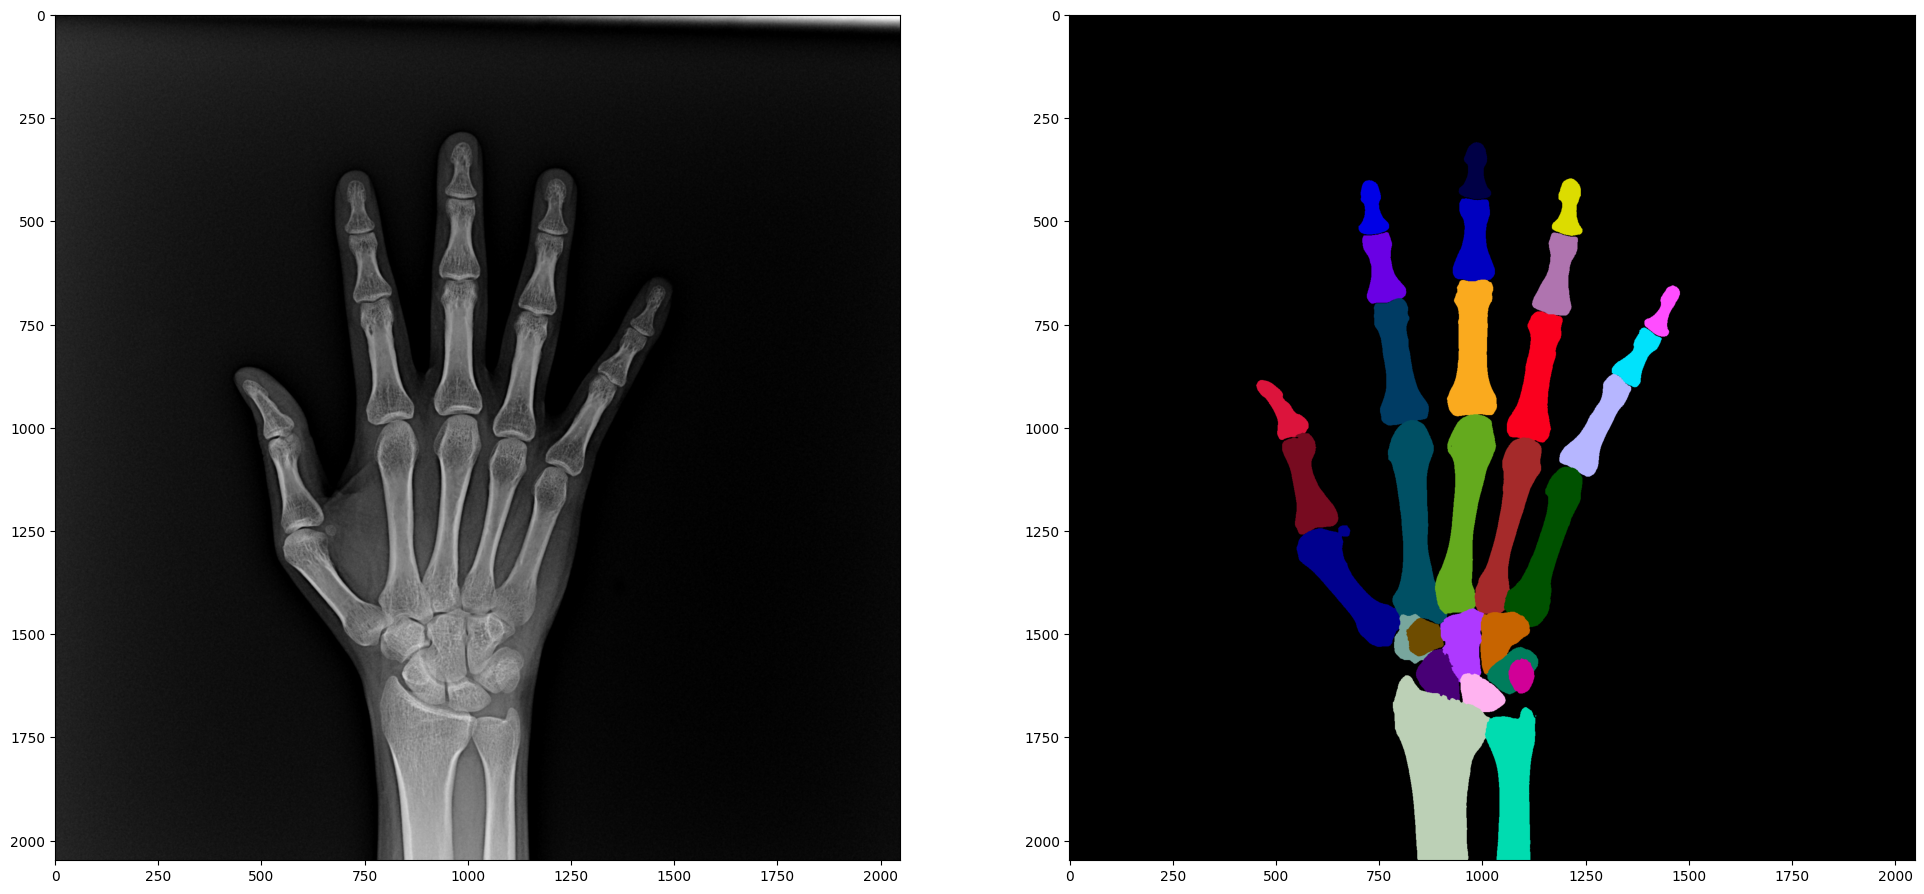

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].imshow(image)    # remove channel dimension
ax[1].imshow(label2rgb(preds))

plt.show()

# To CSV

In [47]:
classes, filename = zip(*[x.split("_") for x in filename_and_class])

In [48]:
image_name = [os.path.basename(f) for f in filename]

In [49]:
df = pd.DataFrame({
    "image_name": image_name,
    "class": classes,
    "rle": rles,
})

In [50]:
df.head(30)

,image_name,class,rle
0,image1661319116107.png,finger-1,1814992 8 1817038 15 1819085 20 1821131 25 182...
1,image1661319116107.png,finger-2,2075190 1 2077236 9 2079282 19 2081327 24 2083...
2,image1661319116107.png,finger-3,2536086 13 2538131 16 2540177 19 2542224 20 25...
3,image1661319116107.png,finger-4,824022 3 826065 14 828110 19 830157 22 832204 ...
4,image1661319116107.png,finger-5,1082111 5 1084157 9 1086202 13 1088244 19 1090...
5,image1661319116107.png,finger-6,1409820 11 1411864 16 1413910 20 1415956 23 14...
6,image1661319116107.png,finger-7,2014010 11 2016055 21 2018099 27 2020145 31 20...
7,image1661319116107.png,finger-8,635866 3 637910 12 639955 18 642002 21 644049 ...
8,image1661319116107.png,finger-9,914368 4 916408 19 918455 25 920502 30 920551 ...
9,image1661319116107.png,finger-10,1317861 13 1319863 8 1319903 23 1321909 14 132...


In [51]:
df.to_csv("output_left.csv", index=False)